In [848]:
from analytical import *
from analytical import pc_profile as apc
from numerical import pc_profile as npc
from numerical import propag_deputy_and_analysis_col
from mubody.mission import Mission
from matplotlib import pyplot as plt
import numpy as np
import math
import pandas as pd
from tqdm.auto import tqdm
import os
import utilities as utl
from astropy_healpix import HEALPix

from matplotlib import ticker, cm
from matplotlib import colors
from matplotlib.ticker import LogLocator

%load_ext autoreload
%autoreload 2

# %load_ext line_profiler
# %matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This notebook perform the analysis and plots the results of the case of study section from the collision risk chapter in the PhD thesis

# Test configuration

In [849]:
#if true, generates chief orbit
generate = True

#if true, saves figures
save = True

#if true saves data, else loads it
save_data = True


#time period
t0 = 0
tf = 86400

#nominal collision risk parameters
#distance between satellites [m]
d = 100

#safety sphere radius [m]
D = 5

#relation between sigmas
q = 0.2

#sigma of lateral velocity component [m/s]
sigma_vv = 3e-4

#Number of cases for monte-carlo analysis
N = 100
Na = 50

n = 9

#time resolution (time between distance check)
dT = 100

#vector with the mean value of the guassian distribution of each velocity component
mean_vector = np.array([0, 0, 0])

#Relative position
theta = 0
phi = 0

#comments
verbose = True

#type of probability
ptype = 'TP'


#path to store figures
figures_path = 'PhD/Results/case/figures/'
file_path = 'PhD/Results/case/data/'

In [850]:
mt = 180 * 86400
orbit_revolutions = mt/(180*86400)
model = 'CRTBP'
opt_iter = 3
chief_orbit_path = 'validation/chief_orbit'
chief_orbit_name = 'chief_orbit_OTM_' + str(opt_iter) + '_' + str(np.round(orbit_revolutions,1)) + '_' + model

chief = Mission(mission_time=mt, SRP_flag=False)
chief.DS.models['CRTBP'].srp.mass = 1000
chief.DS.models['CRTBP'].srp.area = 10

deputy = Mission(mission_time=tf, SRP_flag=False)
deputy.DS.models['CRTBP'].srp.mass = 10
deputy.DS.models['CRTBP'].srp.area = 0.10

if generate:
    chief.OTM(opt_iterations=opt_iter, bar=False, frame='P1-IdealSynodic')
    chief.save(chief_orbit_name, dir_name=chief_orbit_path)
else:
    try:
        chief.load(chief_orbit_name, chief_orbit_path)
    except Exception:
        print("Error, such mission does not exist")

Mission Simulated (CRTBP/Differential corrections) 


Mission successfully saved


In [851]:
default_kwargs = {'t0': t0, 
        'tf' : tf,
        'd' : d, 
        'D' : D,
        'q' : q,
        'sigma_vv' : sigma_vv,
        'N' : N,
        'dT' : dT,
        'ptype' : ptype,
        'depRelVel' : mean_vector,
        'theta' : theta,
        'phi' : phi,
        'chief' : chief,
        'deputy' : deputy,
        'comt' : False,
        'Na' : Na,
        'n' : n,
        't0OrbChief' : 7510000
        }

if save_data:
        os.makedirs(file_path, exist_ok=True)
        file = open(file_path + "/test_conf.txt","w",)
 
        for key, value in default_kwargs.items():
        
                file.write('%s:%s\n' % (key, value))
        
        file.close()

In [852]:
def numeric_sweep(default_kwargs, parameter_name, parameter_list, tag):
    if save_data:
        kwargs = dict(default_kwargs)

        Nbar = len(parameter_list)
        pbar = tqdm(total=Nbar)

        results_sweep_list = []
        
        for p in parameter_list:
            results_sweep_dict = {}

            kwargs[parameter_name] = p

            x, y = npc(**kwargs)

            results_sweep_dict['time'] = x
            results_sweep_dict['TP'] = y[0]
            results_sweep_dict['IP'] = y[1]
            results_sweep_dict[parameter_name] = p
            
            results_sweep_list.append(results_sweep_dict)
            
            pbar.update(1)

        pbar.close()

        results_sweep_df = pd.DataFrame(data=results_sweep_list)

        utl.store(results_sweep_df, tag, file_path)
    else:
        results_sweep_df = utl.recover(tag, file_path)


    return results_sweep_df

def numeric_sweep_double(default_kwargs, parameter_name_1, parameter_list_1, parameter_name_2, parameter_list_2, tag):
    if save_data:
        kwargs = dict(default_kwargs)

        Nbar = len(parameter_list_1)
        pbar = tqdm(total=Nbar)

        results_sweep_list = []
        
        for idx, p in enumerate(parameter_list_1):
            results_sweep_dict = {}

            kwargs[parameter_name_1] = p
            kwargs[parameter_name_2] = parameter_list_2[idx]

            x, y = npc(**kwargs)

            results_sweep_dict['time'] = x
            results_sweep_dict['TP'] = y[0]
            results_sweep_dict['IP'] = y[1]
            results_sweep_dict[parameter_name_1] = p
            results_sweep_dict[parameter_name_2] = parameter_list_2[idx]
            
            results_sweep_list.append(results_sweep_dict)
            
            pbar.update(1)

        pbar.close()

        results_sweep_df = pd.DataFrame(data=results_sweep_list)

        utl.store(results_sweep_df, tag, file_path)
    else:
        results_sweep_df = utl.recover(tag, file_path)

    return results_sweep_df


def analytic_sweep(default_kwargs, parameter_name, parameter_list):

    kwargs = dict(default_kwargs)

    n = len(parameter_list)
    pbar = tqdm(total=n)

    results_sweep_list = []
    
    for p in parameter_list:
        results_sweep_dict = {}

        kwargs[parameter_name] = p

        kwargs['ptype'] = 'IP'
        x, y_ip = apc(**kwargs)
        results_sweep_dict['time'] = x
        results_sweep_dict['IP'] = y_ip

        kwargs['ptype'] = 'TP'
        x, y_tp = apc(**kwargs)
        results_sweep_dict['TP'] = y_tp

        results_sweep_dict[parameter_name] = p
        
        results_sweep_list.append(results_sweep_dict)

        pbar.update(1)

    pbar.close()

    results_sweep_df = pd.DataFrame(data=results_sweep_list)

    return results_sweep_df


def plot_df(df, parameter_name, result='IP', tag=None, save=False, legend_flag=True):
    index = df.index.values
    fig, ax = plt.subplots()
    legend = []

    for ids in index:
        xp = df.iloc[ids]['time']
        yp = df.iloc[ids][result]
        ax.plot(xp, yp)
        legend.append(parameter_name + '=' + str(df.iloc[ids][parameter_name]))
        
    if legend_flag: ax.legend(legend)

    ax.set_title(str(result) + " variation over " + str(parameter_name))

    if save:
        os.makedirs(figures_path, exist_ok=True)
        if tag==None: tag = parameter_name
        fig.savefig(figures_path + tag + '.jpg', dpi=300, format='jpg')


    return fig, ax

In [864]:
def plot_double_contours(x_list, y_list, Z, xlog_flag=False, ylog_flag=False, zlog_flag=False, xlabel=None, ylabel=None, tag='', cbarlabel='', figures_path='', save=False, **kwargs):

    # TP
    subtag = 'TP_' + tag
    cbarlabel = 'Cumulative probability of collision'
    fig_tp, ax_tp = plot_contour(x_list, y_list, Z[0], xlog_flag, ylog_flag, zlog_flag, xlabel, ylabel, subtag, cbarlabel, figures_path, save, **kwargs)

    # IP
    subtag = 'IP_' + tag
    cbarlabel = 'Instantaneous probability of collision'
    fig_ip, ax_ip = plot_contour(x_list, y_list, Z[1], xlog_flag, ylog_flag, zlog_flag, xlabel, ylabel, subtag, cbarlabel, figures_path, save, **kwargs)

    return (fig_tp, ax_tp), (fig_ip, ax_ip)

def plot_contour(x_list, y_list, Z, xlog_flag=False, ylog_flag=False, zlog_flag=False, xlabel=None, ylabel=None, tag='', cbarlabel='', figures_path='', save=False, **kwargs):
    default_plotting_kwargs = {'alpha':0.75,
                    'cmap': cm.coolwarm,
                    'colors': 'black',
                    'linewidths': 0.9,
                    'negative_linestyles': 'solid',
                    'inline': True,
                    'fontsize': 10}

    pk = {**default_plotting_kwargs, **kwargs}

    X, Y = np.meshgrid(x_list, y_list)

    fig, ax = plt.subplots()
    
    if xlog_flag: ax.set_xscale('log')
    if ylog_flag: ax.set_yscale('log')
    if zlog_flag: 
        locator = ticker.LogLocator()
        fmt = ticker.LogFormatterMathtext()
    else:
        locator = None
        fmt = ticker.ScalarFormatter()
    fmt.create_dummy_axis()
    
    CS_filled = ax.contourf(X, Y, Z, locator=locator, alpha=pk['alpha'], cmap=pk['cmap'])

    CS = ax.contour(X, Y, Z, locator=locator, colors=pk['colors'], negative_linestyles=pk['negative_linestyles'], linewidths=pk['linewidths'])

    ax.clabel(CS, inline=pk['inline'], fontsize=pk['fontsize'], fmt=fmt)

    ax.set_ylabel(xlabel, size=pk['fontsize'])
    ax.set_xlabel(ylabel, size=pk['fontsize'])

    ax.tick_params(axis='both', which='major', labelsize=pk['fontsize'])

    cbar = fig.colorbar(CS_filled)
    cbar.ax.set_ylabel(cbarlabel, size=pk['fontsize'])

    fig.tight_layout()

    if save:
        fig.savefig(figures_path + tag + '.pdf', dpi=300, format='pdf')
        print(figures_path + tag)
    
    return fig, ax

def plot_double_profiles(df, parameter_name, ylog_flag=False, minortick_flag=False, tag='', figures_path='', save=False, ft=10,  **kwargs):

    # TP
    subtag = 'TP_' + tag
    fig_tp, ax_tp = plot_profile(df, parameter_name, 'TP', ylog_flag, minortick_flag, subtag, figures_path, save, ft,  **kwargs)

    # IP
    subtag = 'IP_' + tag
    fig_ip, ax_ip = plot_profile(df, parameter_name, 'IP', ylog_flag, minortick_flag, subtag, figures_path, save, ft,  **kwargs)

    return (fig_tp, ax_tp), (fig_ip, ax_ip)

def plot_profile(df, parameter_name, result='TP', ylog_flag=False,  minortick_flag=False, tag='', figures_path='', save=False, ft=10, **kwargs):
    default_plotting_kwargs = {'fontsize': 10,
                                'legend_unit': 'm'}

    ylabels = {'TP': 'Cumulative probability of collision',
              'IP': 'Instantaneous probability of collision'}

    pk = {**default_plotting_kwargs, **kwargs}

    index = df.index.values

    fig, ax = plt.subplots()

    legend = []
    
    if ylog_flag: ax.set_yscale('log')
   
    for ids in index:
        xp = df.iloc[ids]['time']/3600
        yp = df.iloc[ids][result]
        ax.plot(xp, yp)
        if 'legend_name' in pk:
            if 'legend_list' in pk:
                legend.append('$' + pk['legend_name'] + '=' + '{:.0e}'.format(pk['legend_list'][ids]) + '$ ' + pk['legend_unit'])
            else:    
                legend.append('$' + pk['legend_name'] + '=' + '{:.0e}'.format(df.iloc[ids][parameter_name]) + '$ ' + pk['legend_unit'])
        else: 
            legend.append('$' + parameter_name + '=' + str(df.iloc[ids][parameter_name]) + '$ ' + pk['legend_unit'])
    

    ax.set_xlabel(xlabel, size=pk['fontsize'])
    ax.set_ylabel(ylabels[result], size=pk['fontsize'])

    ax.tick_params(axis='x', which='major', labelsize=pk['fontsize'])
    
    if ylog_flag: ax.set_ylim([1e-20, np.concatenate(df[result].values).max() * ft])

    if kwargs['legend_flag']: ax.legend(legend)

    if minortick_flag:
        ax.yaxis.set_minor_locator(LogLocator(numticks=999, subs="auto"))
        ax.grid(True, which="both")
    else:
        ax.grid(True, which='major')

    fig.tight_layout()

    if save:
        os.makedirs(figures_path, exist_ok=True)
        fig.savefig(figures_path + tag + '.pdf', dpi=300, format='pdf')
        print(figures_path + tag)

    return fig, ax

In [855]:
parameter_name = 'd'
parameter_list = [100]
d_kwargs = default_kwargs
default_kwargs['']

d_df = analytic_sweep(default_kwargs, parameter_name, parameter_list)

100%|██████████| 1/1 [00:03<00:00,  3.48s/it]


PhD/Results/case/figures/profile_tp
PhD/Results/case/figures/profile_ip


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Time [h]', ylabel='Instantaneous probability of collision'>)

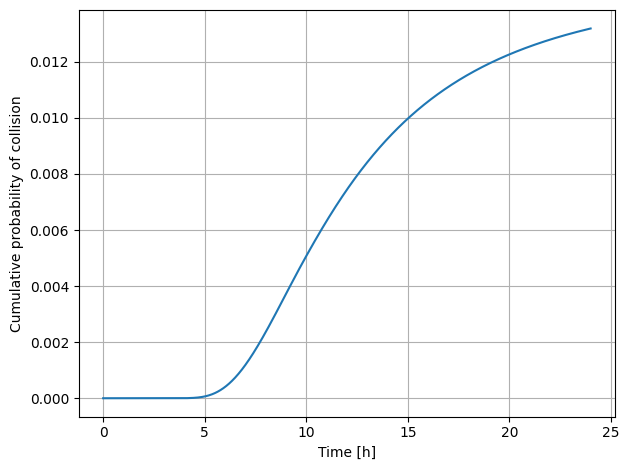

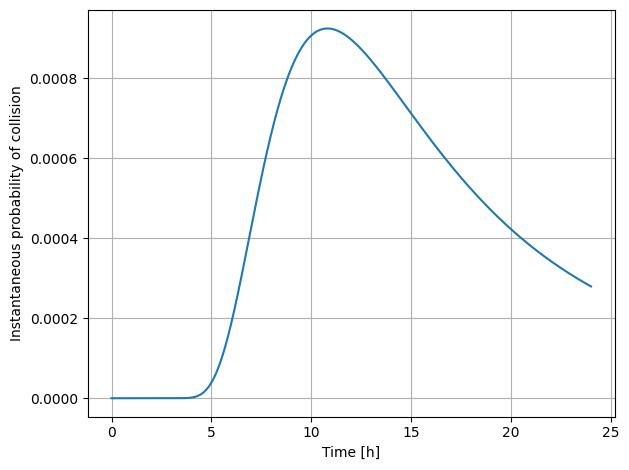

In [866]:
plot_profile(d_df, 'd', tag='profile_tp', figures_path=figures_path, save=True, legend_flag=False)
plot_profile(d_df, 'd', tag='profile_ip', figures_path=figures_path, save=True, result='IP', legend_flag=False)

In [840]:
parameter_name = 'd'
parameter_list = [100, 250, 500, 1000]

d_asweep_df = analytic_sweep(default_kwargs, parameter_name, parameter_list)

100%|██████████| 4/4 [00:40<00:00, 10.24s/it]


PhD/Results/case/figures/TP_sweep_d
PhD/Results/case/figures/IP_sweep_d


((<Figure size 640x480 with 1 Axes>,
  <Axes: xlabel='Time [h]', ylabel='Cumulative probability of collision'>),
 (<Figure size 640x480 with 1 Axes>,
  <Axes: xlabel='Time [h]', ylabel='Instantaneous probability of collision'>))

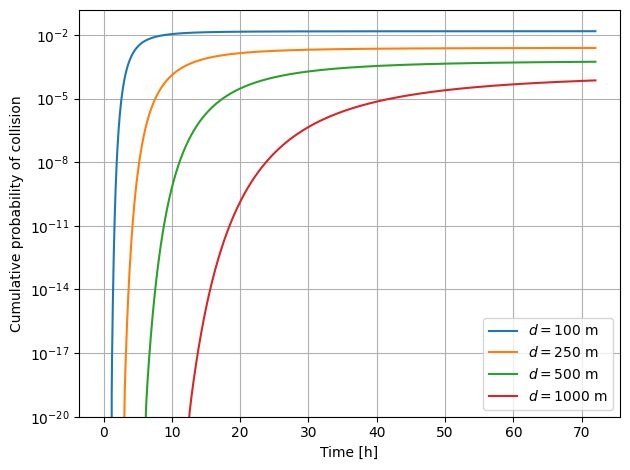

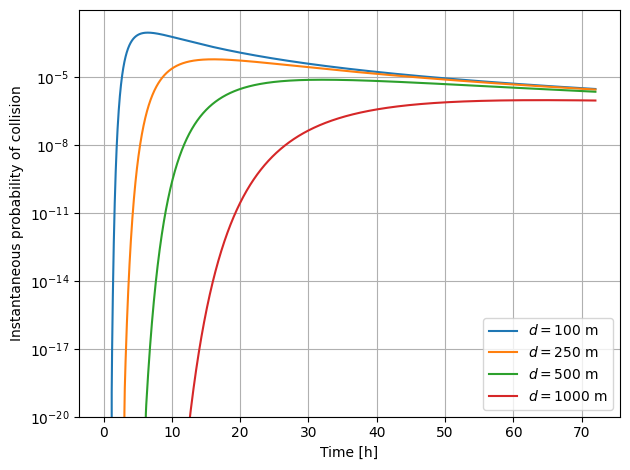

In [841]:
plot_double_profiles(d_asweep_df, 'd', ylog_flag=True, minortick_flag=False, tag='sweep_d', figures_path=figures_path, save=True)

In [784]:
parameter_name = 'D'
parameter_list = [1, 5, 10]

D_asweep_df = analytic_sweep(default_kwargs, parameter_name, parameter_list)

100%|██████████| 3/3 [00:11<00:00,  3.69s/it]


PhD/Results/case/figures/TP_sweep_DD
PhD/Results/case/figures/IP_sweep_DD


((<Figure size 640x480 with 1 Axes>,
  <Axes: xlabel='Time [h]', ylabel='Cumulative probability of collision'>),
 (<Figure size 640x480 with 1 Axes>,
  <Axes: xlabel='Time [h]', ylabel='Instantaneous probability of collision'>))

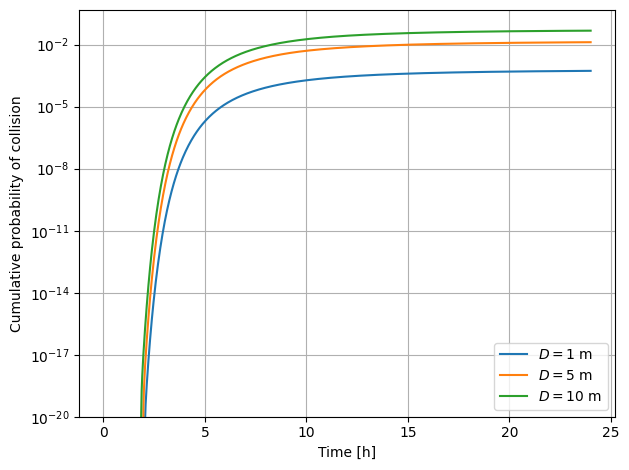

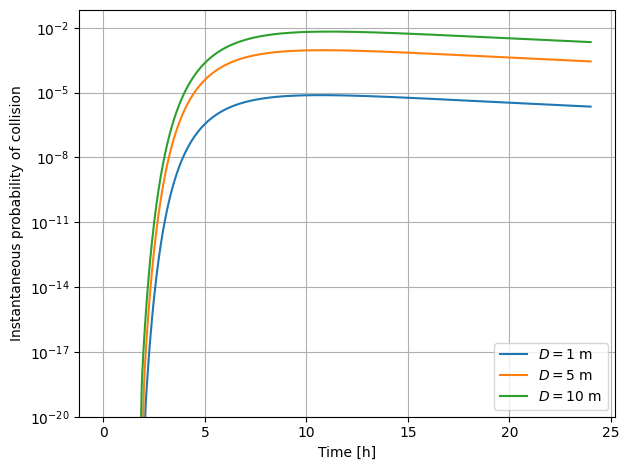

In [828]:
plot_double_profiles(D_asweep_df, 'D', ylog_flag=True, minortick_flag=False, tag='sweep_DD', figures_path=figures_path, save=True, ft=10)

In [846]:
parameter_name = 'sigma_vv'
parameter_list = np.logspace(-5, -2, 10)
parameter_list = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
parameter_list = np.flip([1e-4, 2e-4, 5e-4, 1e-3, 1e-2])

sigma_vv_asweep_df = analytic_sweep(default_kwargs, parameter_name, parameter_list)

100%|██████████| 5/5 [00:55<00:00, 11.13s/it]


PhD/Results/case/figures/TP_sweep_sigma_vv
PhD/Results/case/figures/IP_sweep_sigma_vv


((<Figure size 640x480 with 1 Axes>,
  <Axes: xlabel='Time [h]', ylabel='Cumulative probability of collision'>),
 (<Figure size 640x480 with 1 Axes>,
  <Axes: xlabel='Time [h]', ylabel='Instantaneous probability of collision'>))

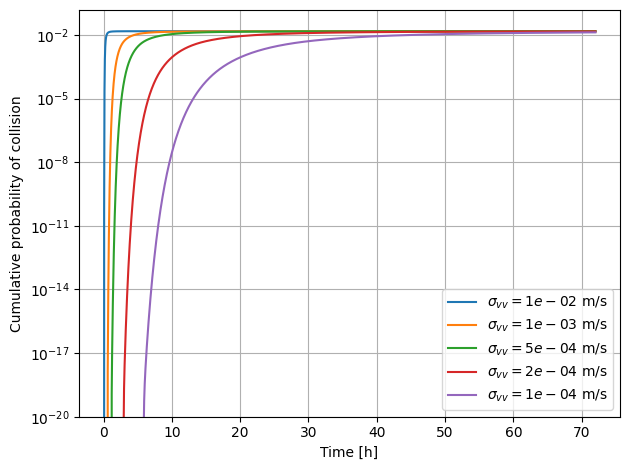

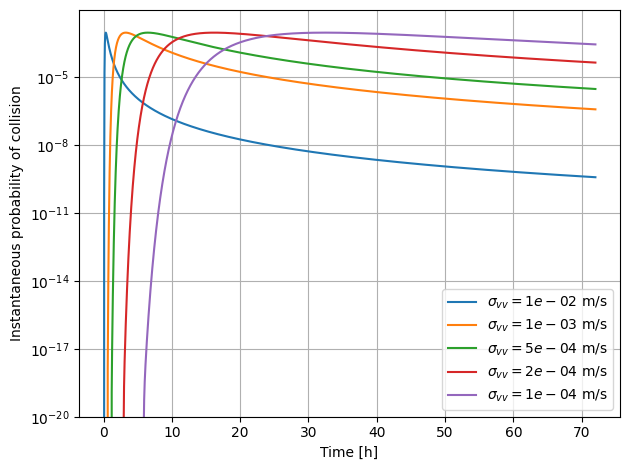

In [847]:
plot_double_profiles(sigma_vv_asweep_df, 'sigma_vv', ylog_flag=True, minortick_flag=False, tag='sweep_sigma_vv', figures_path=figures_path, save=True, ft=10, legend_name=r'\sigma_{vv}', legend_unit='m/s')


In [821]:
default_kwargs['d'] = 100
default_kwargs['sigma_vv'] = 5e-4
default_kwargs['tf'] = 86400*3

In [825]:
parameter_name = 'q'
parameter_list = [0.1, 0.2, 0.5, 1, 2, 5]

sigma_uv_parameter_list = list(default_kwargs['sigma_vv']/np.array(parameter_list))

sigma_uv_asweep_df = analytic_sweep(default_kwargs, parameter_name, parameter_list)

100%|██████████| 6/6 [01:00<00:00, 10.02s/it]


PhD/Results/case/figures/TP_sweep_sigma_uv
PhD/Results/case/figures/IP_sweep_sigma_uv


((<Figure size 640x480 with 1 Axes>,
  <Axes: xlabel='Time [h]', ylabel='Cumulative probability of collision'>),
 (<Figure size 640x480 with 1 Axes>,
  <Axes: xlabel='Time [h]', ylabel='Instantaneous probability of collision'>))

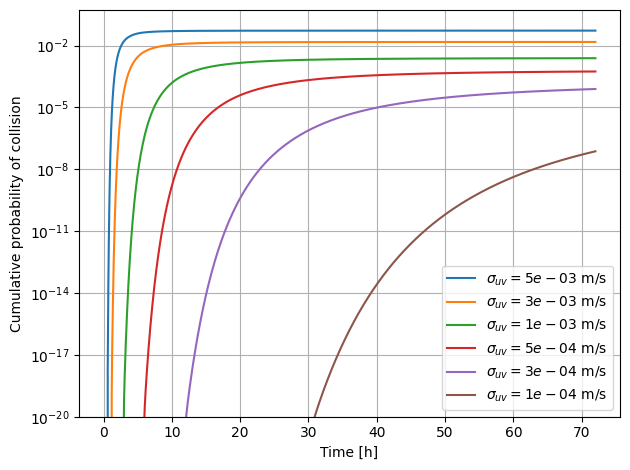

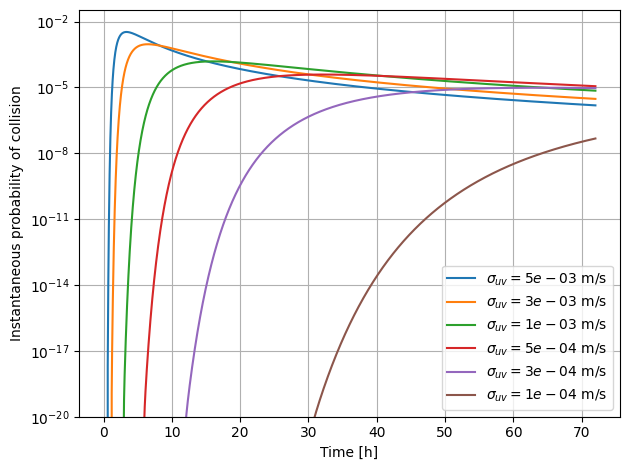

In [845]:
plot_double_profiles(sigma_uv_asweep_df, 'q', ylog_flag=True, minortick_flag=False, tag='sweep_sigma_uv', figures_path=figures_path, save=True, ft=10, legend_name=r'\sigma_{uv}', legend_unit='m/s', legend_list=sigma_uv_parameter_list)


# Double sweep Ip max

In [568]:
n = 50

In [570]:

default_kwargs['D'] = 5
default_kwargs['d'] = 100

In [571]:
sigmas_v_list = np.logspace(-6, -2.5, n)
sigmas_u_list = np.logspace(-3.1, -2, n)

data_sigmas_IP = np.zeros((len(sigmas_v_list), len(sigmas_u_list)))
data_sigmas_TP = np.zeros_like(data_sigmas_IP)

areas_df = []
parameter_name='N'
parameter_list = [100]

for i in range((len(sigmas_v_list))):
    default_kwargs['sigma_vv'] = sigmas_v_list[i]
    print(i)
    for j in range(len(sigmas_u_list)):
        default_kwargs['q'] = sigmas_v_list[i]/sigmas_u_list[j]     
        df = analytic_sweep(default_kwargs, parameter_name, parameter_list)
        data_sigmas_TP[i, j] = df.iloc[0]['TP'].max()
        data_sigmas_IP[i, j] = df.iloc[0]['IP'].max()

0








100%|██████████| 1/1 [00:14<00:00, 14.54s/it]






100%|██████████| 1/1 [00:14<00:00, 14.68s/it]






100%|██████████| 1/1 [00:14<00:00, 14.81s/it]






100%|██████████| 1/1 [00:14<00:00, 14.96s/it]






100%|██████████| 1/1 [00:15<00:00, 15.08s/it]






100%|██████████| 1/1 [00:15<00:00, 15.21s/it]






100%|██████████| 1/1 [00:15<00:00, 15.40s/it]






100%|██████████| 1/1 [00:15<00:00, 15.44s/it]






100%|██████████| 1/1 [00:15<00:00, 15.53s/it]






100%|██████████| 1/1 [00:15<00:00, 15.67s/it]






100%|██████████| 1/1 [00:15<00:00, 15.72s/it]






100%|██████████| 1/1 [00:15<00:00, 15.84s/it]






100%|██████████| 1/1 [00:15<00:00, 15.89s/it]






100%|██████████| 1/1 [00:16<00:00, 16.09s/it]






100%|██████████| 1/1 [00:16<00:00, 16.08s/it]






100%|██████████| 1/1 [00:16<00:00, 16.18s/it]






100%|██████████| 1/1 [00:16<00:00, 16.23s/it]






100%|██████████| 1/1 [00:16<00:00, 16.32s/it]






100%|██████████| 1/1 [00:16<00:00, 16.35s/it]






100%|█

1








100%|██████████| 1/1 [00:15<00:00, 15.33s/it]






100%|██████████| 1/1 [00:15<00:00, 15.22s/it]






100%|██████████| 1/1 [00:15<00:00, 15.52s/it]






100%|██████████| 1/1 [00:15<00:00, 15.75s/it]






100%|██████████| 1/1 [00:15<00:00, 15.91s/it]






100%|██████████| 1/1 [00:15<00:00, 15.90s/it]






100%|██████████| 1/1 [00:16<00:00, 16.06s/it]






100%|██████████| 1/1 [00:16<00:00, 16.65s/it]






100%|██████████| 1/1 [00:16<00:00, 16.11s/it]






100%|██████████| 1/1 [00:16<00:00, 16.14s/it]






100%|██████████| 1/1 [00:16<00:00, 16.21s/it]






100%|██████████| 1/1 [00:16<00:00, 16.25s/it]






100%|██████████| 1/1 [00:16<00:00, 16.44s/it]






100%|██████████| 1/1 [00:16<00:00, 16.17s/it]






100%|██████████| 1/1 [00:16<00:00, 16.16s/it]






100%|██████████| 1/1 [00:16<00:00, 16.19s/it]






100%|██████████| 1/1 [00:16<00:00, 16.26s/it]






100%|██████████| 1/1 [00:16<00:00, 16.38s/it]






100%|██████████| 1/1 [00:16<00:00, 16.42s/it]






100%|█

2








100%|██████████| 1/1 [00:14<00:00, 14.51s/it]






100%|██████████| 1/1 [00:14<00:00, 14.66s/it]






100%|██████████| 1/1 [00:14<00:00, 14.79s/it]






100%|██████████| 1/1 [00:14<00:00, 14.99s/it]






100%|██████████| 1/1 [00:15<00:00, 15.12s/it]






100%|██████████| 1/1 [00:15<00:00, 15.20s/it]






100%|██████████| 1/1 [00:15<00:00, 15.30s/it]






100%|██████████| 1/1 [00:15<00:00, 15.46s/it]






100%|██████████| 1/1 [00:15<00:00, 15.59s/it]






100%|██████████| 1/1 [00:15<00:00, 15.70s/it]






100%|██████████| 1/1 [00:15<00:00, 15.90s/it]






100%|██████████| 1/1 [00:15<00:00, 15.85s/it]






100%|██████████| 1/1 [00:15<00:00, 15.94s/it]






100%|██████████| 1/1 [00:16<00:00, 16.09s/it]






100%|██████████| 1/1 [00:16<00:00, 16.20s/it]






100%|██████████| 1/1 [00:16<00:00, 16.19s/it]






100%|██████████| 1/1 [00:16<00:00, 16.29s/it]






100%|██████████| 1/1 [00:16<00:00, 16.34s/it]






100%|██████████| 1/1 [00:16<00:00, 16.45s/it]






100%|█

3








100%|██████████| 1/1 [00:14<00:00, 14.53s/it]






100%|██████████| 1/1 [00:14<00:00, 14.65s/it]






100%|██████████| 1/1 [00:14<00:00, 14.84s/it]






100%|██████████| 1/1 [00:14<00:00, 15.00s/it]






100%|██████████| 1/1 [00:15<00:00, 15.10s/it]






100%|██████████| 1/1 [00:15<00:00, 15.21s/it]






100%|██████████| 1/1 [00:15<00:00, 15.36s/it]






100%|██████████| 1/1 [00:15<00:00, 15.48s/it]






100%|██████████| 1/1 [00:15<00:00, 15.62s/it]






100%|██████████| 1/1 [00:15<00:00, 15.64s/it]






100%|██████████| 1/1 [00:15<00:00, 15.73s/it]






100%|██████████| 1/1 [00:15<00:00, 15.88s/it]






100%|██████████| 1/1 [00:16<00:00, 16.03s/it]






100%|██████████| 1/1 [00:15<00:00, 16.00s/it]






100%|██████████| 1/1 [00:16<00:00, 16.13s/it]






100%|██████████| 1/1 [00:16<00:00, 16.31s/it]






100%|██████████| 1/1 [00:16<00:00, 16.33s/it]






100%|██████████| 1/1 [00:16<00:00, 16.43s/it]






100%|██████████| 1/1 [00:16<00:00, 16.48s/it]






100%|█

4








100%|██████████| 1/1 [00:14<00:00, 14.56s/it]






100%|██████████| 1/1 [00:14<00:00, 14.65s/it]






100%|██████████| 1/1 [00:14<00:00, 14.88s/it]






100%|██████████| 1/1 [00:14<00:00, 14.90s/it]






100%|██████████| 1/1 [00:15<00:00, 15.17s/it]






100%|██████████| 1/1 [00:15<00:00, 15.19s/it]






100%|██████████| 1/1 [00:15<00:00, 15.37s/it]






100%|██████████| 1/1 [00:15<00:00, 15.46s/it]






100%|██████████| 1/1 [00:15<00:00, 15.58s/it]






100%|██████████| 1/1 [00:15<00:00, 15.70s/it]






100%|██████████| 1/1 [00:15<00:00, 15.76s/it]






100%|██████████| 1/1 [00:15<00:00, 15.81s/it]






100%|██████████| 1/1 [00:15<00:00, 15.97s/it]






100%|██████████| 1/1 [00:16<00:00, 16.10s/it]






100%|██████████| 1/1 [00:16<00:00, 16.07s/it]






100%|██████████| 1/1 [00:16<00:00, 16.26s/it]






100%|██████████| 1/1 [00:16<00:00, 16.35s/it]






100%|██████████| 1/1 [00:16<00:00, 16.39s/it]






100%|██████████| 1/1 [00:16<00:00, 16.42s/it]






100%|█

5








100%|██████████| 1/1 [00:14<00:00, 14.57s/it]






100%|██████████| 1/1 [00:14<00:00, 14.70s/it]






100%|██████████| 1/1 [00:14<00:00, 14.86s/it]






100%|██████████| 1/1 [00:14<00:00, 14.92s/it]






100%|██████████| 1/1 [00:15<00:00, 15.11s/it]






100%|██████████| 1/1 [00:15<00:00, 15.23s/it]






100%|██████████| 1/1 [00:15<00:00, 15.38s/it]






100%|██████████| 1/1 [00:15<00:00, 15.46s/it]






100%|██████████| 1/1 [00:15<00:00, 15.72s/it]






100%|██████████| 1/1 [00:15<00:00, 15.67s/it]






100%|██████████| 1/1 [00:15<00:00, 15.74s/it]






100%|██████████| 1/1 [00:15<00:00, 15.96s/it]






100%|██████████| 1/1 [00:15<00:00, 15.99s/it]






100%|██████████| 1/1 [00:16<00:00, 16.07s/it]






100%|██████████| 1/1 [00:16<00:00, 16.18s/it]






100%|██████████| 1/1 [00:16<00:00, 16.24s/it]






100%|██████████| 1/1 [00:16<00:00, 16.21s/it]






100%|██████████| 1/1 [00:16<00:00, 16.33s/it]






100%|██████████| 1/1 [00:16<00:00, 16.38s/it]






100%|█

6








100%|██████████| 1/1 [00:14<00:00, 14.46s/it]






100%|██████████| 1/1 [00:14<00:00, 14.65s/it]






100%|██████████| 1/1 [00:14<00:00, 14.82s/it]






100%|██████████| 1/1 [00:15<00:00, 15.04s/it]






100%|██████████| 1/1 [00:15<00:00, 15.01s/it]






100%|██████████| 1/1 [00:15<00:00, 15.13s/it]






100%|██████████| 1/1 [00:15<00:00, 15.32s/it]






100%|██████████| 1/1 [00:15<00:00, 15.42s/it]






100%|██████████| 1/1 [00:15<00:00, 15.58s/it]






100%|██████████| 1/1 [00:15<00:00, 15.63s/it]






100%|██████████| 1/1 [00:15<00:00, 15.77s/it]






100%|██████████| 1/1 [00:15<00:00, 15.85s/it]






100%|██████████| 1/1 [00:15<00:00, 15.88s/it]






100%|██████████| 1/1 [00:16<00:00, 16.00s/it]






100%|██████████| 1/1 [00:16<00:00, 16.12s/it]






100%|██████████| 1/1 [00:16<00:00, 16.15s/it]






100%|██████████| 1/1 [00:16<00:00, 16.21s/it]






100%|██████████| 1/1 [00:16<00:00, 16.30s/it]






100%|██████████| 1/1 [00:16<00:00, 16.39s/it]






100%|█

7








100%|██████████| 1/1 [00:14<00:00, 14.54s/it]






100%|██████████| 1/1 [00:14<00:00, 14.61s/it]






100%|██████████| 1/1 [00:14<00:00, 14.86s/it]






100%|██████████| 1/1 [00:14<00:00, 14.98s/it]






100%|██████████| 1/1 [00:15<00:00, 15.05s/it]






100%|██████████| 1/1 [00:15<00:00, 15.17s/it]






100%|██████████| 1/1 [00:15<00:00, 15.36s/it]






100%|██████████| 1/1 [00:15<00:00, 15.44s/it]






100%|██████████| 1/1 [00:15<00:00, 15.53s/it]






100%|██████████| 1/1 [00:15<00:00, 15.64s/it]






100%|██████████| 1/1 [00:15<00:00, 15.76s/it]






100%|██████████| 1/1 [00:15<00:00, 15.82s/it]






100%|██████████| 1/1 [00:15<00:00, 15.93s/it]






100%|██████████| 1/1 [00:16<00:00, 16.03s/it]






100%|██████████| 1/1 [00:16<00:00, 16.11s/it]






100%|██████████| 1/1 [00:16<00:00, 16.15s/it]






100%|██████████| 1/1 [00:16<00:00, 16.27s/it]






100%|██████████| 1/1 [00:16<00:00, 16.23s/it]






100%|██████████| 1/1 [00:16<00:00, 16.37s/it]






100%|█

8








100%|██████████| 1/1 [00:14<00:00, 14.45s/it]






100%|██████████| 1/1 [00:14<00:00, 14.67s/it]






100%|██████████| 1/1 [00:14<00:00, 14.84s/it]






100%|██████████| 1/1 [00:15<00:00, 15.01s/it]






100%|██████████| 1/1 [00:15<00:00, 15.08s/it]






100%|██████████| 1/1 [00:15<00:00, 15.21s/it]






100%|██████████| 1/1 [00:15<00:00, 15.35s/it]






100%|██████████| 1/1 [00:15<00:00, 15.40s/it]






100%|██████████| 1/1 [00:15<00:00, 15.59s/it]






100%|██████████| 1/1 [00:15<00:00, 15.66s/it]






100%|██████████| 1/1 [00:15<00:00, 15.78s/it]






100%|██████████| 1/1 [00:15<00:00, 15.75s/it]






100%|██████████| 1/1 [00:15<00:00, 15.93s/it]






100%|██████████| 1/1 [00:16<00:00, 16.04s/it]






100%|██████████| 1/1 [00:16<00:00, 16.13s/it]






100%|██████████| 1/1 [00:16<00:00, 16.20s/it]






100%|██████████| 1/1 [00:16<00:00, 16.27s/it]






100%|██████████| 1/1 [00:16<00:00, 16.35s/it]






100%|██████████| 1/1 [00:16<00:00, 16.36s/it]






100%|█

9








100%|██████████| 1/1 [00:14<00:00, 14.54s/it]






100%|██████████| 1/1 [00:14<00:00, 14.70s/it]






100%|██████████| 1/1 [00:14<00:00, 14.84s/it]






100%|██████████| 1/1 [00:14<00:00, 14.96s/it]






100%|██████████| 1/1 [00:15<00:00, 15.06s/it]






100%|██████████| 1/1 [00:15<00:00, 15.34s/it]






100%|██████████| 1/1 [00:15<00:00, 15.44s/it]






100%|██████████| 1/1 [00:15<00:00, 15.48s/it]






100%|██████████| 1/1 [00:15<00:00, 15.59s/it]






100%|██████████| 1/1 [00:15<00:00, 15.72s/it]






100%|██████████| 1/1 [00:15<00:00, 15.74s/it]






100%|██████████| 1/1 [00:15<00:00, 15.80s/it]






100%|██████████| 1/1 [00:15<00:00, 15.93s/it]






100%|██████████| 1/1 [00:16<00:00, 16.12s/it]






100%|██████████| 1/1 [00:16<00:00, 16.09s/it]






100%|██████████| 1/1 [00:16<00:00, 16.22s/it]






100%|██████████| 1/1 [00:16<00:00, 16.30s/it]






100%|██████████| 1/1 [00:16<00:00, 16.32s/it]






100%|██████████| 1/1 [00:16<00:00, 16.46s/it]






100%|█

10








100%|██████████| 1/1 [00:14<00:00, 14.58s/it]






100%|██████████| 1/1 [00:14<00:00, 14.73s/it]






100%|██████████| 1/1 [00:14<00:00, 14.82s/it]






100%|██████████| 1/1 [00:14<00:00, 14.99s/it]






100%|██████████| 1/1 [00:15<00:00, 15.07s/it]






100%|██████████| 1/1 [00:15<00:00, 15.23s/it]






100%|██████████| 1/1 [00:15<00:00, 15.35s/it]






100%|██████████| 1/1 [00:15<00:00, 15.50s/it]






100%|██████████| 1/1 [00:15<00:00, 15.60s/it]






100%|██████████| 1/1 [00:15<00:00, 15.65s/it]






100%|██████████| 1/1 [00:15<00:00, 15.78s/it]






100%|██████████| 1/1 [00:15<00:00, 15.87s/it]






100%|██████████| 1/1 [00:15<00:00, 15.92s/it]






100%|██████████| 1/1 [00:16<00:00, 16.03s/it]






100%|██████████| 1/1 [00:16<00:00, 16.13s/it]






100%|██████████| 1/1 [00:16<00:00, 16.18s/it]






100%|██████████| 1/1 [00:16<00:00, 16.30s/it]






100%|██████████| 1/1 [00:16<00:00, 16.33s/it]






100%|██████████| 1/1 [00:16<00:00, 16.48s/it]






100%|█

11








100%|██████████| 1/1 [00:14<00:00, 14.55s/it]






100%|██████████| 1/1 [00:14<00:00, 14.73s/it]






100%|██████████| 1/1 [00:14<00:00, 14.86s/it]






100%|██████████| 1/1 [00:14<00:00, 14.95s/it]






100%|██████████| 1/1 [00:15<00:00, 15.06s/it]






100%|██████████| 1/1 [00:15<00:00, 15.20s/it]






100%|██████████| 1/1 [00:15<00:00, 15.37s/it]






100%|██████████| 1/1 [00:15<00:00, 15.46s/it]






100%|██████████| 1/1 [00:15<00:00, 15.63s/it]






100%|██████████| 1/1 [00:15<00:00, 15.66s/it]






100%|██████████| 1/1 [00:15<00:00, 15.76s/it]






100%|██████████| 1/1 [00:15<00:00, 15.85s/it]






100%|██████████| 1/1 [00:15<00:00, 15.90s/it]






100%|██████████| 1/1 [00:16<00:00, 16.04s/it]






100%|██████████| 1/1 [00:16<00:00, 16.09s/it]






100%|██████████| 1/1 [00:16<00:00, 16.11s/it]






100%|██████████| 1/1 [00:16<00:00, 16.25s/it]






100%|██████████| 1/1 [00:16<00:00, 16.32s/it]






100%|██████████| 1/1 [00:16<00:00, 16.45s/it]






100%|█

12








100%|██████████| 1/1 [00:14<00:00, 14.48s/it]






100%|██████████| 1/1 [00:14<00:00, 14.67s/it]






100%|██████████| 1/1 [00:14<00:00, 14.79s/it]






100%|██████████| 1/1 [00:14<00:00, 14.92s/it]






100%|██████████| 1/1 [00:14<00:00, 14.99s/it]






100%|██████████| 1/1 [00:15<00:00, 15.23s/it]






100%|██████████| 1/1 [00:15<00:00, 15.31s/it]






100%|██████████| 1/1 [00:15<00:00, 15.43s/it]






100%|██████████| 1/1 [00:15<00:00, 15.56s/it]






100%|██████████| 1/1 [00:15<00:00, 15.52s/it]






100%|██████████| 1/1 [00:15<00:00, 15.75s/it]






100%|██████████| 1/1 [00:15<00:00, 15.87s/it]






100%|██████████| 1/1 [00:15<00:00, 15.96s/it]






100%|██████████| 1/1 [00:16<00:00, 16.01s/it]






100%|██████████| 1/1 [00:16<00:00, 16.13s/it]






100%|██████████| 1/1 [00:16<00:00, 16.12s/it]






100%|██████████| 1/1 [00:16<00:00, 16.20s/it]






100%|██████████| 1/1 [00:16<00:00, 16.35s/it]






100%|██████████| 1/1 [00:16<00:00, 16.38s/it]






100%|█

13








100%|██████████| 1/1 [00:14<00:00, 14.43s/it]






100%|██████████| 1/1 [00:14<00:00, 14.45s/it]






100%|██████████| 1/1 [00:14<00:00, 14.69s/it]






100%|██████████| 1/1 [00:14<00:00, 14.80s/it]






100%|██████████| 1/1 [00:14<00:00, 14.95s/it]






100%|██████████| 1/1 [00:15<00:00, 15.05s/it]






100%|██████████| 1/1 [00:15<00:00, 15.18s/it]






100%|██████████| 1/1 [00:15<00:00, 15.29s/it]






100%|██████████| 1/1 [00:15<00:00, 15.44s/it]






100%|██████████| 1/1 [00:15<00:00, 15.48s/it]






100%|██████████| 1/1 [00:15<00:00, 15.56s/it]






100%|██████████| 1/1 [00:15<00:00, 15.69s/it]






100%|██████████| 1/1 [00:15<00:00, 15.77s/it]






100%|██████████| 1/1 [00:15<00:00, 15.86s/it]






100%|██████████| 1/1 [00:15<00:00, 15.88s/it]






100%|██████████| 1/1 [00:15<00:00, 15.91s/it]






100%|██████████| 1/1 [00:16<00:00, 16.09s/it]






100%|██████████| 1/1 [00:16<00:00, 16.14s/it]






100%|██████████| 1/1 [00:16<00:00, 16.26s/it]






100%|█

14








100%|██████████| 1/1 [00:14<00:00, 14.18s/it]






100%|██████████| 1/1 [00:14<00:00, 14.23s/it]






100%|██████████| 1/1 [00:14<00:00, 14.44s/it]






100%|██████████| 1/1 [00:14<00:00, 14.57s/it]






100%|██████████| 1/1 [00:14<00:00, 14.67s/it]






100%|██████████| 1/1 [00:14<00:00, 14.75s/it]






100%|██████████| 1/1 [00:14<00:00, 14.92s/it]






100%|██████████| 1/1 [00:14<00:00, 14.98s/it]






100%|██████████| 1/1 [00:15<00:00, 15.18s/it]






100%|██████████| 1/1 [00:15<00:00, 15.21s/it]






100%|██████████| 1/1 [00:15<00:00, 15.32s/it]






100%|██████████| 1/1 [00:15<00:00, 15.45s/it]






100%|██████████| 1/1 [00:15<00:00, 15.53s/it]






100%|██████████| 1/1 [00:15<00:00, 15.61s/it]






100%|██████████| 1/1 [00:15<00:00, 15.74s/it]






100%|██████████| 1/1 [00:15<00:00, 15.75s/it]






100%|██████████| 1/1 [00:15<00:00, 15.83s/it]






100%|██████████| 1/1 [00:15<00:00, 15.91s/it]






100%|██████████| 1/1 [00:15<00:00, 15.98s/it]






100%|█

15








100%|██████████| 1/1 [00:13<00:00, 13.85s/it]






100%|██████████| 1/1 [00:13<00:00, 13.88s/it]






100%|██████████| 1/1 [00:14<00:00, 14.18s/it]






100%|██████████| 1/1 [00:14<00:00, 14.22s/it]






100%|██████████| 1/1 [00:14<00:00, 14.41s/it]






100%|██████████| 1/1 [00:14<00:00, 14.51s/it]






100%|██████████| 1/1 [00:14<00:00, 14.61s/it]






100%|██████████| 1/1 [00:14<00:00, 14.78s/it]






100%|██████████| 1/1 [00:14<00:00, 14.82s/it]






100%|██████████| 1/1 [00:14<00:00, 14.94s/it]






100%|██████████| 1/1 [00:15<00:00, 15.06s/it]






100%|██████████| 1/1 [00:15<00:00, 15.15s/it]






100%|██████████| 1/1 [00:15<00:00, 15.23s/it]






100%|██████████| 1/1 [00:15<00:00, 15.34s/it]






100%|██████████| 1/1 [00:15<00:00, 15.45s/it]






100%|██████████| 1/1 [00:15<00:00, 15.48s/it]






100%|██████████| 1/1 [00:15<00:00, 15.56s/it]






100%|██████████| 1/1 [00:15<00:00, 15.63s/it]






100%|██████████| 1/1 [00:15<00:00, 15.73s/it]






100%|█

16








100%|██████████| 1/1 [00:13<00:00, 13.48s/it]






100%|██████████| 1/1 [00:13<00:00, 13.61s/it]






100%|██████████| 1/1 [00:13<00:00, 13.73s/it]






100%|██████████| 1/1 [00:13<00:00, 13.91s/it]






100%|██████████| 1/1 [00:14<00:00, 14.03s/it]






100%|██████████| 1/1 [00:14<00:00, 14.16s/it]






100%|██████████| 1/1 [00:14<00:00, 14.33s/it]






100%|██████████| 1/1 [00:14<00:00, 14.39s/it]






100%|██████████| 1/1 [00:14<00:00, 14.57s/it]






100%|██████████| 1/1 [00:14<00:00, 14.69s/it]






100%|██████████| 1/1 [00:14<00:00, 14.75s/it]






100%|██████████| 1/1 [00:14<00:00, 14.82s/it]






100%|██████████| 1/1 [00:14<00:00, 14.87s/it]






100%|██████████| 1/1 [00:15<00:00, 15.06s/it]






100%|██████████| 1/1 [00:15<00:00, 15.10s/it]






100%|██████████| 1/1 [00:15<00:00, 15.19s/it]






100%|██████████| 1/1 [00:15<00:00, 15.27s/it]






100%|██████████| 1/1 [00:15<00:00, 15.31s/it]






100%|██████████| 1/1 [00:15<00:00, 15.43s/it]






100%|█

17








100%|██████████| 1/1 [00:13<00:00, 13.14s/it]






100%|██████████| 1/1 [00:13<00:00, 13.24s/it]






100%|██████████| 1/1 [00:13<00:00, 13.42s/it]






100%|██████████| 1/1 [00:13<00:00, 13.55s/it]






100%|██████████| 1/1 [00:13<00:00, 13.68s/it]






100%|██████████| 1/1 [00:13<00:00, 13.77s/it]






100%|██████████| 1/1 [00:13<00:00, 13.90s/it]






100%|██████████| 1/1 [00:14<00:00, 14.02s/it]






100%|██████████| 1/1 [00:14<00:00, 14.16s/it]






100%|██████████| 1/1 [00:14<00:00, 14.30s/it]






100%|██████████| 1/1 [00:14<00:00, 14.39s/it]






100%|██████████| 1/1 [00:14<00:00, 14.48s/it]






100%|██████████| 1/1 [00:14<00:00, 14.64s/it]






100%|██████████| 1/1 [00:14<00:00, 14.69s/it]






100%|██████████| 1/1 [00:14<00:00, 14.78s/it]






100%|██████████| 1/1 [00:14<00:00, 14.80s/it]






100%|██████████| 1/1 [00:14<00:00, 14.90s/it]






100%|██████████| 1/1 [00:14<00:00, 15.00s/it]






100%|██████████| 1/1 [00:15<00:00, 15.12s/it]






100%|█

18








100%|██████████| 1/1 [00:12<00:00, 12.68s/it]






100%|██████████| 1/1 [00:12<00:00, 12.88s/it]






100%|██████████| 1/1 [00:12<00:00, 12.95s/it]






100%|██████████| 1/1 [00:13<00:00, 13.14s/it]






100%|██████████| 1/1 [00:13<00:00, 13.28s/it]






100%|██████████| 1/1 [00:13<00:00, 13.48s/it]






100%|██████████| 1/1 [00:13<00:00, 13.61s/it]






100%|██████████| 1/1 [00:13<00:00, 13.67s/it]






100%|██████████| 1/1 [00:13<00:00, 13.80s/it]






100%|██████████| 1/1 [00:13<00:00, 13.94s/it]






100%|██████████| 1/1 [00:14<00:00, 14.06s/it]






100%|██████████| 1/1 [00:14<00:00, 14.15s/it]






100%|██████████| 1/1 [00:14<00:00, 14.20s/it]






100%|██████████| 1/1 [00:14<00:00, 14.32s/it]






100%|██████████| 1/1 [00:14<00:00, 14.44s/it]






100%|██████████| 1/1 [00:14<00:00, 14.42s/it]






100%|██████████| 1/1 [00:14<00:00, 14.56s/it]






100%|██████████| 1/1 [00:14<00:00, 14.57s/it]






100%|██████████| 1/1 [00:14<00:00, 14.64s/it]






100%|█

19








100%|██████████| 1/1 [00:12<00:00, 12.30s/it]






100%|██████████| 1/1 [00:12<00:00, 12.41s/it]






100%|██████████| 1/1 [00:12<00:00, 12.57s/it]






100%|██████████| 1/1 [00:12<00:00, 12.78s/it]






100%|██████████| 1/1 [00:12<00:00, 12.89s/it]






100%|██████████| 1/1 [00:13<00:00, 13.02s/it]






100%|██████████| 1/1 [00:13<00:00, 13.14s/it]






100%|██████████| 1/1 [00:13<00:00, 13.33s/it]






100%|██████████| 1/1 [00:13<00:00, 13.38s/it]






100%|██████████| 1/1 [00:13<00:00, 13.56s/it]






100%|██████████| 1/1 [00:13<00:00, 13.60s/it]






100%|██████████| 1/1 [00:13<00:00, 13.73s/it]






100%|██████████| 1/1 [00:13<00:00, 13.77s/it]






100%|██████████| 1/1 [00:13<00:00, 13.96s/it]






100%|██████████| 1/1 [00:14<00:00, 14.03s/it]






100%|██████████| 1/1 [00:14<00:00, 14.09s/it]






100%|██████████| 1/1 [00:14<00:00, 14.12s/it]






100%|██████████| 1/1 [00:14<00:00, 14.32s/it]






100%|██████████| 1/1 [00:14<00:00, 14.38s/it]






100%|█

20








100%|██████████| 1/1 [00:11<00:00, 11.89s/it]






100%|██████████| 1/1 [00:11<00:00, 11.97s/it]






100%|██████████| 1/1 [00:12<00:00, 12.18s/it]






100%|██████████| 1/1 [00:12<00:00, 12.37s/it]






100%|██████████| 1/1 [00:12<00:00, 12.53s/it]






100%|██████████| 1/1 [00:12<00:00, 12.59s/it]






100%|██████████| 1/1 [00:12<00:00, 12.79s/it]






100%|██████████| 1/1 [00:12<00:00, 12.91s/it]






100%|██████████| 1/1 [00:13<00:00, 13.00s/it]






100%|██████████| 1/1 [00:13<00:00, 13.13s/it]






100%|██████████| 1/1 [00:13<00:00, 13.25s/it]






100%|██████████| 1/1 [00:13<00:00, 13.43s/it]






100%|██████████| 1/1 [00:13<00:00, 13.39s/it]






100%|██████████| 1/1 [00:13<00:00, 13.57s/it]






100%|██████████| 1/1 [00:13<00:00, 13.65s/it]






100%|██████████| 1/1 [00:13<00:00, 13.75s/it]






100%|██████████| 1/1 [00:13<00:00, 13.87s/it]






100%|██████████| 1/1 [00:13<00:00, 13.94s/it]






100%|██████████| 1/1 [00:14<00:00, 14.03s/it]






100%|█

21








100%|██████████| 1/1 [00:11<00:00, 11.45s/it]






100%|██████████| 1/1 [00:11<00:00, 11.60s/it]






100%|██████████| 1/1 [00:11<00:00, 11.83s/it]






100%|██████████| 1/1 [00:11<00:00, 11.95s/it]






100%|██████████| 1/1 [00:12<00:00, 12.09s/it]






100%|██████████| 1/1 [00:12<00:00, 12.29s/it]






100%|██████████| 1/1 [00:12<00:00, 12.35s/it]






100%|██████████| 1/1 [00:12<00:00, 12.55s/it]






100%|██████████| 1/1 [00:12<00:00, 12.68s/it]






100%|██████████| 1/1 [00:12<00:00, 12.76s/it]






100%|██████████| 1/1 [00:12<00:00, 12.93s/it]






100%|██████████| 1/1 [00:13<00:00, 13.12s/it]






100%|██████████| 1/1 [00:13<00:00, 13.14s/it]






100%|██████████| 1/1 [00:13<00:00, 13.30s/it]






100%|██████████| 1/1 [00:13<00:00, 13.32s/it]






100%|██████████| 1/1 [00:13<00:00, 13.39s/it]






100%|██████████| 1/1 [00:13<00:00, 13.49s/it]






100%|██████████| 1/1 [00:13<00:00, 13.64s/it]






100%|██████████| 1/1 [00:13<00:00, 13.64s/it]






100%|█

22








100%|██████████| 1/1 [00:11<00:00, 11.01s/it]






100%|██████████| 1/1 [00:11<00:00, 11.19s/it]






100%|██████████| 1/1 [00:11<00:00, 11.36s/it]






100%|██████████| 1/1 [00:11<00:00, 11.51s/it]






100%|██████████| 1/1 [00:11<00:00, 11.67s/it]






100%|██████████| 1/1 [00:11<00:00, 11.82s/it]






100%|██████████| 1/1 [00:11<00:00, 11.95s/it]






100%|██████████| 1/1 [00:12<00:00, 12.15s/it]






100%|██████████| 1/1 [00:12<00:00, 12.32s/it]






100%|██████████| 1/1 [00:12<00:00, 12.42s/it]






100%|██████████| 1/1 [00:12<00:00, 12.53s/it]






100%|██████████| 1/1 [00:12<00:00, 12.63s/it]






100%|██████████| 1/1 [00:12<00:00, 12.79s/it]






100%|██████████| 1/1 [00:12<00:00, 12.82s/it]






100%|██████████| 1/1 [00:13<00:00, 13.03s/it]






100%|██████████| 1/1 [00:13<00:00, 13.07s/it]






100%|██████████| 1/1 [00:13<00:00, 13.19s/it]






100%|██████████| 1/1 [00:13<00:00, 13.26s/it]






100%|██████████| 1/1 [00:13<00:00, 13.27s/it]






100%|█

23








100%|██████████| 1/1 [00:10<00:00, 10.52s/it]






100%|██████████| 1/1 [00:10<00:00, 10.74s/it]






100%|██████████| 1/1 [00:10<00:00, 10.94s/it]






100%|██████████| 1/1 [00:11<00:00, 11.07s/it]






100%|██████████| 1/1 [00:11<00:00, 11.27s/it]






100%|██████████| 1/1 [00:11<00:00, 11.39s/it]






100%|██████████| 1/1 [00:11<00:00, 11.59s/it]






100%|██████████| 1/1 [00:11<00:00, 11.78s/it]






100%|██████████| 1/1 [00:11<00:00, 11.90s/it]






100%|██████████| 1/1 [00:11<00:00, 12.00s/it]






100%|██████████| 1/1 [00:12<00:00, 12.19s/it]






100%|██████████| 1/1 [00:12<00:00, 12.25s/it]






100%|██████████| 1/1 [00:12<00:00, 12.47s/it]






100%|██████████| 1/1 [00:12<00:00, 12.47s/it]






100%|██████████| 1/1 [00:12<00:00, 12.58s/it]






100%|██████████| 1/1 [00:12<00:00, 12.77s/it]






100%|██████████| 1/1 [00:12<00:00, 12.83s/it]






100%|██████████| 1/1 [00:12<00:00, 12.92s/it]






100%|██████████| 1/1 [00:12<00:00, 12.98s/it]






100%|█

24








100%|██████████| 1/1 [00:10<00:00, 10.10s/it]






100%|██████████| 1/1 [00:10<00:00, 10.25s/it]






100%|██████████| 1/1 [00:10<00:00, 10.47s/it]






100%|██████████| 1/1 [00:10<00:00, 10.65s/it]






100%|██████████| 1/1 [00:10<00:00, 10.81s/it]






100%|██████████| 1/1 [00:10<00:00, 10.98s/it]






100%|██████████| 1/1 [00:11<00:00, 11.20s/it]






100%|██████████| 1/1 [00:11<00:00, 11.35s/it]






100%|██████████| 1/1 [00:11<00:00, 11.54s/it]






100%|██████████| 1/1 [00:11<00:00, 11.67s/it]






100%|██████████| 1/1 [00:11<00:00, 11.84s/it]






100%|██████████| 1/1 [00:11<00:00, 11.89s/it]






100%|██████████| 1/1 [00:12<00:00, 12.05s/it]






100%|██████████| 1/1 [00:12<00:00, 12.15s/it]






100%|██████████| 1/1 [00:12<00:00, 12.32s/it]






100%|██████████| 1/1 [00:12<00:00, 12.40s/it]






100%|██████████| 1/1 [00:12<00:00, 12.57s/it]






100%|██████████| 1/1 [00:12<00:00, 12.61s/it]






100%|██████████| 1/1 [00:12<00:00, 12.77s/it]






100%|█

25








100%|██████████| 1/1 [00:09<00:00,  9.46s/it]






100%|██████████| 1/1 [00:09<00:00,  9.68s/it]






100%|██████████| 1/1 [00:09<00:00,  9.88s/it]






100%|██████████| 1/1 [00:10<00:00, 10.10s/it]






100%|██████████| 1/1 [00:10<00:00, 10.33s/it]






100%|██████████| 1/1 [00:10<00:00, 10.51s/it]






100%|██████████| 1/1 [00:10<00:00, 10.73s/it]






100%|██████████| 1/1 [00:10<00:00, 10.94s/it]






100%|██████████| 1/1 [00:11<00:00, 11.08s/it]






100%|██████████| 1/1 [00:11<00:00, 11.29s/it]






100%|██████████| 1/1 [00:11<00:00, 11.40s/it]






100%|██████████| 1/1 [00:11<00:00, 11.56s/it]






100%|██████████| 1/1 [00:11<00:00, 11.72s/it]






100%|██████████| 1/1 [00:11<00:00, 11.87s/it]






100%|██████████| 1/1 [00:11<00:00, 11.94s/it]






100%|██████████| 1/1 [00:12<00:00, 12.11s/it]






100%|██████████| 1/1 [00:12<00:00, 12.21s/it]






100%|██████████| 1/1 [00:12<00:00, 12.36s/it]






100%|██████████| 1/1 [00:12<00:00, 12.40s/it]






100%|█

26








100%|██████████| 1/1 [00:08<00:00,  8.91s/it]






100%|██████████| 1/1 [00:09<00:00,  9.09s/it]






100%|██████████| 1/1 [00:09<00:00,  9.43s/it]






100%|██████████| 1/1 [00:09<00:00,  9.60s/it]






100%|██████████| 1/1 [00:09<00:00,  9.82s/it]






100%|██████████| 1/1 [00:10<00:00, 10.01s/it]






100%|██████████| 1/1 [00:10<00:00, 10.27s/it]






100%|██████████| 1/1 [00:10<00:00, 10.40s/it]






100%|██████████| 1/1 [00:10<00:00, 10.64s/it]






100%|██████████| 1/1 [00:10<00:00, 10.81s/it]






100%|██████████| 1/1 [00:11<00:00, 11.01s/it]






100%|██████████| 1/1 [00:11<00:00, 11.13s/it]






100%|██████████| 1/1 [00:11<00:00, 11.32s/it]






100%|██████████| 1/1 [00:11<00:00, 11.52s/it]






100%|██████████| 1/1 [00:11<00:00, 11.57s/it]






100%|██████████| 1/1 [00:11<00:00, 11.74s/it]






100%|██████████| 1/1 [00:11<00:00, 11.86s/it]






100%|██████████| 1/1 [00:11<00:00, 11.98s/it]






100%|██████████| 1/1 [00:12<00:00, 12.07s/it]






100%|█

27








100%|██████████| 1/1 [00:08<00:00,  8.23s/it]






100%|██████████| 1/1 [00:08<00:00,  8.51s/it]






100%|██████████| 1/1 [00:08<00:00,  8.76s/it]






100%|██████████| 1/1 [00:08<00:00,  8.97s/it]






100%|██████████| 1/1 [00:09<00:00,  9.22s/it]






100%|██████████| 1/1 [00:09<00:00,  9.46s/it]






100%|██████████| 1/1 [00:09<00:00,  9.69s/it]






100%|██████████| 1/1 [00:09<00:00,  9.93s/it]






100%|██████████| 1/1 [00:10<00:00, 10.13s/it]






100%|██████████| 1/1 [00:10<00:00, 10.28s/it]






100%|██████████| 1/1 [00:10<00:00, 10.50s/it]






100%|██████████| 1/1 [00:10<00:00, 10.65s/it]






100%|██████████| 1/1 [00:10<00:00, 10.86s/it]






100%|██████████| 1/1 [00:10<00:00, 10.98s/it]






100%|██████████| 1/1 [00:11<00:00, 11.10s/it]






100%|██████████| 1/1 [00:11<00:00, 11.31s/it]






100%|██████████| 1/1 [00:11<00:00, 11.45s/it]






100%|██████████| 1/1 [00:11<00:00, 11.61s/it]






100%|██████████| 1/1 [00:11<00:00, 11.70s/it]






100%|█

28








100%|██████████| 1/1 [00:07<00:00,  7.59s/it]






100%|██████████| 1/1 [00:07<00:00,  7.86s/it]






100%|██████████| 1/1 [00:08<00:00,  8.10s/it]






100%|██████████| 1/1 [00:08<00:00,  8.38s/it]






100%|██████████| 1/1 [00:08<00:00,  8.58s/it]






100%|██████████| 1/1 [00:08<00:00,  8.83s/it]






100%|██████████| 1/1 [00:09<00:00,  9.09s/it]






100%|██████████| 1/1 [00:09<00:00,  9.31s/it]






100%|██████████| 1/1 [00:09<00:00,  9.53s/it]






100%|██████████| 1/1 [00:09<00:00,  9.74s/it]






100%|██████████| 1/1 [00:09<00:00,  9.92s/it]






100%|██████████| 1/1 [00:10<00:00, 10.15s/it]






100%|██████████| 1/1 [00:10<00:00, 10.36s/it]






100%|██████████| 1/1 [00:10<00:00, 10.56s/it]






100%|██████████| 1/1 [00:10<00:00, 10.74s/it]






100%|██████████| 1/1 [00:10<00:00, 10.92s/it]






100%|██████████| 1/1 [00:11<00:00, 11.07s/it]






100%|██████████| 1/1 [00:11<00:00, 11.16s/it]






100%|██████████| 1/1 [00:11<00:00, 11.36s/it]






100%|█

29








100%|██████████| 1/1 [00:07<00:00,  7.05s/it]






100%|██████████| 1/1 [00:07<00:00,  7.21s/it]






100%|██████████| 1/1 [00:07<00:00,  7.49s/it]






100%|██████████| 1/1 [00:07<00:00,  7.69s/it]






100%|██████████| 1/1 [00:07<00:00,  7.94s/it]






100%|██████████| 1/1 [00:08<00:00,  8.23s/it]






100%|██████████| 1/1 [00:08<00:00,  8.42s/it]






100%|██████████| 1/1 [00:08<00:00,  8.68s/it]






100%|██████████| 1/1 [00:08<00:00,  8.90s/it]






100%|██████████| 1/1 [00:09<00:00,  9.11s/it]






100%|██████████| 1/1 [00:09<00:00,  9.35s/it]






100%|██████████| 1/1 [00:09<00:00,  9.60s/it]






100%|██████████| 1/1 [00:09<00:00,  9.78s/it]






100%|██████████| 1/1 [00:10<00:00, 10.02s/it]






100%|██████████| 1/1 [00:10<00:00, 10.23s/it]






100%|██████████| 1/1 [00:10<00:00, 10.37s/it]






100%|██████████| 1/1 [00:10<00:00, 10.55s/it]






100%|██████████| 1/1 [00:10<00:00, 10.74s/it]






100%|██████████| 1/1 [00:10<00:00, 10.88s/it]






100%|█

30








100%|██████████| 1/1 [00:06<00:00,  6.55s/it]






100%|██████████| 1/1 [00:06<00:00,  6.71s/it]






100%|██████████| 1/1 [00:06<00:00,  6.89s/it]






100%|██████████| 1/1 [00:07<00:00,  7.10s/it]






100%|██████████| 1/1 [00:07<00:00,  7.33s/it]






100%|██████████| 1/1 [00:07<00:00,  7.53s/it]






100%|██████████| 1/1 [00:07<00:00,  7.77s/it]






100%|██████████| 1/1 [00:08<00:00,  8.02s/it]






100%|██████████| 1/1 [00:08<00:00,  8.30s/it]






100%|██████████| 1/1 [00:08<00:00,  8.45s/it]






100%|██████████| 1/1 [00:08<00:00,  8.74s/it]






100%|██████████| 1/1 [00:08<00:00,  8.96s/it]






100%|██████████| 1/1 [00:09<00:00,  9.17s/it]






100%|██████████| 1/1 [00:09<00:00,  9.40s/it]






100%|██████████| 1/1 [00:09<00:00,  9.58s/it]






100%|██████████| 1/1 [00:09<00:00,  9.82s/it]






100%|██████████| 1/1 [00:10<00:00, 10.02s/it]






100%|██████████| 1/1 [00:10<00:00, 10.21s/it]






100%|██████████| 1/1 [00:10<00:00, 10.46s/it]






100%|█

31








100%|██████████| 1/1 [00:06<00:00,  6.30s/it]






100%|██████████| 1/1 [00:06<00:00,  6.40s/it]






100%|██████████| 1/1 [00:06<00:00,  6.52s/it]






100%|██████████| 1/1 [00:06<00:00,  6.62s/it]






100%|██████████| 1/1 [00:06<00:00,  6.77s/it]






100%|██████████| 1/1 [00:06<00:00,  6.97s/it]






100%|██████████| 1/1 [00:07<00:00,  7.19s/it]






100%|██████████| 1/1 [00:07<00:00,  7.40s/it]






100%|██████████| 1/1 [00:07<00:00,  7.62s/it]






100%|██████████| 1/1 [00:07<00:00,  7.81s/it]






100%|██████████| 1/1 [00:08<00:00,  8.07s/it]






100%|██████████| 1/1 [00:08<00:00,  8.27s/it]






100%|██████████| 1/1 [00:08<00:00,  8.55s/it]






100%|██████████| 1/1 [00:08<00:00,  8.78s/it]






100%|██████████| 1/1 [00:08<00:00,  8.99s/it]






100%|██████████| 1/1 [00:09<00:00,  9.26s/it]






100%|██████████| 1/1 [00:09<00:00,  9.47s/it]






100%|██████████| 1/1 [00:09<00:00,  9.67s/it]






100%|██████████| 1/1 [00:09<00:00,  9.89s/it]






100%|█

32








100%|██████████| 1/1 [00:06<00:00,  6.20s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.26s/it]






100%|██████████| 1/1 [00:06<00:00,  6.46s/it]






100%|██████████| 1/1 [00:06<00:00,  6.52s/it]






100%|██████████| 1/1 [00:06<00:00,  6.64s/it]






100%|██████████| 1/1 [00:06<00:00,  6.74s/it]






100%|██████████| 1/1 [00:06<00:00,  6.92s/it]






100%|██████████| 1/1 [00:07<00:00,  7.04s/it]






100%|██████████| 1/1 [00:07<00:00,  7.25s/it]






100%|██████████| 1/1 [00:07<00:00,  7.46s/it]






100%|██████████| 1/1 [00:07<00:00,  7.61s/it]






100%|██████████| 1/1 [00:07<00:00,  7.89s/it]






100%|██████████| 1/1 [00:08<00:00,  8.10s/it]






100%|██████████| 1/1 [00:08<00:00,  8.32s/it]






100%|██████████| 1/1 [00:08<00:00,  8.55s/it]






100%|██████████| 1/1 [00:08<00:00,  8.77s/it]






100%|██████████| 1/1 [00:08<00:00,  8.98s/it]






100%|██████████| 1/1 [00:09<00:00,  9.21s/it]






100%|█

33








100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.24s/it]






100%|██████████| 1/1 [00:06<00:00,  6.30s/it]






100%|██████████| 1/1 [00:06<00:00,  6.32s/it]






100%|██████████| 1/1 [00:06<00:00,  6.42s/it]






100%|██████████| 1/1 [00:06<00:00,  6.53s/it]






100%|██████████| 1/1 [00:06<00:00,  6.56s/it]






100%|██████████| 1/1 [00:06<00:00,  6.72s/it]






100%|██████████| 1/1 [00:06<00:00,  6.79s/it]






100%|██████████| 1/1 [00:06<00:00,  6.94s/it]






100%|██████████| 1/1 [00:07<00:00,  7.12s/it]






100%|██████████| 1/1 [00:07<00:00,  7.28s/it]






100%|██████████| 1/1 [00:07<00:00,  7.50s/it]






100%|██████████| 1/1 [00:07<00:00,  7.68s/it]






100%|██████████| 1/1 [00:07<00:00,  7.93s/it]






100%|██████████| 1/1 [00:08<00:00,  8.09s/it]






100%|██████████| 1/1 [00:08<00:00,  8.29s/it]






100%|██████████| 1/1 [00:08<00:00,  8.58s/it]






100%|█

34








100%|██████████| 1/1 [00:06<00:00,  6.16s/it]






100%|██████████| 1/1 [00:06<00:00,  6.18s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.30s/it]






100%|██████████| 1/1 [00:06<00:00,  6.32s/it]






100%|██████████| 1/1 [00:06<00:00,  6.36s/it]






100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|██████████| 1/1 [00:06<00:00,  6.47s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|██████████| 1/1 [00:06<00:00,  6.73s/it]






100%|██████████| 1/1 [00:06<00:00,  6.83s/it]






100%|██████████| 1/1 [00:07<00:00,  7.04s/it]






100%|██████████| 1/1 [00:07<00:00,  7.15s/it]






100%|██████████| 1/1 [00:07<00:00,  7.32s/it]






100%|██████████| 1/1 [00:07<00:00,  7.50s/it]






100%|██████████| 1/1 [00:07<00:00,  7.70s/it]






100%|██████████| 1/1 [00:07<00:00,  7.94s/it]






100%|█

35








100%|██████████| 1/1 [00:06<00:00,  6.15s/it]






100%|██████████| 1/1 [00:06<00:00,  6.16s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.30s/it]






100%|██████████| 1/1 [00:06<00:00,  6.29s/it]






100%|██████████| 1/1 [00:06<00:00,  6.35s/it]






100%|██████████| 1/1 [00:06<00:00,  6.38s/it]






100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|██████████| 1/1 [00:06<00:00,  6.47s/it]






100%|██████████| 1/1 [00:06<00:00,  6.48s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.56s/it]






100%|██████████| 1/1 [00:06<00:00,  6.70s/it]






100%|██████████| 1/1 [00:06<00:00,  6.70s/it]






100%|██████████| 1/1 [00:06<00:00,  6.81s/it]






100%|██████████| 1/1 [00:06<00:00,  6.90s/it]






100%|██████████| 1/1 [00:07<00:00,  7.01s/it]






100%|██████████| 1/1 [00:07<00:00,  7.14s/it]






100%|██████████| 1/1 [00:07<00:00,  7.34s/it]






100%|█

36








100%|██████████| 1/1 [00:06<00:00,  6.10s/it]






100%|██████████| 1/1 [00:06<00:00,  6.16s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.39s/it]






100%|██████████| 1/1 [00:06<00:00,  6.39s/it]






100%|██████████| 1/1 [00:06<00:00,  6.45s/it]






100%|██████████| 1/1 [00:06<00:00,  6.45s/it]






100%|██████████| 1/1 [00:06<00:00,  6.49s/it]






100%|██████████| 1/1 [00:06<00:00,  6.53s/it]






100%|██████████| 1/1 [00:06<00:00,  6.55s/it]






100%|██████████| 1/1 [00:06<00:00,  6.58s/it]






100%|██████████| 1/1 [00:06<00:00,  6.57s/it]






100%|██████████| 1/1 [00:06<00:00,  6.75s/it]






100%|██████████| 1/1 [00:06<00:00,  6.74s/it]






100%|██████████| 1/1 [00:06<00:00,  6.84s/it]






100%|██████████| 1/1 [00:06<00:00,  6.92s/it]






100%|█

37








100%|██████████| 1/1 [00:06<00:00,  6.13s/it]






100%|██████████| 1/1 [00:06<00:00,  6.15s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.36s/it]






100%|██████████| 1/1 [00:06<00:00,  6.36s/it]






100%|██████████| 1/1 [00:06<00:00,  6.38s/it]






100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|██████████| 1/1 [00:06<00:00,  6.44s/it]






100%|██████████| 1/1 [00:06<00:00,  6.47s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.52s/it]






100%|██████████| 1/1 [00:06<00:00,  6.56s/it]






100%|██████████| 1/1 [00:06<00:00,  6.58s/it]






100%|██████████| 1/1 [00:06<00:00,  6.62s/it]






100%|██████████| 1/1 [00:06<00:00,  6.62s/it]






100%|██████████| 1/1 [00:06<00:00,  6.66s/it]






100%|██████████| 1/1 [00:06<00:00,  6.77s/it]






100%|█

38








100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.16s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.32s/it]






100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|██████████| 1/1 [00:06<00:00,  6.46s/it]






100%|██████████| 1/1 [00:06<00:00,  6.45s/it]






100%|██████████| 1/1 [00:06<00:00,  6.48s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.53s/it]






100%|██████████| 1/1 [00:06<00:00,  6.55s/it]






100%|██████████| 1/1 [00:06<00:00,  6.57s/it]






100%|██████████| 1/1 [00:06<00:00,  6.58s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|██████████| 1/1 [00:06<00:00,  6.66s/it]






100%|█

39








100%|██████████| 1/1 [00:06<00:00,  6.09s/it]






100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.21s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.35s/it]






100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|██████████| 1/1 [00:06<00:00,  6.40s/it]






100%|██████████| 1/1 [00:06<00:00,  6.45s/it]






100%|██████████| 1/1 [00:06<00:00,  6.47s/it]






100%|██████████| 1/1 [00:06<00:00,  6.49s/it]






100%|██████████| 1/1 [00:06<00:00,  6.52s/it]






100%|██████████| 1/1 [00:06<00:00,  6.53s/it]






100%|██████████| 1/1 [00:06<00:00,  6.53s/it]






100%|██████████| 1/1 [00:06<00:00,  6.55s/it]






100%|██████████| 1/1 [00:06<00:00,  6.62s/it]






100%|██████████| 1/1 [00:06<00:00,  6.60s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|█

40








100%|██████████| 1/1 [00:06<00:00,  6.08s/it]






100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.40s/it]






100%|██████████| 1/1 [00:06<00:00,  6.42s/it]






100%|██████████| 1/1 [00:06<00:00,  6.46s/it]






100%|██████████| 1/1 [00:06<00:00,  6.45s/it]






100%|██████████| 1/1 [00:06<00:00,  6.49s/it]






100%|██████████| 1/1 [00:06<00:00,  6.53s/it]






100%|██████████| 1/1 [00:06<00:00,  6.52s/it]






100%|██████████| 1/1 [00:06<00:00,  6.59s/it]






100%|██████████| 1/1 [00:06<00:00,  6.58s/it]






100%|██████████| 1/1 [00:06<00:00,  6.57s/it]






100%|██████████| 1/1 [00:06<00:00,  6.58s/it]






100%|██████████| 1/1 [00:06<00:00,  6.62s/it]






100%|█

41








100%|██████████| 1/1 [00:06<00:00,  6.13s/it]






100%|██████████| 1/1 [00:06<00:00,  6.15s/it]






100%|██████████| 1/1 [00:06<00:00,  6.23s/it]






100%|██████████| 1/1 [00:06<00:00,  6.24s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.26s/it]






100%|██████████| 1/1 [00:06<00:00,  6.36s/it]






100%|██████████| 1/1 [00:06<00:00,  6.39s/it]






100%|██████████| 1/1 [00:06<00:00,  6.43s/it]






100%|██████████| 1/1 [00:06<00:00,  6.43s/it]






100%|██████████| 1/1 [00:06<00:00,  6.42s/it]






100%|██████████| 1/1 [00:06<00:00,  6.47s/it]






100%|██████████| 1/1 [00:06<00:00,  6.47s/it]






100%|██████████| 1/1 [00:06<00:00,  6.56s/it]






100%|██████████| 1/1 [00:06<00:00,  6.56s/it]






100%|██████████| 1/1 [00:06<00:00,  6.55s/it]






100%|██████████| 1/1 [00:06<00:00,  6.58s/it]






100%|██████████| 1/1 [00:06<00:00,  6.62s/it]






100%|██████████| 1/1 [00:06<00:00,  6.65s/it]






100%|█

42








100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.21s/it]






100%|██████████| 1/1 [00:06<00:00,  6.23s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.29s/it]






100%|██████████| 1/1 [00:06<00:00,  6.37s/it]






100%|██████████| 1/1 [00:06<00:00,  6.39s/it]






100%|██████████| 1/1 [00:06<00:00,  6.42s/it]






100%|██████████| 1/1 [00:06<00:00,  6.42s/it]






100%|██████████| 1/1 [00:06<00:00,  6.45s/it]






100%|██████████| 1/1 [00:06<00:00,  6.47s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.57s/it]






100%|██████████| 1/1 [00:06<00:00,  6.56s/it]






100%|██████████| 1/1 [00:06<00:00,  6.57s/it]






100%|██████████| 1/1 [00:06<00:00,  6.61s/it]






100%|██████████| 1/1 [00:06<00:00,  6.66s/it]






100%|█

43








100%|██████████| 1/1 [00:06<00:00,  6.09s/it]






100%|██████████| 1/1 [00:06<00:00,  6.13s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.27s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.36s/it]






100%|██████████| 1/1 [00:06<00:00,  6.39s/it]






100%|██████████| 1/1 [00:06<00:00,  6.42s/it]






100%|██████████| 1/1 [00:06<00:00,  6.44s/it]






100%|██████████| 1/1 [00:06<00:00,  6.43s/it]






100%|██████████| 1/1 [00:06<00:00,  6.47s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.53s/it]






100%|██████████| 1/1 [00:06<00:00,  6.55s/it]






100%|██████████| 1/1 [00:06<00:00,  6.58s/it]






100%|██████████| 1/1 [00:06<00:00,  6.60s/it]






100%|██████████| 1/1 [00:06<00:00,  6.62s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|█

44








100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.13s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.27s/it]






100%|██████████| 1/1 [00:06<00:00,  6.30s/it]






100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.40s/it]






100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|██████████| 1/1 [00:06<00:00,  6.43s/it]






100%|██████████| 1/1 [00:06<00:00,  6.42s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.53s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.60s/it]






100%|██████████| 1/1 [00:06<00:00,  6.57s/it]






100%|██████████| 1/1 [00:06<00:00,  6.60s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|█

45








100%|██████████| 1/1 [00:06<00:00,  6.11s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.27s/it]






100%|██████████| 1/1 [00:06<00:00,  6.29s/it]






100%|██████████| 1/1 [00:06<00:00,  6.36s/it]






100%|██████████| 1/1 [00:06<00:00,  6.38s/it]






100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|██████████| 1/1 [00:06<00:00,  6.45s/it]






100%|██████████| 1/1 [00:06<00:00,  6.44s/it]






100%|██████████| 1/1 [00:06<00:00,  6.46s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.52s/it]






100%|██████████| 1/1 [00:04<00:00,  4.09s/it]






100%|██████████| 1/1 [00:06<00:00,  6.57s/it]






100%|██████████| 1/1 [00:06<00:00,  6.60s/it]






100%|██████████| 1/1 [00:06<00:00,  6.62s/it]






100%|██████████| 1/1 [00:06<00:00,  6.61s/it]






100%|█

46








100%|██████████| 1/1 [00:06<00:00,  6.11s/it]






100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.16s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.33s/it]






100%|██████████| 1/1 [00:06<00:00,  6.39s/it]






100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|██████████| 1/1 [00:06<00:00,  6.45s/it]






100%|██████████| 1/1 [00:06<00:00,  6.44s/it]






100%|██████████| 1/1 [00:06<00:00,  6.46s/it]






100%|██████████| 1/1 [00:06<00:00,  6.48s/it]






100%|██████████| 1/1 [00:06<00:00,  6.55s/it]






100%|██████████| 1/1 [00:06<00:00,  6.52s/it]






100%|██████████| 1/1 [00:06<00:00,  6.55s/it]






100%|██████████| 1/1 [00:06<00:00,  6.59s/it]






100%|██████████| 1/1 [00:06<00:00,  6.60s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|█

47








100%|██████████| 1/1 [00:06<00:00,  6.13s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.18s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.26s/it]






100%|██████████| 1/1 [00:06<00:00,  6.30s/it]






100%|██████████| 1/1 [00:06<00:00,  6.29s/it]






100%|██████████| 1/1 [00:06<00:00,  6.38s/it]






100%|██████████| 1/1 [00:06<00:00,  6.37s/it]






100%|██████████| 1/1 [00:06<00:00,  6.45s/it]






100%|██████████| 1/1 [00:06<00:00,  6.39s/it]






100%|██████████| 1/1 [00:06<00:00,  6.48s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.53s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.60s/it]






100%|██████████| 1/1 [00:06<00:00,  6.57s/it]






100%|██████████| 1/1 [00:06<00:00,  6.60s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|█

48








100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.18s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.32s/it]






100%|██████████| 1/1 [00:06<00:00,  6.33s/it]






100%|██████████| 1/1 [00:06<00:00,  6.35s/it]






100%|██████████| 1/1 [00:06<00:00,  6.37s/it]






100%|██████████| 1/1 [00:06<00:00,  6.39s/it]






100%|██████████| 1/1 [00:06<00:00,  6.43s/it]






100%|██████████| 1/1 [00:06<00:00,  6.47s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.57s/it]






100%|██████████| 1/1 [00:06<00:00,  6.58s/it]






100%|██████████| 1/1 [00:06<00:00,  6.57s/it]






100%|██████████| 1/1 [00:06<00:00,  6.59s/it]






100%|██████████| 1/1 [00:06<00:00,  6.60s/it]






100%|█

49








100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.16s/it]






100%|██████████| 1/1 [00:06<00:00,  6.20s/it]






100%|██████████| 1/1 [00:06<00:00,  6.24s/it]






100%|██████████| 1/1 [00:06<00:00,  6.26s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.33s/it]






100%|██████████| 1/1 [00:06<00:00,  6.40s/it]






100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|██████████| 1/1 [00:06<00:00,  6.47s/it]






100%|██████████| 1/1 [00:06<00:00,  6.46s/it]






100%|██████████| 1/1 [00:06<00:00,  6.48s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.52s/it]






100%|██████████| 1/1 [00:06<00:00,  6.59s/it]






100%|██████████| 1/1 [00:06<00:00,  6.56s/it]






100%|██████████| 1/1 [00:06<00:00,  6.57s/it]






100%|██████████| 1/1 [00:06<00:00,  6.62s/it]






100%|█

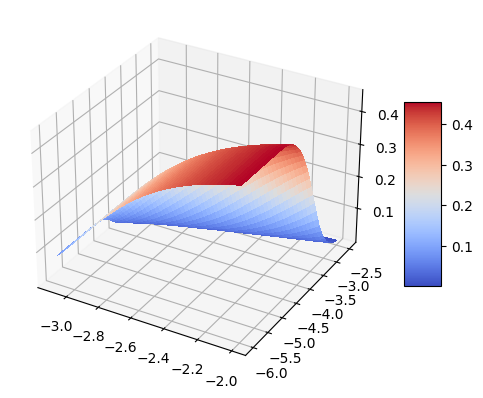

In [572]:

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X, Y = np.meshgrid(sigmas_u_list, sigmas_v_list)

# Plot the surface.
surf = ax.plot_surface(np.log10(X), np.log10(Y), data_sigmas_TP, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

PhD/Results/case/figures/TP_sweep_sigmas
PhD/Results/case/figures/IP_sweep_sigmas


((<Figure size 640x480 with 2 Axes>,
  <Axes: xlabel='$\\sigma_v$', ylabel='$\\sigma_u$'>),
 (<Figure size 640x480 with 2 Axes>,
  <Axes: xlabel='$\\sigma_v$', ylabel='$\\sigma_u$'>))

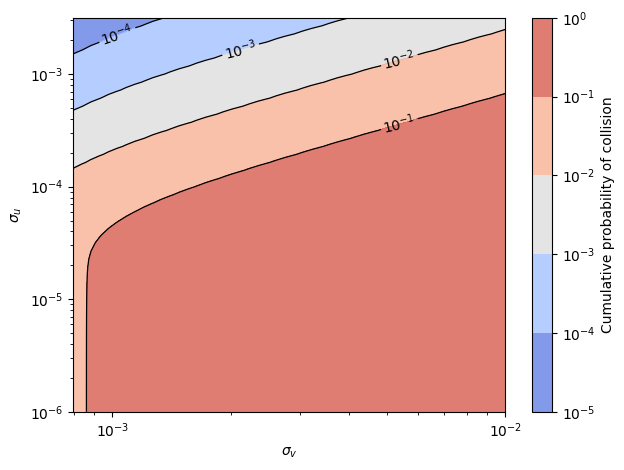

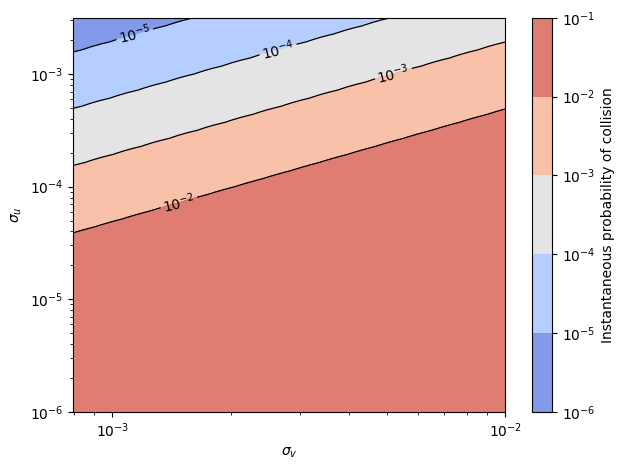

In [573]:
xlabel = r'$\sigma_u$'
ylabel = r'$\sigma_v$'
plot_double_contours(sigmas_u_list, sigmas_v_list, [data_sigmas_TP, data_sigmas_IP], True, True, True, save=True, xlabel=xlabel, ylabel=ylabel, figures_path=figures_path, tag='sweep_sigmas')

In [574]:
d_list = np.linspace(100, 1000, n)
D_list = np.linspace(5, 15, n)

data_d_IP = np.zeros((len(d_list), len(D_list)))
data_d_TP = np.zeros_like(data_d_IP)

parameter_name='N'
parameter_list = [100]

for i in range((len(d_list))):
    default_kwargs['d'] = d_list[i]
    print(i)
    for j in range(len(D_list)):
        default_kwargs['D'] = D_list[j]   
        df = analytic_sweep(default_kwargs, parameter_name, parameter_list)
        data_d_TP[i, j] = df.iloc[0]['TP'].max()
        data_d_IP[i, j] = df.iloc[0]['IP'].max()

0








100%|██████████| 1/1 [00:06<00:00,  6.79s/it]






100%|██████████| 1/1 [00:06<00:00,  6.84s/it]






100%|██████████| 1/1 [00:06<00:00,  6.81s/it]






100%|██████████| 1/1 [00:06<00:00,  6.82s/it]






100%|██████████| 1/1 [00:06<00:00,  6.83s/it]






100%|██████████| 1/1 [00:06<00:00,  6.82s/it]






100%|██████████| 1/1 [00:06<00:00,  6.79s/it]






100%|██████████| 1/1 [00:06<00:00,  6.81s/it]






100%|██████████| 1/1 [00:06<00:00,  6.83s/it]






100%|██████████| 1/1 [00:06<00:00,  6.82s/it]






100%|██████████| 1/1 [00:06<00:00,  6.82s/it]






100%|██████████| 1/1 [00:06<00:00,  6.84s/it]






100%|██████████| 1/1 [00:06<00:00,  6.85s/it]






100%|██████████| 1/1 [00:06<00:00,  6.80s/it]






100%|██████████| 1/1 [00:06<00:00,  6.84s/it]






100%|██████████| 1/1 [00:06<00:00,  6.80s/it]






100%|██████████| 1/1 [00:06<00:00,  6.85s/it]






100%|██████████| 1/1 [00:06<00:00,  6.82s/it]






100%|██████████| 1/1 [00:06<00:00,  6.86s/it]






100%|█

1








100%|██████████| 1/1 [00:06<00:00,  6.79s/it]






100%|██████████| 1/1 [00:06<00:00,  6.82s/it]






100%|██████████| 1/1 [00:06<00:00,  6.78s/it]






100%|██████████| 1/1 [00:06<00:00,  6.79s/it]






100%|██████████| 1/1 [00:06<00:00,  6.79s/it]






100%|██████████| 1/1 [00:06<00:00,  6.77s/it]






100%|██████████| 1/1 [00:06<00:00,  6.79s/it]






100%|██████████| 1/1 [00:06<00:00,  6.80s/it]






100%|██████████| 1/1 [00:06<00:00,  6.81s/it]






100%|██████████| 1/1 [00:06<00:00,  6.77s/it]






100%|██████████| 1/1 [00:06<00:00,  6.80s/it]






100%|██████████| 1/1 [00:06<00:00,  6.80s/it]






100%|██████████| 1/1 [00:06<00:00,  6.77s/it]






100%|██████████| 1/1 [00:06<00:00,  6.81s/it]






100%|██████████| 1/1 [00:06<00:00,  6.82s/it]






100%|██████████| 1/1 [00:06<00:00,  6.81s/it]






100%|██████████| 1/1 [00:06<00:00,  6.80s/it]






100%|██████████| 1/1 [00:06<00:00,  6.82s/it]






100%|██████████| 1/1 [00:06<00:00,  6.78s/it]






100%|█

2








100%|██████████| 1/1 [00:06<00:00,  6.81s/it]






100%|██████████| 1/1 [00:06<00:00,  6.78s/it]






100%|██████████| 1/1 [00:06<00:00,  6.79s/it]






100%|██████████| 1/1 [00:06<00:00,  6.81s/it]






100%|██████████| 1/1 [00:06<00:00,  6.79s/it]






100%|██████████| 1/1 [00:06<00:00,  6.77s/it]






100%|██████████| 1/1 [00:06<00:00,  6.77s/it]






100%|██████████| 1/1 [00:06<00:00,  6.79s/it]






100%|██████████| 1/1 [00:06<00:00,  6.82s/it]






100%|██████████| 1/1 [00:06<00:00,  6.79s/it]






100%|██████████| 1/1 [00:06<00:00,  6.76s/it]






100%|██████████| 1/1 [00:06<00:00,  6.78s/it]






100%|██████████| 1/1 [00:06<00:00,  6.77s/it]






100%|██████████| 1/1 [00:06<00:00,  6.81s/it]






100%|██████████| 1/1 [00:06<00:00,  6.77s/it]






100%|██████████| 1/1 [00:06<00:00,  6.79s/it]






100%|██████████| 1/1 [00:06<00:00,  6.76s/it]






100%|██████████| 1/1 [00:06<00:00,  6.78s/it]






100%|██████████| 1/1 [00:06<00:00,  6.79s/it]






100%|█

3








100%|██████████| 1/1 [00:06<00:00,  6.74s/it]






100%|██████████| 1/1 [00:06<00:00,  6.75s/it]






100%|██████████| 1/1 [00:06<00:00,  6.74s/it]






100%|██████████| 1/1 [00:06<00:00,  6.75s/it]






100%|██████████| 1/1 [00:06<00:00,  6.76s/it]






100%|██████████| 1/1 [00:06<00:00,  6.78s/it]






100%|██████████| 1/1 [00:06<00:00,  6.78s/it]






100%|██████████| 1/1 [00:06<00:00,  6.76s/it]






100%|██████████| 1/1 [00:06<00:00,  6.79s/it]






100%|██████████| 1/1 [00:06<00:00,  6.76s/it]






100%|██████████| 1/1 [00:06<00:00,  6.81s/it]






100%|██████████| 1/1 [00:06<00:00,  6.73s/it]






100%|██████████| 1/1 [00:06<00:00,  6.77s/it]






100%|██████████| 1/1 [00:06<00:00,  6.80s/it]






100%|██████████| 1/1 [00:06<00:00,  6.73s/it]






100%|██████████| 1/1 [00:06<00:00,  6.80s/it]






100%|██████████| 1/1 [00:06<00:00,  6.79s/it]






100%|██████████| 1/1 [00:06<00:00,  6.77s/it]






100%|██████████| 1/1 [00:06<00:00,  6.77s/it]






100%|█

4








100%|██████████| 1/1 [00:06<00:00,  6.70s/it]






100%|██████████| 1/1 [00:06<00:00,  6.78s/it]






100%|██████████| 1/1 [00:06<00:00,  6.71s/it]






100%|██████████| 1/1 [00:06<00:00,  6.76s/it]






100%|██████████| 1/1 [00:06<00:00,  6.73s/it]






100%|██████████| 1/1 [00:06<00:00,  6.73s/it]






100%|██████████| 1/1 [00:06<00:00,  6.71s/it]






100%|██████████| 1/1 [00:06<00:00,  6.76s/it]






100%|██████████| 1/1 [00:06<00:00,  6.74s/it]






100%|██████████| 1/1 [00:06<00:00,  6.73s/it]






100%|██████████| 1/1 [00:06<00:00,  6.77s/it]






100%|██████████| 1/1 [00:06<00:00,  6.76s/it]






100%|██████████| 1/1 [00:06<00:00,  6.76s/it]






100%|██████████| 1/1 [00:06<00:00,  6.79s/it]






100%|██████████| 1/1 [00:06<00:00,  6.73s/it]






100%|██████████| 1/1 [00:06<00:00,  6.76s/it]






100%|██████████| 1/1 [00:06<00:00,  6.73s/it]






100%|██████████| 1/1 [00:06<00:00,  6.74s/it]






100%|██████████| 1/1 [00:06<00:00,  6.75s/it]






100%|█

5








100%|██████████| 1/1 [00:06<00:00,  6.73s/it]






100%|██████████| 1/1 [00:06<00:00,  6.76s/it]






100%|██████████| 1/1 [00:06<00:00,  6.70s/it]






100%|██████████| 1/1 [00:06<00:00,  6.70s/it]






100%|██████████| 1/1 [00:06<00:00,  6.71s/it]






100%|██████████| 1/1 [00:06<00:00,  6.73s/it]






100%|██████████| 1/1 [00:06<00:00,  6.73s/it]






100%|██████████| 1/1 [00:06<00:00,  6.71s/it]






100%|██████████| 1/1 [00:06<00:00,  6.73s/it]






100%|██████████| 1/1 [00:06<00:00,  6.71s/it]






100%|██████████| 1/1 [00:06<00:00,  6.73s/it]






100%|██████████| 1/1 [00:06<00:00,  6.71s/it]






100%|██████████| 1/1 [00:06<00:00,  6.73s/it]






100%|██████████| 1/1 [00:06<00:00,  6.73s/it]






100%|██████████| 1/1 [00:06<00:00,  6.73s/it]






100%|██████████| 1/1 [00:06<00:00,  6.76s/it]






100%|██████████| 1/1 [00:06<00:00,  6.74s/it]






100%|██████████| 1/1 [00:06<00:00,  6.75s/it]






100%|██████████| 1/1 [00:06<00:00,  6.71s/it]






100%|█

6








100%|██████████| 1/1 [00:06<00:00,  6.71s/it]






100%|██████████| 1/1 [00:06<00:00,  6.71s/it]






100%|██████████| 1/1 [00:06<00:00,  6.71s/it]






100%|██████████| 1/1 [00:06<00:00,  6.72s/it]






100%|██████████| 1/1 [00:06<00:00,  6.73s/it]






100%|██████████| 1/1 [00:06<00:00,  6.72s/it]






100%|██████████| 1/1 [00:06<00:00,  6.72s/it]






100%|██████████| 1/1 [00:06<00:00,  6.73s/it]






100%|██████████| 1/1 [00:06<00:00,  6.72s/it]






100%|██████████| 1/1 [00:06<00:00,  6.71s/it]






100%|██████████| 1/1 [00:06<00:00,  6.73s/it]






100%|██████████| 1/1 [00:06<00:00,  6.72s/it]






100%|██████████| 1/1 [00:06<00:00,  6.69s/it]






100%|██████████| 1/1 [00:06<00:00,  6.73s/it]






100%|██████████| 1/1 [00:06<00:00,  6.69s/it]






100%|██████████| 1/1 [00:06<00:00,  6.73s/it]






100%|██████████| 1/1 [00:06<00:00,  6.70s/it]






100%|██████████| 1/1 [00:06<00:00,  6.72s/it]






100%|██████████| 1/1 [00:06<00:00,  6.73s/it]






100%|█

7








100%|██████████| 1/1 [00:06<00:00,  6.70s/it]






100%|██████████| 1/1 [00:06<00:00,  6.71s/it]






100%|██████████| 1/1 [00:06<00:00,  6.69s/it]






100%|██████████| 1/1 [00:06<00:00,  6.72s/it]






100%|██████████| 1/1 [00:06<00:00,  6.68s/it]






100%|██████████| 1/1 [00:06<00:00,  6.70s/it]






100%|██████████| 1/1 [00:06<00:00,  6.69s/it]






100%|██████████| 1/1 [00:06<00:00,  6.72s/it]






100%|██████████| 1/1 [00:06<00:00,  6.71s/it]






100%|██████████| 1/1 [00:06<00:00,  6.71s/it]






100%|██████████| 1/1 [00:06<00:00,  6.69s/it]






100%|██████████| 1/1 [00:06<00:00,  6.72s/it]






100%|██████████| 1/1 [00:06<00:00,  6.71s/it]






100%|██████████| 1/1 [00:06<00:00,  6.71s/it]






100%|██████████| 1/1 [00:06<00:00,  6.68s/it]






100%|██████████| 1/1 [00:06<00:00,  6.71s/it]






100%|██████████| 1/1 [00:06<00:00,  6.70s/it]






100%|██████████| 1/1 [00:06<00:00,  6.70s/it]






100%|██████████| 1/1 [00:06<00:00,  6.72s/it]






100%|█

8








100%|██████████| 1/1 [00:06<00:00,  6.69s/it]






100%|██████████| 1/1 [00:06<00:00,  6.70s/it]






100%|██████████| 1/1 [00:06<00:00,  6.72s/it]






100%|██████████| 1/1 [00:06<00:00,  6.70s/it]






100%|██████████| 1/1 [00:06<00:00,  6.69s/it]






100%|██████████| 1/1 [00:06<00:00,  6.67s/it]






100%|██████████| 1/1 [00:06<00:00,  6.75s/it]






100%|██████████| 1/1 [00:06<00:00,  6.69s/it]






100%|██████████| 1/1 [00:06<00:00,  6.69s/it]






100%|██████████| 1/1 [00:06<00:00,  6.70s/it]






100%|██████████| 1/1 [00:06<00:00,  6.70s/it]






100%|██████████| 1/1 [00:06<00:00,  6.71s/it]






100%|██████████| 1/1 [00:06<00:00,  6.66s/it]






100%|██████████| 1/1 [00:06<00:00,  6.64s/it]






100%|██████████| 1/1 [00:06<00:00,  6.69s/it]






100%|██████████| 1/1 [00:06<00:00,  6.67s/it]






100%|██████████| 1/1 [00:06<00:00,  6.70s/it]






100%|██████████| 1/1 [00:06<00:00,  6.71s/it]






100%|██████████| 1/1 [00:06<00:00,  6.65s/it]






100%|█

9








100%|██████████| 1/1 [00:06<00:00,  6.70s/it]






100%|██████████| 1/1 [00:06<00:00,  6.67s/it]






100%|██████████| 1/1 [00:06<00:00,  6.67s/it]






100%|██████████| 1/1 [00:06<00:00,  6.66s/it]






100%|██████████| 1/1 [00:06<00:00,  6.68s/it]






100%|██████████| 1/1 [00:06<00:00,  6.68s/it]






100%|██████████| 1/1 [00:06<00:00,  6.69s/it]






100%|██████████| 1/1 [00:06<00:00,  6.64s/it]






100%|██████████| 1/1 [00:06<00:00,  6.69s/it]






100%|██████████| 1/1 [00:06<00:00,  6.68s/it]






100%|██████████| 1/1 [00:06<00:00,  6.67s/it]






100%|██████████| 1/1 [00:06<00:00,  6.67s/it]






100%|██████████| 1/1 [00:06<00:00,  6.69s/it]






100%|██████████| 1/1 [00:06<00:00,  6.69s/it]






100%|██████████| 1/1 [00:06<00:00,  6.66s/it]






100%|██████████| 1/1 [00:06<00:00,  6.70s/it]






100%|██████████| 1/1 [00:06<00:00,  6.64s/it]






100%|██████████| 1/1 [00:06<00:00,  6.68s/it]






100%|██████████| 1/1 [00:06<00:00,  6.66s/it]






100%|█

10








100%|██████████| 1/1 [00:06<00:00,  6.64s/it]






100%|██████████| 1/1 [00:06<00:00,  6.65s/it]






100%|██████████| 1/1 [00:06<00:00,  6.66s/it]






100%|██████████| 1/1 [00:06<00:00,  6.66s/it]






100%|██████████| 1/1 [00:06<00:00,  6.68s/it]






100%|██████████| 1/1 [00:06<00:00,  6.66s/it]






100%|██████████| 1/1 [00:06<00:00,  6.66s/it]






100%|██████████| 1/1 [00:06<00:00,  6.66s/it]






100%|██████████| 1/1 [00:06<00:00,  6.64s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|██████████| 1/1 [00:06<00:00,  6.65s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|██████████| 1/1 [00:06<00:00,  6.66s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|██████████| 1/1 [00:06<00:00,  6.65s/it]






100%|██████████| 1/1 [00:06<00:00,  6.68s/it]






100%|██████████| 1/1 [00:06<00:00,  6.69s/it]






100%|██████████| 1/1 [00:06<00:00,  6.68s/it]






100%|██████████| 1/1 [00:06<00:00,  6.64s/it]






100%|█

11








100%|██████████| 1/1 [00:06<00:00,  6.62s/it]






100%|██████████| 1/1 [00:06<00:00,  6.61s/it]






100%|██████████| 1/1 [00:06<00:00,  6.66s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|██████████| 1/1 [00:06<00:00,  6.64s/it]






100%|██████████| 1/1 [00:06<00:00,  6.64s/it]






100%|██████████| 1/1 [00:06<00:00,  6.64s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|██████████| 1/1 [00:06<00:00,  6.65s/it]






100%|██████████| 1/1 [00:06<00:00,  6.64s/it]






100%|██████████| 1/1 [00:06<00:00,  6.68s/it]






100%|██████████| 1/1 [00:06<00:00,  6.64s/it]






100%|██████████| 1/1 [00:06<00:00,  6.64s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|█

12








100%|██████████| 1/1 [00:06<00:00,  6.62s/it]






100%|██████████| 1/1 [00:06<00:00,  6.62s/it]






100%|██████████| 1/1 [00:06<00:00,  6.61s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|██████████| 1/1 [00:06<00:00,  6.64s/it]






100%|██████████| 1/1 [00:06<00:00,  6.64s/it]






100%|██████████| 1/1 [00:06<00:00,  6.61s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|██████████| 1/1 [00:06<00:00,  6.60s/it]






100%|██████████| 1/1 [00:06<00:00,  6.65s/it]






100%|██████████| 1/1 [00:06<00:00,  6.62s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|██████████| 1/1 [00:06<00:00,  6.60s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|██████████| 1/1 [00:06<00:00,  6.62s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|█

13








100%|██████████| 1/1 [00:06<00:00,  6.59s/it]






100%|██████████| 1/1 [00:06<00:00,  6.60s/it]






100%|██████████| 1/1 [00:06<00:00,  6.58s/it]






100%|██████████| 1/1 [00:06<00:00,  6.57s/it]






100%|██████████| 1/1 [00:06<00:00,  6.62s/it]






100%|██████████| 1/1 [00:06<00:00,  6.62s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|██████████| 1/1 [00:06<00:00,  6.61s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|██████████| 1/1 [00:06<00:00,  6.60s/it]






100%|██████████| 1/1 [00:06<00:00,  6.62s/it]






100%|██████████| 1/1 [00:06<00:00,  6.60s/it]






100%|██████████| 1/1 [00:06<00:00,  6.61s/it]






100%|██████████| 1/1 [00:06<00:00,  6.61s/it]






100%|██████████| 1/1 [00:06<00:00,  6.59s/it]






100%|██████████| 1/1 [00:06<00:00,  6.61s/it]






100%|██████████| 1/1 [00:06<00:00,  6.58s/it]






100%|██████████| 1/1 [00:06<00:00,  6.58s/it]






100%|█

14








100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.63s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.58s/it]






100%|██████████| 1/1 [00:06<00:00,  6.59s/it]






100%|██████████| 1/1 [00:06<00:00,  6.58s/it]






100%|██████████| 1/1 [00:06<00:00,  6.57s/it]






100%|██████████| 1/1 [00:06<00:00,  6.60s/it]






100%|██████████| 1/1 [00:06<00:00,  6.60s/it]






100%|██████████| 1/1 [00:06<00:00,  6.60s/it]






100%|██████████| 1/1 [00:06<00:00,  6.58s/it]






100%|██████████| 1/1 [00:06<00:00,  6.60s/it]






100%|██████████| 1/1 [00:06<00:00,  6.61s/it]






100%|██████████| 1/1 [00:06<00:00,  6.57s/it]






100%|██████████| 1/1 [00:06<00:00,  6.60s/it]






100%|██████████| 1/1 [00:06<00:00,  6.60s/it]






100%|██████████| 1/1 [00:06<00:00,  6.62s/it]






100%|██████████| 1/1 [00:06<00:00,  6.59s/it]






100%|██████████| 1/1 [00:06<00:00,  6.58s/it]






100%|█

15








100%|██████████| 1/1 [00:06<00:00,  6.56s/it]






100%|██████████| 1/1 [00:06<00:00,  6.57s/it]






100%|██████████| 1/1 [00:06<00:00,  6.55s/it]






100%|██████████| 1/1 [00:06<00:00,  6.56s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.59s/it]






100%|██████████| 1/1 [00:06<00:00,  6.55s/it]






100%|██████████| 1/1 [00:06<00:00,  6.57s/it]






100%|██████████| 1/1 [00:06<00:00,  6.57s/it]






100%|██████████| 1/1 [00:06<00:00,  6.58s/it]






100%|██████████| 1/1 [00:06<00:00,  6.57s/it]






100%|██████████| 1/1 [00:06<00:00,  6.58s/it]






100%|██████████| 1/1 [00:06<00:00,  6.57s/it]






100%|██████████| 1/1 [00:06<00:00,  6.57s/it]






100%|██████████| 1/1 [00:06<00:00,  6.56s/it]






100%|██████████| 1/1 [00:06<00:00,  6.58s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.58s/it]






100%|██████████| 1/1 [00:06<00:00,  6.57s/it]






100%|█

16








100%|██████████| 1/1 [00:06<00:00,  6.55s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.52s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.57s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.56s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.56s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.53s/it]






100%|██████████| 1/1 [00:06<00:00,  6.59s/it]






100%|██████████| 1/1 [00:06<00:00,  6.55s/it]






100%|██████████| 1/1 [00:06<00:00,  6.59s/it]






100%|██████████| 1/1 [00:06<00:00,  6.57s/it]






100%|██████████| 1/1 [00:06<00:00,  6.59s/it]






100%|█

17








100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.56s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.56s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.56s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.52s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.55s/it]






100%|██████████| 1/1 [00:06<00:00,  6.57s/it]






100%|██████████| 1/1 [00:06<00:00,  6.56s/it]






100%|██████████| 1/1 [00:06<00:00,  6.55s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.56s/it]






100%|██████████| 1/1 [00:06<00:00,  6.56s/it]






100%|█

18








100%|██████████| 1/1 [00:06<00:00,  6.49s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.53s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.48s/it]






100%|██████████| 1/1 [00:06<00:00,  6.52s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.53s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.52s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.55s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.52s/it]






100%|██████████| 1/1 [00:06<00:00,  6.56s/it]






100%|█

19








100%|██████████| 1/1 [00:06<00:00,  6.46s/it]






100%|██████████| 1/1 [00:06<00:00,  6.46s/it]






100%|██████████| 1/1 [00:06<00:00,  6.50s/it]






100%|██████████| 1/1 [00:06<00:00,  6.50s/it]






100%|██████████| 1/1 [00:06<00:00,  6.50s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.50s/it]






100%|██████████| 1/1 [00:06<00:00,  6.53s/it]






100%|██████████| 1/1 [00:06<00:00,  6.47s/it]






100%|██████████| 1/1 [00:06<00:00,  6.50s/it]






100%|██████████| 1/1 [00:06<00:00,  6.50s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.50s/it]






100%|██████████| 1/1 [00:06<00:00,  6.52s/it]






100%|██████████| 1/1 [00:06<00:00,  6.50s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.54s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|█

20








100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.47s/it]






100%|██████████| 1/1 [00:06<00:00,  6.50s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.49s/it]






100%|██████████| 1/1 [00:06<00:00,  6.50s/it]






100%|██████████| 1/1 [00:06<00:00,  6.48s/it]






100%|██████████| 1/1 [00:06<00:00,  6.50s/it]






100%|██████████| 1/1 [00:06<00:00,  6.48s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.49s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.50s/it]






100%|██████████| 1/1 [00:06<00:00,  6.49s/it]






100%|██████████| 1/1 [00:06<00:00,  6.47s/it]






100%|██████████| 1/1 [00:06<00:00,  6.47s/it]






100%|██████████| 1/1 [00:06<00:00,  6.50s/it]






100%|██████████| 1/1 [00:06<00:00,  6.52s/it]






100%|█

21








100%|██████████| 1/1 [00:06<00:00,  6.46s/it]






100%|██████████| 1/1 [00:06<00:00,  6.45s/it]






100%|██████████| 1/1 [00:06<00:00,  6.48s/it]






100%|██████████| 1/1 [00:06<00:00,  6.47s/it]






100%|██████████| 1/1 [00:06<00:00,  6.50s/it]






100%|██████████| 1/1 [00:06<00:00,  6.45s/it]






100%|██████████| 1/1 [00:06<00:00,  6.46s/it]






100%|██████████| 1/1 [00:06<00:00,  6.43s/it]






100%|██████████| 1/1 [00:06<00:00,  6.47s/it]






100%|██████████| 1/1 [00:06<00:00,  6.45s/it]






100%|██████████| 1/1 [00:06<00:00,  6.49s/it]






100%|██████████| 1/1 [00:06<00:00,  6.44s/it]






100%|██████████| 1/1 [00:06<00:00,  6.48s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:06<00:00,  6.44s/it]






100%|██████████| 1/1 [00:06<00:00,  6.50s/it]






100%|██████████| 1/1 [00:06<00:00,  6.48s/it]






100%|██████████| 1/1 [00:06<00:00,  6.50s/it]






100%|██████████| 1/1 [00:06<00:00,  6.48s/it]






100%|█

22








100%|██████████| 1/1 [00:06<00:00,  6.44s/it]






100%|██████████| 1/1 [00:06<00:00,  6.43s/it]






100%|██████████| 1/1 [00:06<00:00,  6.44s/it]






100%|██████████| 1/1 [00:06<00:00,  6.45s/it]






100%|██████████| 1/1 [00:06<00:00,  6.44s/it]






100%|██████████| 1/1 [00:06<00:00,  6.45s/it]






100%|██████████| 1/1 [00:06<00:00,  6.46s/it]






100%|██████████| 1/1 [00:06<00:00,  6.46s/it]






100%|██████████| 1/1 [00:06<00:00,  6.46s/it]






100%|██████████| 1/1 [00:06<00:00,  6.47s/it]






100%|██████████| 1/1 [00:06<00:00,  6.45s/it]






100%|██████████| 1/1 [00:06<00:00,  6.46s/it]






100%|██████████| 1/1 [00:06<00:00,  6.47s/it]






100%|██████████| 1/1 [00:06<00:00,  6.47s/it]






100%|██████████| 1/1 [00:06<00:00,  6.47s/it]






100%|██████████| 1/1 [00:06<00:00,  6.48s/it]






100%|██████████| 1/1 [00:06<00:00,  6.47s/it]






100%|██████████| 1/1 [00:06<00:00,  6.46s/it]






100%|██████████| 1/1 [00:06<00:00,  6.50s/it]






100%|█

23








100%|██████████| 1/1 [00:06<00:00,  6.42s/it]






100%|██████████| 1/1 [00:06<00:00,  6.40s/it]






100%|██████████| 1/1 [00:06<00:00,  6.43s/it]






100%|██████████| 1/1 [00:06<00:00,  6.43s/it]






100%|██████████| 1/1 [00:06<00:00,  6.42s/it]






100%|██████████| 1/1 [00:06<00:00,  6.44s/it]






100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|██████████| 1/1 [00:06<00:00,  6.44s/it]






100%|██████████| 1/1 [00:06<00:00,  6.44s/it]






100%|██████████| 1/1 [00:06<00:00,  6.44s/it]






100%|██████████| 1/1 [00:06<00:00,  6.44s/it]






100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|██████████| 1/1 [00:06<00:00,  6.44s/it]






100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|██████████| 1/1 [00:06<00:00,  6.45s/it]






100%|██████████| 1/1 [00:06<00:00,  6.44s/it]






100%|██████████| 1/1 [00:06<00:00,  6.45s/it]






100%|██████████| 1/1 [00:06<00:00,  6.42s/it]






100%|██████████| 1/1 [00:06<00:00,  6.47s/it]






100%|█

24








100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|██████████| 1/1 [00:06<00:00,  6.40s/it]






100%|██████████| 1/1 [00:06<00:00,  6.45s/it]






100%|██████████| 1/1 [00:06<00:00,  6.39s/it]






100%|██████████| 1/1 [00:06<00:00,  6.42s/it]






100%|██████████| 1/1 [00:06<00:00,  6.39s/it]






100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|██████████| 1/1 [00:06<00:00,  6.43s/it]






100%|██████████| 1/1 [00:06<00:00,  6.44s/it]






100%|██████████| 1/1 [00:06<00:00,  6.38s/it]






100%|██████████| 1/1 [00:06<00:00,  6.43s/it]






100%|██████████| 1/1 [00:06<00:00,  6.42s/it]






100%|██████████| 1/1 [00:06<00:00,  6.43s/it]






100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|██████████| 1/1 [00:06<00:00,  6.43s/it]






100%|██████████| 1/1 [00:06<00:00,  6.42s/it]






100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|██████████| 1/1 [00:06<00:00,  6.42s/it]






100%|█

25








100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|██████████| 1/1 [00:06<00:00,  6.37s/it]






100%|██████████| 1/1 [00:06<00:00,  6.42s/it]






100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|██████████| 1/1 [00:06<00:00,  6.38s/it]






100%|██████████| 1/1 [00:06<00:00,  6.42s/it]






100%|██████████| 1/1 [00:06<00:00,  6.38s/it]






100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|██████████| 1/1 [00:06<00:00,  6.43s/it]






100%|██████████| 1/1 [00:06<00:00,  6.42s/it]






100%|██████████| 1/1 [00:06<00:00,  6.45s/it]






100%|██████████| 1/1 [00:06<00:00,  6.38s/it]






100%|██████████| 1/1 [00:06<00:00,  6.44s/it]






100%|██████████| 1/1 [00:06<00:00,  6.44s/it]






100%|██████████| 1/1 [00:06<00:00,  6.42s/it]






100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|█

26








100%|██████████| 1/1 [00:06<00:00,  6.37s/it]






100%|██████████| 1/1 [00:06<00:00,  6.38s/it]






100%|██████████| 1/1 [00:06<00:00,  6.40s/it]






100%|██████████| 1/1 [00:06<00:00,  6.36s/it]






100%|██████████| 1/1 [00:06<00:00,  6.40s/it]






100%|██████████| 1/1 [00:06<00:00,  6.37s/it]






100%|██████████| 1/1 [00:06<00:00,  6.41s/it]






100%|██████████| 1/1 [00:06<00:00,  6.40s/it]






100%|██████████| 1/1 [00:06<00:00,  6.39s/it]






100%|██████████| 1/1 [00:06<00:00,  6.39s/it]






100%|██████████| 1/1 [00:06<00:00,  6.35s/it]






100%|██████████| 1/1 [00:06<00:00,  6.40s/it]






100%|██████████| 1/1 [00:06<00:00,  6.39s/it]






100%|██████████| 1/1 [00:06<00:00,  6.39s/it]






100%|██████████| 1/1 [00:06<00:00,  6.44s/it]






100%|██████████| 1/1 [00:06<00:00,  6.39s/it]






100%|██████████| 1/1 [00:06<00:00,  6.40s/it]






100%|██████████| 1/1 [00:06<00:00,  6.37s/it]






100%|██████████| 1/1 [00:06<00:00,  6.42s/it]






100%|█

27








100%|██████████| 1/1 [00:06<00:00,  6.35s/it]






100%|██████████| 1/1 [00:06<00:00,  6.38s/it]






100%|██████████| 1/1 [00:06<00:00,  6.38s/it]






100%|██████████| 1/1 [00:06<00:00,  6.39s/it]






100%|██████████| 1/1 [00:06<00:00,  6.37s/it]






100%|██████████| 1/1 [00:06<00:00,  6.35s/it]






100%|██████████| 1/1 [00:06<00:00,  6.38s/it]






100%|██████████| 1/1 [00:06<00:00,  6.36s/it]






100%|██████████| 1/1 [00:06<00:00,  6.39s/it]






100%|██████████| 1/1 [00:06<00:00,  6.37s/it]






100%|██████████| 1/1 [00:06<00:00,  6.40s/it]






100%|██████████| 1/1 [00:06<00:00,  6.38s/it]






100%|██████████| 1/1 [00:06<00:00,  6.42s/it]






100%|██████████| 1/1 [00:06<00:00,  6.38s/it]






100%|██████████| 1/1 [00:06<00:00,  6.40s/it]






100%|██████████| 1/1 [00:06<00:00,  6.38s/it]






100%|██████████| 1/1 [00:06<00:00,  6.38s/it]






100%|██████████| 1/1 [00:06<00:00,  6.40s/it]






100%|██████████| 1/1 [00:06<00:00,  6.39s/it]






100%|█

28








100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.36s/it]






100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.35s/it]






100%|██████████| 1/1 [00:06<00:00,  6.35s/it]






100%|██████████| 1/1 [00:06<00:00,  6.35s/it]






100%|██████████| 1/1 [00:06<00:00,  6.37s/it]






100%|██████████| 1/1 [00:06<00:00,  6.37s/it]






100%|██████████| 1/1 [00:06<00:00,  6.32s/it]






100%|██████████| 1/1 [00:06<00:00,  6.33s/it]






100%|██████████| 1/1 [00:06<00:00,  6.36s/it]






100%|██████████| 1/1 [00:06<00:00,  6.38s/it]






100%|██████████| 1/1 [00:06<00:00,  6.39s/it]






100%|██████████| 1/1 [00:06<00:00,  6.38s/it]






100%|██████████| 1/1 [00:06<00:00,  6.36s/it]






100%|██████████| 1/1 [00:06<00:00,  6.40s/it]






100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.38s/it]






100%|██████████| 1/1 [00:06<00:00,  6.35s/it]






100%|█

29








100%|██████████| 1/1 [00:06<00:00,  6.36s/it]






100%|██████████| 1/1 [00:06<00:00,  6.35s/it]






100%|██████████| 1/1 [00:06<00:00,  6.35s/it]






100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.35s/it]






100%|██████████| 1/1 [00:06<00:00,  6.32s/it]






100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.32s/it]






100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.33s/it]






100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.37s/it]






100%|██████████| 1/1 [00:06<00:00,  6.35s/it]






100%|██████████| 1/1 [00:06<00:00,  6.36s/it]






100%|██████████| 1/1 [00:06<00:00,  6.38s/it]






100%|██████████| 1/1 [00:06<00:00,  6.32s/it]






100%|██████████| 1/1 [00:06<00:00,  6.37s/it]






100%|██████████| 1/1 [00:06<00:00,  6.37s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|█

30








100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.33s/it]






100%|██████████| 1/1 [00:06<00:00,  6.32s/it]






100%|██████████| 1/1 [00:06<00:00,  6.32s/it]






100%|██████████| 1/1 [00:06<00:00,  6.35s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.36s/it]






100%|██████████| 1/1 [00:06<00:00,  6.32s/it]






100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.30s/it]






100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.32s/it]






100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.32s/it]






100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.33s/it]






100%|██████████| 1/1 [00:06<00:00,  6.36s/it]






100%|█

31








100%|██████████| 1/1 [00:06<00:00,  6.32s/it]






100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.30s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.30s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.33s/it]






100%|██████████| 1/1 [00:06<00:00,  6.30s/it]






100%|██████████| 1/1 [00:06<00:00,  6.37s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.32s/it]






100%|██████████| 1/1 [00:06<00:00,  6.33s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|█

32








100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.29s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.29s/it]






100%|██████████| 1/1 [00:06<00:00,  6.30s/it]






100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.30s/it]






100%|██████████| 1/1 [00:06<00:00,  6.29s/it]






100%|██████████| 1/1 [00:06<00:00,  6.32s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.30s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.29s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.30s/it]






100%|██████████| 1/1 [00:06<00:00,  6.30s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|█

33








100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.29s/it]






100%|██████████| 1/1 [00:06<00:00,  6.29s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.29s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.26s/it]






100%|██████████| 1/1 [00:06<00:00,  6.29s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.29s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.29s/it]






100%|█

34








100%|██████████| 1/1 [00:06<00:00,  6.29s/it]






100%|██████████| 1/1 [00:06<00:00,  6.24s/it]






100%|██████████| 1/1 [00:06<00:00,  6.23s/it]






100%|██████████| 1/1 [00:06<00:00,  6.30s/it]






100%|██████████| 1/1 [00:06<00:00,  6.26s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.26s/it]






100%|██████████| 1/1 [00:06<00:00,  6.30s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.27s/it]






100%|██████████| 1/1 [00:06<00:00,  6.29s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.27s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.27s/it]






100%|██████████| 1/1 [00:06<00:00,  6.27s/it]






100%|█

35








100%|██████████| 1/1 [00:06<00:00,  6.26s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.24s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.26s/it]






100%|██████████| 1/1 [00:06<00:00,  6.27s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.26s/it]






100%|██████████| 1/1 [00:06<00:00,  6.27s/it]






100%|██████████| 1/1 [00:06<00:00,  6.24s/it]






100%|██████████| 1/1 [00:06<00:00,  6.26s/it]






100%|██████████| 1/1 [00:06<00:00,  6.26s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.26s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.27s/it]






100%|█

36








100%|██████████| 1/1 [00:06<00:00,  6.24s/it]






100%|██████████| 1/1 [00:06<00:00,  6.21s/it]






100%|██████████| 1/1 [00:06<00:00,  6.24s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.23s/it]






100%|██████████| 1/1 [00:06<00:00,  6.23s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.26s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.26s/it]






100%|██████████| 1/1 [00:06<00:00,  6.21s/it]






100%|█

37








100%|██████████| 1/1 [00:06<00:00,  6.20s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.20s/it]






100%|██████████| 1/1 [00:06<00:00,  6.20s/it]






100%|██████████| 1/1 [00:06<00:00,  6.21s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.24s/it]






100%|██████████| 1/1 [00:06<00:00,  6.23s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.24s/it]






100%|██████████| 1/1 [00:06<00:00,  6.20s/it]






100%|██████████| 1/1 [00:06<00:00,  6.24s/it]






100%|██████████| 1/1 [00:06<00:00,  6.24s/it]






100%|██████████| 1/1 [00:06<00:00,  6.23s/it]






100%|██████████| 1/1 [00:06<00:00,  6.21s/it]






100%|█

38








100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.20s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.21s/it]






100%|██████████| 1/1 [00:06<00:00,  6.21s/it]






100%|██████████| 1/1 [00:06<00:00,  6.21s/it]






100%|██████████| 1/1 [00:06<00:00,  6.20s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.21s/it]






100%|██████████| 1/1 [00:06<00:00,  6.21s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.23s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.20s/it]






100%|██████████| 1/1 [00:06<00:00,  6.24s/it]






100%|█

39








100%|██████████| 1/1 [00:06<00:00,  6.17s/it]






100%|██████████| 1/1 [00:06<00:00,  6.13s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.15s/it]






100%|██████████| 1/1 [00:06<00:00,  6.16s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.17s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.21s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.21s/it]






100%|██████████| 1/1 [00:06<00:00,  6.18s/it]






100%|██████████| 1/1 [00:06<00:00,  6.18s/it]






100%|██████████| 1/1 [00:06<00:00,  6.18s/it]






100%|██████████| 1/1 [00:06<00:00,  6.18s/it]






100%|██████████| 1/1 [00:06<00:00,  6.21s/it]






100%|█

40








100%|██████████| 1/1 [00:06<00:00,  6.16s/it]






100%|██████████| 1/1 [00:06<00:00,  6.11s/it]






100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.16s/it]






100%|██████████| 1/1 [00:06<00:00,  6.13s/it]






100%|██████████| 1/1 [00:06<00:00,  6.15s/it]






100%|██████████| 1/1 [00:06<00:00,  6.15s/it]






100%|██████████| 1/1 [00:06<00:00,  6.15s/it]






100%|██████████| 1/1 [00:06<00:00,  6.15s/it]






100%|██████████| 1/1 [00:06<00:00,  6.16s/it]






100%|██████████| 1/1 [00:06<00:00,  6.16s/it]






100%|██████████| 1/1 [00:06<00:00,  6.20s/it]






100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.16s/it]






100%|██████████| 1/1 [00:06<00:00,  6.21s/it]






100%|██████████| 1/1 [00:06<00:00,  6.17s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.18s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|█

41








100%|██████████| 1/1 [00:06<00:00,  6.15s/it]






100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.15s/it]






100%|██████████| 1/1 [00:06<00:00,  6.15s/it]






100%|██████████| 1/1 [00:06<00:00,  6.16s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.15s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.13s/it]






100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.16s/it]






100%|██████████| 1/1 [00:06<00:00,  6.15s/it]






100%|██████████| 1/1 [00:06<00:00,  6.17s/it]






100%|██████████| 1/1 [00:06<00:00,  6.16s/it]






100%|██████████| 1/1 [00:06<00:00,  6.16s/it]






100%|██████████| 1/1 [00:06<00:00,  6.18s/it]






100%|██████████| 1/1 [00:06<00:00,  6.15s/it]






100%|██████████| 1/1 [00:06<00:00,  6.18s/it]






100%|█

42








100%|██████████| 1/1 [00:06<00:00,  6.15s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.13s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.11s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.13s/it]






100%|██████████| 1/1 [00:06<00:00,  6.15s/it]






100%|██████████| 1/1 [00:06<00:00,  6.16s/it]






100%|██████████| 1/1 [00:06<00:00,  6.11s/it]






100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.13s/it]






100%|██████████| 1/1 [00:06<00:00,  6.15s/it]






100%|█

43








100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.13s/it]






100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.13s/it]






100%|██████████| 1/1 [00:06<00:00,  6.10s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.13s/it]






100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.13s/it]






100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.15s/it]






100%|██████████| 1/1 [00:06<00:00,  6.13s/it]






100%|█

44








100%|██████████| 1/1 [00:06<00:00,  6.11s/it]






100%|██████████| 1/1 [00:06<00:00,  6.11s/it]






100%|██████████| 1/1 [00:06<00:00,  6.08s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.11s/it]






100%|██████████| 1/1 [00:06<00:00,  6.13s/it]






100%|██████████| 1/1 [00:06<00:00,  6.09s/it]






100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.08s/it]






100%|██████████| 1/1 [00:06<00:00,  6.10s/it]






100%|██████████| 1/1 [00:06<00:00,  6.09s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.08s/it]






100%|██████████| 1/1 [00:06<00:00,  6.11s/it]






100%|██████████| 1/1 [00:06<00:00,  6.08s/it]






100%|██████████| 1/1 [00:06<00:00,  6.11s/it]






100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.11s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|█

45








100%|██████████| 1/1 [00:06<00:00,  6.10s/it]






100%|██████████| 1/1 [00:06<00:00,  6.09s/it]






100%|██████████| 1/1 [00:06<00:00,  6.09s/it]






100%|██████████| 1/1 [00:06<00:00,  6.05s/it]






100%|██████████| 1/1 [00:06<00:00,  6.09s/it]






100%|██████████| 1/1 [00:06<00:00,  6.09s/it]






100%|██████████| 1/1 [00:06<00:00,  6.08s/it]






100%|██████████| 1/1 [00:06<00:00,  6.04s/it]






100%|██████████| 1/1 [00:06<00:00,  6.09s/it]






100%|██████████| 1/1 [00:06<00:00,  6.07s/it]






100%|██████████| 1/1 [00:06<00:00,  6.10s/it]






100%|██████████| 1/1 [00:06<00:00,  6.05s/it]






100%|██████████| 1/1 [00:06<00:00,  6.08s/it]






100%|██████████| 1/1 [00:06<00:00,  6.10s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.09s/it]






100%|██████████| 1/1 [00:06<00:00,  6.08s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.09s/it]






100%|█

46








100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.08s/it]






100%|██████████| 1/1 [00:06<00:00,  6.07s/it]






100%|██████████| 1/1 [00:06<00:00,  6.08s/it]






100%|██████████| 1/1 [00:06<00:00,  6.08s/it]






100%|██████████| 1/1 [00:06<00:00,  6.07s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.07s/it]






100%|██████████| 1/1 [00:06<00:00,  6.07s/it]






100%|██████████| 1/1 [00:06<00:00,  6.11s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.08s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.04s/it]






100%|██████████| 1/1 [00:06<00:00,  6.07s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.08s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|█

47








100%|██████████| 1/1 [00:06<00:00,  6.05s/it]






100%|██████████| 1/1 [00:06<00:00,  6.04s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.03s/it]






100%|██████████| 1/1 [00:06<00:00,  6.03s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.04s/it]






100%|██████████| 1/1 [00:06<00:00,  6.08s/it]






100%|██████████| 1/1 [00:06<00:00,  6.04s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.05s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.04s/it]






100%|██████████| 1/1 [00:06<00:00,  6.08s/it]






100%|██████████| 1/1 [00:06<00:00,  6.05s/it]






100%|██████████| 1/1 [00:06<00:00,  6.08s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.09s/it]






100%|█

48








100%|██████████| 1/1 [00:06<00:00,  6.02s/it]






100%|██████████| 1/1 [00:06<00:00,  6.04s/it]






100%|██████████| 1/1 [00:06<00:00,  6.03s/it]






100%|██████████| 1/1 [00:06<00:00,  6.05s/it]






100%|██████████| 1/1 [00:06<00:00,  6.01s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.04s/it]






100%|██████████| 1/1 [00:06<00:00,  6.03s/it]






100%|██████████| 1/1 [00:06<00:00,  6.03s/it]






100%|██████████| 1/1 [00:06<00:00,  6.03s/it]






100%|██████████| 1/1 [00:06<00:00,  6.02s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.04s/it]






100%|██████████| 1/1 [00:06<00:00,  6.04s/it]






100%|██████████| 1/1 [00:06<00:00,  6.03s/it]






100%|██████████| 1/1 [00:06<00:00,  6.03s/it]






100%|██████████| 1/1 [00:06<00:00,  6.03s/it]






100%|██████████| 1/1 [00:06<00:00,  6.04s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|█

49








100%|██████████| 1/1 [00:06<00:00,  6.03s/it]






100%|██████████| 1/1 [00:06<00:00,  6.02s/it]






100%|██████████| 1/1 [00:06<00:00,  6.01s/it]






100%|██████████| 1/1 [00:06<00:00,  6.02s/it]






100%|██████████| 1/1 [00:06<00:00,  6.03s/it]






100%|██████████| 1/1 [00:06<00:00,  6.03s/it]






100%|██████████| 1/1 [00:06<00:00,  6.05s/it]






100%|██████████| 1/1 [00:06<00:00,  6.00s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:05<00:00,  5.99s/it]






100%|██████████| 1/1 [00:06<00:00,  6.04s/it]






100%|██████████| 1/1 [00:05<00:00,  5.99s/it]






100%|██████████| 1/1 [00:05<00:00,  5.99s/it]






100%|██████████| 1/1 [00:06<00:00,  6.01s/it]






100%|██████████| 1/1 [00:06<00:00,  6.02s/it]






100%|██████████| 1/1 [00:05<00:00,  5.98s/it]






100%|██████████| 1/1 [00:06<00:00,  6.03s/it]






100%|██████████| 1/1 [00:06<00:00,  6.01s/it]






100%|██████████| 1/1 [00:06<00:00,  6.04s/it]






100%|█

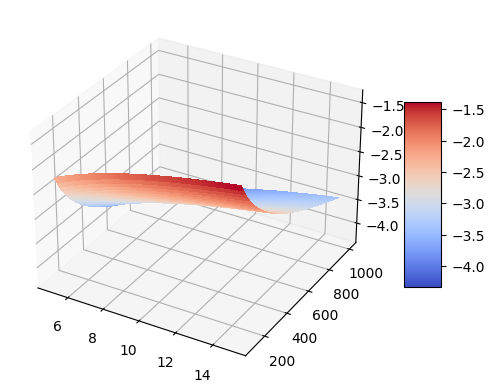

In [575]:

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X, Y = np.meshgrid(D_list, d_list)

# Plot the surface.
surf = ax.plot_surface(X, Y, np.log10(data_d_TP), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

PhD/Results/case/figures/TP_sweep_d_D
PhD/Results/case/figures/IP_sweep_d_D


((<Figure size 640x480 with 2 Axes>, <Axes: xlabel='$d$', ylabel='$D$'>),
 (<Figure size 640x480 with 2 Axes>, <Axes: xlabel='$d$', ylabel='$D$'>))

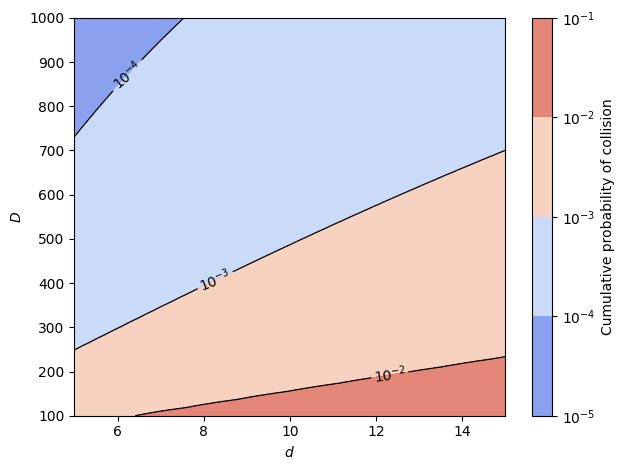

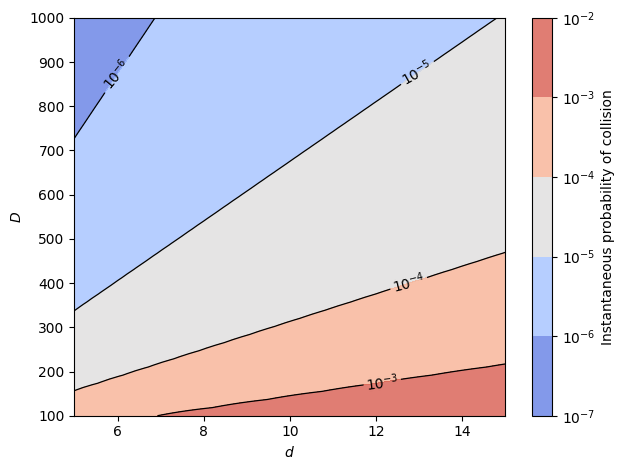

In [576]:
xlabel = r'$D$'
ylabel = r'$d$'
plot_double_contours(D_list, d_list, [data_d_TP, data_d_IP], False, False, True, save=True, xlabel=xlabel, ylabel=ylabel, figures_path=figures_path, tag='sweep_d_D')

In [577]:
default_kwargs['D'] = 5
default_kwargs['d'] = 100

In [578]:
cross_d_list = np.linspace(100, 250, n)
cross_u_list = np.logspace(-3.1, -2.5, n)

data_cross_IP = np.zeros((len(cross_d_list), len(cross_u_list)))
data_cross_TP = np.zeros_like(data_cross_IP)

parameter_name='N'
parameter_list = [100]

for i in range((len(cross_d_list))):
    default_kwargs['d'] = cross_d_list[i]
    print(i)
    for j in range(len(cross_u_list)):
        default_kwargs['q'] = default_kwargs['sigma_vv'] / cross_u_list[j] 
        df = analytic_sweep(default_kwargs, parameter_name, parameter_list)
        data_cross_TP[i, j] = df.iloc[0]['TP'].max()
        data_cross_IP[i, j] = df.iloc[0]['IP'].max()

0








100%|██████████| 1/1 [00:06<00:00,  6.03s/it]






100%|██████████| 1/1 [00:06<00:00,  6.08s/it]






100%|██████████| 1/1 [00:06<00:00,  6.11s/it]






100%|██████████| 1/1 [00:06<00:00,  6.09s/it]






100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.15s/it]






100%|██████████| 1/1 [00:06<00:00,  6.17s/it]






100%|██████████| 1/1 [00:06<00:00,  6.23s/it]






100%|██████████| 1/1 [00:06<00:00,  6.23s/it]






100%|██████████| 1/1 [00:06<00:00,  6.24s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.26s/it]






100%|██████████| 1/1 [00:06<00:00,  6.32s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.32s/it]






100%|██████████| 1/1 [00:06<00:00,  6.37s/it]






100%|██████████| 1/1 [00:06<00:00,  6.38s/it]






100%|██████████| 1/1 [00:06<00:00,  6.36s/it]






100%|██████████| 1/1 [00:06<00:00,  6.39s/it]






100%|█

1








100%|██████████| 1/1 [00:05<00:00,  6.00s/it]






100%|██████████| 1/1 [00:06<00:00,  6.05s/it]






100%|██████████| 1/1 [00:06<00:00,  6.02s/it]






100%|██████████| 1/1 [00:06<00:00,  6.04s/it]






100%|██████████| 1/1 [00:06<00:00,  6.11s/it]






100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.17s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.21s/it]






100%|██████████| 1/1 [00:06<00:00,  6.21s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.27s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.30s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.37s/it]






100%|█

2








100%|██████████| 1/1 [00:05<00:00,  5.99s/it]






100%|██████████| 1/1 [00:06<00:00,  6.02s/it]






100%|██████████| 1/1 [00:06<00:00,  6.04s/it]






100%|██████████| 1/1 [00:06<00:00,  6.07s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.11s/it]






100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.16s/it]






100%|██████████| 1/1 [00:06<00:00,  6.18s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.30s/it]






100%|██████████| 1/1 [00:06<00:00,  6.24s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|██████████| 1/1 [00:06<00:00,  6.34s/it]






100%|██████████| 1/1 [00:06<00:00,  6.33s/it]






100%|██████████| 1/1 [00:06<00:00,  6.38s/it]






100%|█

3








100%|██████████| 1/1 [00:05<00:00,  5.94s/it]






100%|██████████| 1/1 [00:05<00:00,  6.00s/it]






100%|██████████| 1/1 [00:05<00:00,  5.97s/it]






100%|██████████| 1/1 [00:06<00:00,  6.03s/it]






100%|██████████| 1/1 [00:06<00:00,  6.01s/it]






100%|██████████| 1/1 [00:06<00:00,  6.07s/it]






100%|██████████| 1/1 [00:06<00:00,  6.10s/it]






100%|██████████| 1/1 [00:06<00:00,  6.13s/it]






100%|██████████| 1/1 [00:06<00:00,  6.11s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.18s/it]






100%|██████████| 1/1 [00:06<00:00,  6.23s/it]






100%|██████████| 1/1 [00:06<00:00,  6.24s/it]






100%|██████████| 1/1 [00:06<00:00,  6.23s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.30s/it]






100%|██████████| 1/1 [00:06<00:00,  6.29s/it]






100%|██████████| 1/1 [00:06<00:00,  6.32s/it]






100%|██████████| 1/1 [00:06<00:00,  6.35s/it]






100%|█

4








100%|██████████| 1/1 [00:05<00:00,  5.92s/it]






100%|██████████| 1/1 [00:05<00:00,  5.91s/it]






100%|██████████| 1/1 [00:05<00:00,  5.96s/it]






100%|██████████| 1/1 [00:06<00:00,  6.01s/it]






100%|██████████| 1/1 [00:06<00:00,  6.01s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.08s/it]






100%|██████████| 1/1 [00:06<00:00,  6.10s/it]






100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.13s/it]






100%|██████████| 1/1 [00:06<00:00,  6.17s/it]






100%|██████████| 1/1 [00:06<00:00,  6.17s/it]






100%|██████████| 1/1 [00:06<00:00,  6.21s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.23s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.30s/it]






100%|██████████| 1/1 [00:06<00:00,  6.35s/it]






100%|█

5








100%|██████████| 1/1 [00:05<00:00,  5.87s/it]






100%|██████████| 1/1 [00:05<00:00,  5.91s/it]






100%|██████████| 1/1 [00:05<00:00,  5.95s/it]






100%|██████████| 1/1 [00:05<00:00,  5.96s/it]






100%|██████████| 1/1 [00:05<00:00,  6.00s/it]






100%|██████████| 1/1 [00:05<00:00,  6.00s/it]






100%|██████████| 1/1 [00:06<00:00,  6.05s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.09s/it]






100%|██████████| 1/1 [00:06<00:00,  6.09s/it]






100%|██████████| 1/1 [00:06<00:00,  6.13s/it]






100%|██████████| 1/1 [00:06<00:00,  6.16s/it]






100%|██████████| 1/1 [00:06<00:00,  6.20s/it]






100%|██████████| 1/1 [00:06<00:00,  6.18s/it]






100%|██████████| 1/1 [00:06<00:00,  6.23s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.26s/it]






100%|██████████| 1/1 [00:06<00:00,  6.28s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|█

6








100%|██████████| 1/1 [00:05<00:00,  5.85s/it]






100%|██████████| 1/1 [00:05<00:00,  5.89s/it]






100%|██████████| 1/1 [00:05<00:00,  5.94s/it]






100%|██████████| 1/1 [00:05<00:00,  5.94s/it]






100%|██████████| 1/1 [00:05<00:00,  5.95s/it]






100%|██████████| 1/1 [00:05<00:00,  6.00s/it]






100%|██████████| 1/1 [00:06<00:00,  6.03s/it]






100%|██████████| 1/1 [00:06<00:00,  6.05s/it]






100%|██████████| 1/1 [00:06<00:00,  6.07s/it]






100%|██████████| 1/1 [00:06<00:00,  6.05s/it]






100%|██████████| 1/1 [00:06<00:00,  6.10s/it]






100%|██████████| 1/1 [00:06<00:00,  6.13s/it]






100%|██████████| 1/1 [00:06<00:00,  6.15s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.31s/it]






100%|█

7








100%|██████████| 1/1 [00:05<00:00,  5.80s/it]






100%|██████████| 1/1 [00:05<00:00,  5.83s/it]






100%|██████████| 1/1 [00:05<00:00,  5.87s/it]






100%|██████████| 1/1 [00:05<00:00,  5.91s/it]






100%|██████████| 1/1 [00:05<00:00,  5.95s/it]






100%|██████████| 1/1 [00:05<00:00,  5.98s/it]






100%|██████████| 1/1 [00:05<00:00,  5.99s/it]






100%|██████████| 1/1 [00:06<00:00,  6.03s/it]






100%|██████████| 1/1 [00:06<00:00,  6.05s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.09s/it]






100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.13s/it]






100%|██████████| 1/1 [00:06<00:00,  6.16s/it]






100%|██████████| 1/1 [00:06<00:00,  6.18s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|██████████| 1/1 [00:06<00:00,  6.25s/it]






100%|█

8








100%|██████████| 1/1 [00:05<00:00,  5.78s/it]






100%|██████████| 1/1 [00:05<00:00,  5.81s/it]






100%|██████████| 1/1 [00:05<00:00,  5.85s/it]






100%|██████████| 1/1 [00:05<00:00,  5.87s/it]






100%|██████████| 1/1 [00:05<00:00,  5.89s/it]






100%|██████████| 1/1 [00:05<00:00,  5.93s/it]






100%|██████████| 1/1 [00:05<00:00,  5.95s/it]






100%|██████████| 1/1 [00:05<00:00,  5.98s/it]






100%|██████████| 1/1 [00:06<00:00,  6.01s/it]






100%|██████████| 1/1 [00:06<00:00,  6.05s/it]






100%|██████████| 1/1 [00:06<00:00,  6.07s/it]






100%|██████████| 1/1 [00:06<00:00,  6.08s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.14s/it]






100%|██████████| 1/1 [00:06<00:00,  6.17s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|██████████| 1/1 [00:06<00:00,  6.20s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|██████████| 1/1 [00:06<00:00,  6.22s/it]






100%|█

9








100%|██████████| 1/1 [00:05<00:00,  5.74s/it]






100%|██████████| 1/1 [00:05<00:00,  5.74s/it]






100%|██████████| 1/1 [00:05<00:00,  5.83s/it]






100%|██████████| 1/1 [00:05<00:00,  5.82s/it]






100%|██████████| 1/1 [00:05<00:00,  5.88s/it]






100%|██████████| 1/1 [00:05<00:00,  5.91s/it]






100%|██████████| 1/1 [00:05<00:00,  5.91s/it]






100%|██████████| 1/1 [00:05<00:00,  5.99s/it]






100%|██████████| 1/1 [00:05<00:00,  5.99s/it]






100%|██████████| 1/1 [00:05<00:00,  5.99s/it]






100%|██████████| 1/1 [00:06<00:00,  6.05s/it]






100%|██████████| 1/1 [00:06<00:00,  6.04s/it]






100%|██████████| 1/1 [00:06<00:00,  6.10s/it]






100%|██████████| 1/1 [00:06<00:00,  6.09s/it]






100%|██████████| 1/1 [00:06<00:00,  6.13s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.17s/it]






100%|██████████| 1/1 [00:06<00:00,  6.18s/it]






100%|██████████| 1/1 [00:06<00:00,  6.21s/it]






100%|█

10








100%|██████████| 1/1 [00:05<00:00,  5.73s/it]






100%|██████████| 1/1 [00:05<00:00,  5.75s/it]






100%|██████████| 1/1 [00:05<00:00,  5.79s/it]






100%|██████████| 1/1 [00:05<00:00,  5.81s/it]






100%|██████████| 1/1 [00:05<00:00,  5.85s/it]






100%|██████████| 1/1 [00:05<00:00,  5.90s/it]






100%|██████████| 1/1 [00:05<00:00,  5.93s/it]






100%|██████████| 1/1 [00:05<00:00,  5.93s/it]






100%|██████████| 1/1 [00:05<00:00,  5.95s/it]






100%|██████████| 1/1 [00:05<00:00,  6.00s/it]






100%|██████████| 1/1 [00:06<00:00,  6.02s/it]






100%|██████████| 1/1 [00:06<00:00,  6.03s/it]






100%|██████████| 1/1 [00:06<00:00,  6.05s/it]






100%|██████████| 1/1 [00:06<00:00,  6.04s/it]






100%|██████████| 1/1 [00:06<00:00,  6.09s/it]






100%|██████████| 1/1 [00:06<00:00,  6.11s/it]






100%|██████████| 1/1 [00:06<00:00,  6.15s/it]






100%|██████████| 1/1 [00:06<00:00,  6.15s/it]






100%|██████████| 1/1 [00:06<00:00,  6.19s/it]






100%|█

11








100%|██████████| 1/1 [00:05<00:00,  5.68s/it]






100%|██████████| 1/1 [00:05<00:00,  5.70s/it]






100%|██████████| 1/1 [00:05<00:00,  5.74s/it]






100%|██████████| 1/1 [00:05<00:00,  5.80s/it]






100%|██████████| 1/1 [00:05<00:00,  5.79s/it]






100%|██████████| 1/1 [00:05<00:00,  5.81s/it]






100%|██████████| 1/1 [00:05<00:00,  5.86s/it]






100%|██████████| 1/1 [00:05<00:00,  5.88s/it]






100%|██████████| 1/1 [00:05<00:00,  5.90s/it]






100%|██████████| 1/1 [00:05<00:00,  5.94s/it]






100%|██████████| 1/1 [00:05<00:00,  5.99s/it]






100%|██████████| 1/1 [00:06<00:00,  6.00s/it]






100%|██████████| 1/1 [00:06<00:00,  6.05s/it]






100%|██████████| 1/1 [00:06<00:00,  6.09s/it]






100%|██████████| 1/1 [00:06<00:00,  6.08s/it]






100%|██████████| 1/1 [00:06<00:00,  6.09s/it]






100%|██████████| 1/1 [00:06<00:00,  6.11s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.16s/it]






100%|█

12








100%|██████████| 1/1 [00:05<00:00,  5.61s/it]






100%|██████████| 1/1 [00:05<00:00,  5.69s/it]






100%|██████████| 1/1 [00:05<00:00,  5.71s/it]






100%|██████████| 1/1 [00:05<00:00,  5.75s/it]






100%|██████████| 1/1 [00:05<00:00,  5.77s/it]






100%|██████████| 1/1 [00:05<00:00,  5.80s/it]






100%|██████████| 1/1 [00:05<00:00,  5.86s/it]






100%|██████████| 1/1 [00:05<00:00,  5.85s/it]






100%|██████████| 1/1 [00:05<00:00,  5.91s/it]






100%|██████████| 1/1 [00:05<00:00,  5.95s/it]






100%|██████████| 1/1 [00:05<00:00,  5.96s/it]






100%|██████████| 1/1 [00:05<00:00,  6.00s/it]






100%|██████████| 1/1 [00:05<00:00,  5.99s/it]






100%|██████████| 1/1 [00:06<00:00,  6.05s/it]






100%|██████████| 1/1 [00:06<00:00,  6.05s/it]






100%|██████████| 1/1 [00:06<00:00,  6.09s/it]






100%|██████████| 1/1 [00:06<00:00,  6.11s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|██████████| 1/1 [00:06<00:00,  6.16s/it]






100%|█

13








100%|██████████| 1/1 [00:05<00:00,  5.61s/it]






100%|██████████| 1/1 [00:05<00:00,  5.65s/it]






100%|██████████| 1/1 [00:05<00:00,  5.68s/it]






100%|██████████| 1/1 [00:05<00:00,  5.68s/it]






100%|██████████| 1/1 [00:05<00:00,  5.79s/it]






100%|██████████| 1/1 [00:05<00:00,  5.79s/it]






100%|██████████| 1/1 [00:05<00:00,  5.80s/it]






100%|██████████| 1/1 [00:05<00:00,  5.85s/it]






100%|██████████| 1/1 [00:05<00:00,  5.87s/it]






100%|██████████| 1/1 [00:05<00:00,  5.87s/it]






100%|██████████| 1/1 [00:05<00:00,  5.91s/it]






100%|██████████| 1/1 [00:05<00:00,  5.97s/it]






100%|██████████| 1/1 [00:05<00:00,  5.99s/it]






100%|██████████| 1/1 [00:06<00:00,  6.03s/it]






100%|██████████| 1/1 [00:06<00:00,  6.05s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.10s/it]






100%|██████████| 1/1 [00:06<00:00,  6.10s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|█

14








100%|██████████| 1/1 [00:05<00:00,  5.60s/it]






100%|██████████| 1/1 [00:05<00:00,  5.61s/it]






100%|██████████| 1/1 [00:05<00:00,  5.66s/it]






100%|██████████| 1/1 [00:05<00:00,  5.67s/it]






100%|██████████| 1/1 [00:05<00:00,  5.69s/it]






100%|██████████| 1/1 [00:05<00:00,  5.79s/it]






100%|██████████| 1/1 [00:05<00:00,  5.77s/it]






100%|██████████| 1/1 [00:05<00:00,  5.81s/it]






100%|██████████| 1/1 [00:05<00:00,  5.87s/it]






100%|██████████| 1/1 [00:05<00:00,  5.87s/it]






100%|██████████| 1/1 [00:05<00:00,  5.90s/it]






100%|██████████| 1/1 [00:05<00:00,  5.95s/it]






100%|██████████| 1/1 [00:05<00:00,  5.94s/it]






100%|██████████| 1/1 [00:05<00:00,  6.00s/it]






100%|██████████| 1/1 [00:06<00:00,  6.01s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.09s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.12s/it]






100%|█

15








100%|██████████| 1/1 [00:05<00:00,  5.53s/it]






100%|██████████| 1/1 [00:05<00:00,  5.60s/it]






100%|██████████| 1/1 [00:05<00:00,  5.59s/it]






100%|██████████| 1/1 [00:05<00:00,  5.66s/it]






100%|██████████| 1/1 [00:05<00:00,  5.70s/it]






100%|██████████| 1/1 [00:05<00:00,  5.71s/it]






100%|██████████| 1/1 [00:05<00:00,  5.76s/it]






100%|██████████| 1/1 [00:05<00:00,  5.80s/it]






100%|██████████| 1/1 [00:05<00:00,  5.80s/it]






100%|██████████| 1/1 [00:05<00:00,  5.86s/it]






100%|██████████| 1/1 [00:05<00:00,  5.86s/it]






100%|██████████| 1/1 [00:05<00:00,  5.91s/it]






100%|██████████| 1/1 [00:05<00:00,  5.93s/it]






100%|██████████| 1/1 [00:05<00:00,  5.99s/it]






100%|██████████| 1/1 [00:05<00:00,  5.97s/it]






100%|██████████| 1/1 [00:06<00:00,  6.02s/it]






100%|██████████| 1/1 [00:06<00:00,  6.04s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.07s/it]






100%|█

16








100%|██████████| 1/1 [00:05<00:00,  5.51s/it]






100%|██████████| 1/1 [00:05<00:00,  5.54s/it]






100%|██████████| 1/1 [00:05<00:00,  5.56s/it]






100%|██████████| 1/1 [00:05<00:00,  5.61s/it]






100%|██████████| 1/1 [00:05<00:00,  5.70s/it]






100%|██████████| 1/1 [00:05<00:00,  5.71s/it]






100%|██████████| 1/1 [00:05<00:00,  5.72s/it]






100%|██████████| 1/1 [00:05<00:00,  5.77s/it]






100%|██████████| 1/1 [00:05<00:00,  5.82s/it]






100%|██████████| 1/1 [00:05<00:00,  5.81s/it]






100%|██████████| 1/1 [00:05<00:00,  5.83s/it]






100%|██████████| 1/1 [00:05<00:00,  5.90s/it]






100%|██████████| 1/1 [00:05<00:00,  5.91s/it]






100%|██████████| 1/1 [00:05<00:00,  5.96s/it]






100%|██████████| 1/1 [00:05<00:00,  5.97s/it]






100%|██████████| 1/1 [00:05<00:00,  5.99s/it]






100%|██████████| 1/1 [00:06<00:00,  6.02s/it]






100%|██████████| 1/1 [00:06<00:00,  6.04s/it]






100%|██████████| 1/1 [00:06<00:00,  6.06s/it]






100%|█

17








100%|██████████| 1/1 [00:05<00:00,  5.50s/it]






100%|██████████| 1/1 [00:05<00:00,  5.57s/it]






100%|██████████| 1/1 [00:05<00:00,  5.57s/it]






100%|██████████| 1/1 [00:05<00:00,  5.61s/it]






100%|██████████| 1/1 [00:05<00:00,  5.64s/it]






100%|██████████| 1/1 [00:05<00:00,  5.67s/it]






100%|██████████| 1/1 [00:05<00:00,  5.70s/it]






100%|██████████| 1/1 [00:05<00:00,  5.79s/it]






100%|██████████| 1/1 [00:05<00:00,  5.81s/it]






100%|██████████| 1/1 [00:07<00:00,  7.06s/it]






100%|██████████| 1/1 [00:06<00:00,  6.51s/it]






100%|██████████| 1/1 [00:05<00:00,  5.88s/it]






100%|██████████| 1/1 [00:05<00:00,  5.90s/it]






100%|██████████| 1/1 [00:05<00:00,  5.91s/it]






100%|██████████| 1/1 [00:05<00:00,  5.94s/it]






100%|██████████| 1/1 [00:06<00:00,  6.00s/it]






100%|██████████| 1/1 [00:05<00:00,  5.98s/it]






100%|██████████| 1/1 [00:06<00:00,  6.03s/it]






100%|██████████| 1/1 [00:06<00:00,  6.05s/it]






100%|█

18








100%|██████████| 1/1 [00:05<00:00,  5.46s/it]






100%|██████████| 1/1 [00:05<00:00,  5.47s/it]






100%|██████████| 1/1 [00:05<00:00,  5.55s/it]






100%|██████████| 1/1 [00:05<00:00,  5.56s/it]






100%|██████████| 1/1 [00:05<00:00,  5.60s/it]






100%|██████████| 1/1 [00:05<00:00,  5.64s/it]






100%|██████████| 1/1 [00:05<00:00,  5.67s/it]






100%|██████████| 1/1 [00:05<00:00,  5.71s/it]






100%|██████████| 1/1 [00:05<00:00,  5.74s/it]






100%|██████████| 1/1 [00:05<00:00,  5.78s/it]






100%|██████████| 1/1 [00:05<00:00,  5.82s/it]






100%|██████████| 1/1 [00:05<00:00,  5.86s/it]






100%|██████████| 1/1 [00:05<00:00,  5.90s/it]






100%|██████████| 1/1 [00:05<00:00,  5.90s/it]






100%|██████████| 1/1 [00:05<00:00,  5.90s/it]






100%|██████████| 1/1 [00:05<00:00,  5.95s/it]






100%|██████████| 1/1 [00:05<00:00,  5.98s/it]






100%|██████████| 1/1 [00:05<00:00,  5.97s/it]






100%|██████████| 1/1 [00:06<00:00,  6.01s/it]






100%|█

19








100%|██████████| 1/1 [00:05<00:00,  5.39s/it]






100%|██████████| 1/1 [00:05<00:00,  5.43s/it]






100%|██████████| 1/1 [00:05<00:00,  5.51s/it]






100%|██████████| 1/1 [00:05<00:00,  5.54s/it]






100%|██████████| 1/1 [00:05<00:00,  5.55s/it]






100%|██████████| 1/1 [00:05<00:00,  5.58s/it]






100%|██████████| 1/1 [00:05<00:00,  5.68s/it]






100%|██████████| 1/1 [00:05<00:00,  5.67s/it]






100%|██████████| 1/1 [00:05<00:00,  5.71s/it]






100%|██████████| 1/1 [00:05<00:00,  5.73s/it]






100%|██████████| 1/1 [00:05<00:00,  5.76s/it]






100%|██████████| 1/1 [00:05<00:00,  5.80s/it]






100%|██████████| 1/1 [00:05<00:00,  5.84s/it]






100%|██████████| 1/1 [00:05<00:00,  5.86s/it]






100%|██████████| 1/1 [00:05<00:00,  5.90s/it]






100%|██████████| 1/1 [00:05<00:00,  5.94s/it]






100%|██████████| 1/1 [00:05<00:00,  5.97s/it]






100%|██████████| 1/1 [00:05<00:00,  5.96s/it]






100%|██████████| 1/1 [00:06<00:00,  6.02s/it]






100%|█

20








100%|██████████| 1/1 [00:05<00:00,  5.36s/it]






100%|██████████| 1/1 [00:05<00:00,  5.42s/it]






100%|██████████| 1/1 [00:05<00:00,  5.44s/it]






100%|██████████| 1/1 [00:05<00:00,  5.52s/it]






100%|██████████| 1/1 [00:05<00:00,  5.55s/it]






100%|██████████| 1/1 [00:05<00:00,  5.58s/it]






100%|██████████| 1/1 [00:05<00:00,  5.64s/it]






100%|██████████| 1/1 [00:05<00:00,  5.65s/it]






100%|██████████| 1/1 [00:05<00:00,  5.67s/it]






100%|██████████| 1/1 [00:05<00:00,  5.73s/it]






100%|██████████| 1/1 [00:05<00:00,  5.75s/it]






100%|██████████| 1/1 [00:05<00:00,  5.79s/it]






100%|██████████| 1/1 [00:05<00:00,  5.82s/it]






100%|██████████| 1/1 [00:05<00:00,  5.85s/it]






100%|██████████| 1/1 [00:05<00:00,  5.85s/it]






100%|██████████| 1/1 [00:05<00:00,  5.87s/it]






100%|██████████| 1/1 [00:05<00:00,  5.95s/it]






100%|██████████| 1/1 [00:05<00:00,  5.93s/it]






100%|██████████| 1/1 [00:05<00:00,  5.97s/it]






100%|█

21








100%|██████████| 1/1 [00:05<00:00,  5.33s/it]






100%|██████████| 1/1 [00:05<00:00,  5.39s/it]






100%|██████████| 1/1 [00:05<00:00,  5.45s/it]






100%|██████████| 1/1 [00:05<00:00,  5.48s/it]






100%|██████████| 1/1 [00:05<00:00,  5.49s/it]






100%|██████████| 1/1 [00:05<00:00,  5.58s/it]






100%|██████████| 1/1 [00:05<00:00,  5.58s/it]






100%|██████████| 1/1 [00:05<00:00,  5.63s/it]






100%|██████████| 1/1 [00:05<00:00,  5.65s/it]






100%|██████████| 1/1 [00:05<00:00,  5.70s/it]






100%|██████████| 1/1 [00:05<00:00,  5.71s/it]






100%|██████████| 1/1 [00:05<00:00,  5.76s/it]






100%|██████████| 1/1 [00:05<00:00,  5.80s/it]






100%|██████████| 1/1 [00:05<00:00,  5.82s/it]






100%|██████████| 1/1 [00:05<00:00,  5.86s/it]






100%|██████████| 1/1 [00:05<00:00,  5.89s/it]






100%|██████████| 1/1 [00:05<00:00,  5.92s/it]






100%|██████████| 1/1 [00:05<00:00,  5.94s/it]






100%|██████████| 1/1 [00:05<00:00,  5.98s/it]






100%|█

22








100%|██████████| 1/1 [00:05<00:00,  5.31s/it]






100%|██████████| 1/1 [00:05<00:00,  5.35s/it]






100%|██████████| 1/1 [00:05<00:00,  5.42s/it]






100%|██████████| 1/1 [00:05<00:00,  5.43s/it]






100%|██████████| 1/1 [00:05<00:00,  5.47s/it]






100%|██████████| 1/1 [00:05<00:00,  5.50s/it]






100%|██████████| 1/1 [00:05<00:00,  5.55s/it]






100%|██████████| 1/1 [00:05<00:00,  5.62s/it]






100%|██████████| 1/1 [00:05<00:00,  5.62s/it]






100%|██████████| 1/1 [00:05<00:00,  5.65s/it]






100%|██████████| 1/1 [00:05<00:00,  5.68s/it]






100%|██████████| 1/1 [00:05<00:00,  5.73s/it]






100%|██████████| 1/1 [00:05<00:00,  5.77s/it]






100%|██████████| 1/1 [00:05<00:00,  5.81s/it]






100%|██████████| 1/1 [00:05<00:00,  5.82s/it]






100%|██████████| 1/1 [00:05<00:00,  5.84s/it]






100%|██████████| 1/1 [00:05<00:00,  5.90s/it]






100%|██████████| 1/1 [00:05<00:00,  5.95s/it]






100%|██████████| 1/1 [00:05<00:00,  5.93s/it]






100%|█

23








100%|██████████| 1/1 [00:05<00:00,  5.26s/it]






100%|██████████| 1/1 [00:05<00:00,  5.33s/it]






100%|██████████| 1/1 [00:05<00:00,  5.39s/it]






100%|██████████| 1/1 [00:05<00:00,  5.42s/it]






100%|██████████| 1/1 [00:05<00:00,  5.44s/it]






100%|██████████| 1/1 [00:05<00:00,  5.50s/it]






100%|██████████| 1/1 [00:05<00:00,  5.53s/it]






100%|██████████| 1/1 [00:05<00:00,  5.58s/it]






100%|██████████| 1/1 [00:05<00:00,  5.60s/it]






100%|██████████| 1/1 [00:05<00:00,  5.63s/it]






100%|██████████| 1/1 [00:05<00:00,  5.68s/it]






100%|██████████| 1/1 [00:05<00:00,  5.70s/it]






100%|██████████| 1/1 [00:05<00:00,  5.72s/it]






100%|██████████| 1/1 [00:05<00:00,  5.78s/it]






100%|██████████| 1/1 [00:05<00:00,  5.81s/it]






100%|██████████| 1/1 [00:05<00:00,  5.84s/it]






100%|██████████| 1/1 [00:05<00:00,  5.88s/it]






100%|██████████| 1/1 [00:05<00:00,  5.90s/it]






100%|██████████| 1/1 [00:05<00:00,  5.93s/it]






100%|█

24








100%|██████████| 1/1 [00:05<00:00,  5.26s/it]






100%|██████████| 1/1 [00:05<00:00,  5.25s/it]






100%|██████████| 1/1 [00:05<00:00,  5.32s/it]






100%|██████████| 1/1 [00:05<00:00,  5.38s/it]






100%|██████████| 1/1 [00:05<00:00,  5.43s/it]






100%|██████████| 1/1 [00:05<00:00,  5.47s/it]






100%|██████████| 1/1 [00:05<00:00,  5.48s/it]






100%|██████████| 1/1 [00:05<00:00,  5.55s/it]






100%|██████████| 1/1 [00:05<00:00,  5.55s/it]






100%|██████████| 1/1 [00:05<00:00,  5.64s/it]






100%|██████████| 1/1 [00:05<00:00,  5.66s/it]






100%|██████████| 1/1 [00:05<00:00,  5.69s/it]






100%|██████████| 1/1 [00:05<00:00,  5.71s/it]






100%|██████████| 1/1 [00:05<00:00,  5.76s/it]






100%|██████████| 1/1 [00:05<00:00,  5.78s/it]






100%|██████████| 1/1 [00:05<00:00,  5.82s/it]






100%|██████████| 1/1 [00:05<00:00,  5.84s/it]






100%|██████████| 1/1 [00:05<00:00,  5.88s/it]






100%|██████████| 1/1 [00:05<00:00,  5.90s/it]






100%|█

25








100%|██████████| 1/1 [00:05<00:00,  5.23s/it]






100%|██████████| 1/1 [00:05<00:00,  5.23s/it]






100%|██████████| 1/1 [00:05<00:00,  5.30s/it]






100%|██████████| 1/1 [00:05<00:00,  5.34s/it]






100%|██████████| 1/1 [00:05<00:00,  5.39s/it]






100%|██████████| 1/1 [00:05<00:00,  5.43s/it]






100%|██████████| 1/1 [00:05<00:00,  5.46s/it]






100%|██████████| 1/1 [00:05<00:00,  5.52s/it]






100%|██████████| 1/1 [00:05<00:00,  5.56s/it]






100%|██████████| 1/1 [00:05<00:00,  5.56s/it]






100%|██████████| 1/1 [00:05<00:00,  5.65s/it]






100%|██████████| 1/1 [00:05<00:00,  5.68s/it]






100%|██████████| 1/1 [00:05<00:00,  5.70s/it]






100%|██████████| 1/1 [00:05<00:00,  5.74s/it]






100%|██████████| 1/1 [00:05<00:00,  5.77s/it]






100%|██████████| 1/1 [00:05<00:00,  5.79s/it]






100%|██████████| 1/1 [00:05<00:00,  5.83s/it]






100%|██████████| 1/1 [00:05<00:00,  5.86s/it]






100%|██████████| 1/1 [00:05<00:00,  5.89s/it]






100%|█

26








100%|██████████| 1/1 [00:05<00:00,  5.15s/it]






100%|██████████| 1/1 [00:05<00:00,  5.23s/it]






100%|██████████| 1/1 [00:05<00:00,  5.28s/it]






100%|██████████| 1/1 [00:05<00:00,  5.34s/it]






100%|██████████| 1/1 [00:05<00:00,  5.33s/it]






100%|██████████| 1/1 [00:05<00:00,  5.38s/it]






100%|██████████| 1/1 [00:05<00:00,  5.44s/it]






100%|██████████| 1/1 [00:05<00:00,  5.46s/it]






100%|██████████| 1/1 [00:05<00:00,  5.52s/it]






100%|██████████| 1/1 [00:05<00:00,  5.56s/it]






100%|██████████| 1/1 [00:05<00:00,  5.57s/it]






100%|██████████| 1/1 [00:05<00:00,  5.62s/it]






100%|██████████| 1/1 [00:05<00:00,  5.70s/it]






100%|██████████| 1/1 [00:05<00:00,  5.70s/it]






100%|██████████| 1/1 [00:05<00:00,  5.76s/it]






100%|██████████| 1/1 [00:05<00:00,  5.78s/it]






100%|██████████| 1/1 [00:05<00:00,  5.81s/it]






100%|██████████| 1/1 [00:05<00:00,  5.83s/it]






100%|██████████| 1/1 [00:05<00:00,  5.86s/it]






100%|█

27








100%|██████████| 1/1 [00:05<00:00,  5.12s/it]






100%|██████████| 1/1 [00:05<00:00,  5.19s/it]






100%|██████████| 1/1 [00:05<00:00,  5.24s/it]






100%|██████████| 1/1 [00:05<00:00,  5.26s/it]






100%|██████████| 1/1 [00:05<00:00,  5.35s/it]






100%|██████████| 1/1 [00:05<00:00,  5.36s/it]






100%|██████████| 1/1 [00:05<00:00,  5.41s/it]






100%|██████████| 1/1 [00:05<00:00,  5.49s/it]






100%|██████████| 1/1 [00:05<00:00,  5.49s/it]






100%|██████████| 1/1 [00:05<00:00,  5.55s/it]






100%|██████████| 1/1 [00:05<00:00,  5.57s/it]






100%|██████████| 1/1 [00:05<00:00,  5.56s/it]






100%|██████████| 1/1 [00:05<00:00,  5.66s/it]






100%|██████████| 1/1 [00:05<00:00,  5.65s/it]






100%|██████████| 1/1 [00:05<00:00,  5.73s/it]






100%|██████████| 1/1 [00:05<00:00,  5.72s/it]






100%|██████████| 1/1 [00:05<00:00,  5.80s/it]






100%|██████████| 1/1 [00:05<00:00,  5.84s/it]






100%|██████████| 1/1 [00:05<00:00,  5.85s/it]






100%|█

28








100%|██████████| 1/1 [00:05<00:00,  5.11s/it]






100%|██████████| 1/1 [00:05<00:00,  5.16s/it]






100%|██████████| 1/1 [00:05<00:00,  5.20s/it]






100%|██████████| 1/1 [00:05<00:00,  5.25s/it]






100%|██████████| 1/1 [00:05<00:00,  5.32s/it]






100%|██████████| 1/1 [00:05<00:00,  5.31s/it]






100%|██████████| 1/1 [00:05<00:00,  5.41s/it]






100%|██████████| 1/1 [00:05<00:00,  5.40s/it]






100%|██████████| 1/1 [00:05<00:00,  5.47s/it]






100%|██████████| 1/1 [00:05<00:00,  5.52s/it]






100%|██████████| 1/1 [00:05<00:00,  5.54s/it]






100%|██████████| 1/1 [00:05<00:00,  5.59s/it]






100%|██████████| 1/1 [00:05<00:00,  5.60s/it]






100%|██████████| 1/1 [00:05<00:00,  5.65s/it]






100%|██████████| 1/1 [00:05<00:00,  5.69s/it]






100%|██████████| 1/1 [00:05<00:00,  5.72s/it]






100%|██████████| 1/1 [00:05<00:00,  5.75s/it]






100%|██████████| 1/1 [00:05<00:00,  5.80s/it]






100%|██████████| 1/1 [00:05<00:00,  5.82s/it]






100%|█

29








100%|██████████| 1/1 [00:05<00:00,  5.06s/it]






100%|██████████| 1/1 [00:05<00:00,  5.11s/it]






100%|██████████| 1/1 [00:05<00:00,  5.19s/it]






100%|██████████| 1/1 [00:05<00:00,  5.22s/it]






100%|██████████| 1/1 [00:05<00:00,  5.27s/it]






100%|██████████| 1/1 [00:05<00:00,  5.32s/it]






100%|██████████| 1/1 [00:05<00:00,  5.37s/it]






100%|██████████| 1/1 [00:05<00:00,  5.39s/it]






100%|██████████| 1/1 [00:05<00:00,  5.44s/it]






100%|██████████| 1/1 [00:05<00:00,  5.47s/it]






100%|██████████| 1/1 [00:05<00:00,  5.54s/it]






100%|██████████| 1/1 [00:05<00:00,  5.54s/it]






100%|██████████| 1/1 [00:05<00:00,  5.60s/it]






100%|██████████| 1/1 [00:05<00:00,  5.59s/it]






100%|██████████| 1/1 [00:05<00:00,  5.67s/it]






100%|██████████| 1/1 [00:05<00:00,  5.74s/it]






100%|██████████| 1/1 [00:05<00:00,  5.73s/it]






100%|██████████| 1/1 [00:05<00:00,  5.77s/it]






100%|██████████| 1/1 [00:05<00:00,  5.77s/it]






100%|█

30








100%|██████████| 1/1 [00:05<00:00,  5.03s/it]






100%|██████████| 1/1 [00:05<00:00,  5.08s/it]






100%|██████████| 1/1 [00:05<00:00,  5.14s/it]






100%|██████████| 1/1 [00:05<00:00,  5.17s/it]






100%|██████████| 1/1 [00:05<00:00,  5.23s/it]






100%|██████████| 1/1 [00:05<00:00,  5.28s/it]






100%|██████████| 1/1 [00:05<00:00,  5.33s/it]






100%|██████████| 1/1 [00:05<00:00,  5.36s/it]






100%|██████████| 1/1 [00:05<00:00,  5.42s/it]






100%|██████████| 1/1 [00:05<00:00,  5.46s/it]






100%|██████████| 1/1 [00:05<00:00,  5.49s/it]






100%|██████████| 1/1 [00:05<00:00,  5.52s/it]






100%|██████████| 1/1 [00:05<00:00,  5.57s/it]






100%|██████████| 1/1 [00:05<00:00,  5.62s/it]






100%|██████████| 1/1 [00:05<00:00,  5.66s/it]






100%|██████████| 1/1 [00:05<00:00,  5.65s/it]






100%|██████████| 1/1 [00:05<00:00,  5.73s/it]






100%|██████████| 1/1 [00:05<00:00,  5.75s/it]






100%|██████████| 1/1 [00:05<00:00,  5.80s/it]






100%|█

31








100%|██████████| 1/1 [00:04<00:00,  5.00s/it]






100%|██████████| 1/1 [00:05<00:00,  5.04s/it]






100%|██████████| 1/1 [00:05<00:00,  5.09s/it]






100%|██████████| 1/1 [00:05<00:00,  5.14s/it]






100%|██████████| 1/1 [00:05<00:00,  5.19s/it]






100%|██████████| 1/1 [00:05<00:00,  5.25s/it]






100%|██████████| 1/1 [00:05<00:00,  5.32s/it]






100%|██████████| 1/1 [00:05<00:00,  5.33s/it]






100%|██████████| 1/1 [00:05<00:00,  5.38s/it]






100%|██████████| 1/1 [00:05<00:00,  5.42s/it]






100%|██████████| 1/1 [00:05<00:00,  5.47s/it]






100%|██████████| 1/1 [00:05<00:00,  5.52s/it]






100%|██████████| 1/1 [00:05<00:00,  5.56s/it]






100%|██████████| 1/1 [00:05<00:00,  5.59s/it]






100%|██████████| 1/1 [00:05<00:00,  5.64s/it]






100%|██████████| 1/1 [00:05<00:00,  5.64s/it]






100%|██████████| 1/1 [00:05<00:00,  5.70s/it]






100%|██████████| 1/1 [00:05<00:00,  5.71s/it]






100%|██████████| 1/1 [00:05<00:00,  5.79s/it]






100%|█

32








100%|██████████| 1/1 [00:04<00:00,  4.97s/it]






100%|██████████| 1/1 [00:04<00:00,  5.00s/it]






100%|██████████| 1/1 [00:05<00:00,  5.05s/it]






100%|██████████| 1/1 [00:05<00:00,  5.13s/it]






100%|██████████| 1/1 [00:05<00:00,  5.17s/it]






100%|██████████| 1/1 [00:05<00:00,  5.26s/it]






100%|██████████| 1/1 [00:05<00:00,  5.24s/it]






100%|██████████| 1/1 [00:05<00:00,  5.32s/it]






100%|██████████| 1/1 [00:05<00:00,  5.33s/it]






100%|██████████| 1/1 [00:05<00:00,  5.40s/it]






100%|██████████| 1/1 [00:05<00:00,  5.42s/it]






100%|██████████| 1/1 [00:05<00:00,  5.49s/it]






100%|██████████| 1/1 [00:05<00:00,  5.54s/it]






100%|██████████| 1/1 [00:05<00:00,  5.55s/it]






100%|██████████| 1/1 [00:05<00:00,  5.58s/it]






100%|██████████| 1/1 [00:05<00:00,  5.64s/it]






100%|██████████| 1/1 [00:05<00:00,  5.66s/it]






100%|██████████| 1/1 [00:05<00:00,  5.70s/it]






100%|██████████| 1/1 [00:05<00:00,  5.74s/it]






100%|█

33








100%|██████████| 1/1 [00:04<00:00,  4.92s/it]






100%|██████████| 1/1 [00:04<00:00,  4.98s/it]






100%|██████████| 1/1 [00:05<00:00,  5.05s/it]






100%|██████████| 1/1 [00:05<00:00,  5.08s/it]






100%|██████████| 1/1 [00:05<00:00,  5.15s/it]






100%|██████████| 1/1 [00:05<00:00,  5.17s/it]






100%|██████████| 1/1 [00:05<00:00,  5.23s/it]






100%|██████████| 1/1 [00:05<00:00,  5.27s/it]






100%|██████████| 1/1 [00:05<00:00,  5.33s/it]






100%|██████████| 1/1 [00:05<00:00,  5.40s/it]






100%|██████████| 1/1 [00:05<00:00,  5.41s/it]






100%|██████████| 1/1 [00:05<00:00,  5.45s/it]






100%|██████████| 1/1 [00:05<00:00,  5.48s/it]






100%|██████████| 1/1 [00:05<00:00,  5.52s/it]






100%|██████████| 1/1 [00:05<00:00,  5.56s/it]






100%|██████████| 1/1 [00:05<00:00,  5.61s/it]






100%|██████████| 1/1 [00:05<00:00,  5.67s/it]






100%|██████████| 1/1 [00:05<00:00,  5.70s/it]






100%|██████████| 1/1 [00:05<00:00,  5.76s/it]






100%|█

34








100%|██████████| 1/1 [00:04<00:00,  4.91s/it]






100%|██████████| 1/1 [00:04<00:00,  4.97s/it]






100%|██████████| 1/1 [00:05<00:00,  5.01s/it]






100%|██████████| 1/1 [00:05<00:00,  5.07s/it]






100%|██████████| 1/1 [00:05<00:00,  5.12s/it]






100%|██████████| 1/1 [00:05<00:00,  5.16s/it]






100%|██████████| 1/1 [00:05<00:00,  5.23s/it]






100%|██████████| 1/1 [00:05<00:00,  5.26s/it]






100%|██████████| 1/1 [00:05<00:00,  5.32s/it]






100%|██████████| 1/1 [00:05<00:00,  5.35s/it]






100%|██████████| 1/1 [00:05<00:00,  5.37s/it]






100%|██████████| 1/1 [00:05<00:00,  5.42s/it]






100%|██████████| 1/1 [00:05<00:00,  5.46s/it]






100%|██████████| 1/1 [00:05<00:00,  5.52s/it]






100%|██████████| 1/1 [00:05<00:00,  5.54s/it]






100%|██████████| 1/1 [00:05<00:00,  5.57s/it]






100%|██████████| 1/1 [00:05<00:00,  5.62s/it]






100%|██████████| 1/1 [00:05<00:00,  5.70s/it]






100%|██████████| 1/1 [00:05<00:00,  5.70s/it]






100%|█

35








100%|██████████| 1/1 [00:04<00:00,  4.86s/it]






100%|██████████| 1/1 [00:04<00:00,  4.92s/it]






100%|██████████| 1/1 [00:04<00:00,  4.97s/it]






100%|██████████| 1/1 [00:05<00:00,  5.05s/it]






100%|██████████| 1/1 [00:05<00:00,  5.07s/it]






100%|██████████| 1/1 [00:05<00:00,  5.14s/it]






100%|██████████| 1/1 [00:05<00:00,  5.20s/it]






100%|██████████| 1/1 [00:05<00:00,  5.22s/it]






100%|██████████| 1/1 [00:05<00:00,  5.30s/it]






100%|██████████| 1/1 [00:05<00:00,  5.33s/it]






100%|██████████| 1/1 [00:05<00:00,  5.35s/it]






100%|██████████| 1/1 [00:05<00:00,  5.40s/it]






100%|██████████| 1/1 [00:05<00:00,  5.45s/it]






100%|██████████| 1/1 [00:05<00:00,  5.52s/it]






100%|██████████| 1/1 [00:05<00:00,  5.55s/it]






100%|██████████| 1/1 [00:05<00:00,  5.58s/it]






100%|██████████| 1/1 [00:05<00:00,  5.59s/it]






100%|██████████| 1/1 [00:05<00:00,  5.62s/it]






100%|██████████| 1/1 [00:05<00:00,  5.67s/it]






100%|█

36








100%|██████████| 1/1 [00:04<00:00,  4.79s/it]






100%|██████████| 1/1 [00:04<00:00,  4.86s/it]






100%|██████████| 1/1 [00:04<00:00,  4.93s/it]






100%|██████████| 1/1 [00:04<00:00,  4.98s/it]






100%|██████████| 1/1 [00:05<00:00,  5.06s/it]






100%|██████████| 1/1 [00:05<00:00,  5.11s/it]






100%|██████████| 1/1 [00:05<00:00,  5.16s/it]






100%|██████████| 1/1 [00:05<00:00,  5.20s/it]






100%|██████████| 1/1 [00:05<00:00,  5.25s/it]






100%|██████████| 1/1 [00:05<00:00,  5.30s/it]






100%|██████████| 1/1 [00:05<00:00,  5.34s/it]






100%|██████████| 1/1 [00:05<00:00,  5.38s/it]






100%|██████████| 1/1 [00:05<00:00,  5.42s/it]






100%|██████████| 1/1 [00:05<00:00,  5.48s/it]






100%|██████████| 1/1 [00:05<00:00,  5.52s/it]






100%|██████████| 1/1 [00:05<00:00,  5.54s/it]






100%|██████████| 1/1 [00:05<00:00,  5.58s/it]






100%|██████████| 1/1 [00:05<00:00,  5.62s/it]






100%|██████████| 1/1 [00:05<00:00,  5.65s/it]






100%|█

37








100%|██████████| 1/1 [00:04<00:00,  4.79s/it]






100%|██████████| 1/1 [00:04<00:00,  4.85s/it]






100%|██████████| 1/1 [00:04<00:00,  4.91s/it]






100%|██████████| 1/1 [00:04<00:00,  4.98s/it]






100%|██████████| 1/1 [00:05<00:00,  5.01s/it]






100%|██████████| 1/1 [00:05<00:00,  5.07s/it]






100%|██████████| 1/1 [00:05<00:00,  5.14s/it]






100%|██████████| 1/1 [00:05<00:00,  5.19s/it]






100%|██████████| 1/1 [00:05<00:00,  5.23s/it]






100%|██████████| 1/1 [00:05<00:00,  5.27s/it]






100%|██████████| 1/1 [00:05<00:00,  5.32s/it]






100%|██████████| 1/1 [00:05<00:00,  5.36s/it]






100%|██████████| 1/1 [00:05<00:00,  5.42s/it]






100%|██████████| 1/1 [00:05<00:00,  5.45s/it]






100%|██████████| 1/1 [00:05<00:00,  5.48s/it]






100%|██████████| 1/1 [00:05<00:00,  5.51s/it]






100%|██████████| 1/1 [00:05<00:00,  5.55s/it]






100%|██████████| 1/1 [00:05<00:00,  5.56s/it]






100%|██████████| 1/1 [00:05<00:00,  5.62s/it]






100%|█

38








100%|██████████| 1/1 [00:04<00:00,  4.76s/it]






100%|██████████| 1/1 [00:04<00:00,  4.81s/it]






100%|██████████| 1/1 [00:04<00:00,  4.86s/it]






100%|██████████| 1/1 [00:04<00:00,  4.92s/it]






100%|██████████| 1/1 [00:04<00:00,  4.97s/it]






100%|██████████| 1/1 [00:05<00:00,  5.07s/it]






100%|██████████| 1/1 [00:05<00:00,  5.11s/it]






100%|██████████| 1/1 [00:05<00:00,  5.16s/it]






100%|██████████| 1/1 [00:05<00:00,  5.20s/it]






100%|██████████| 1/1 [00:05<00:00,  5.26s/it]






100%|██████████| 1/1 [00:05<00:00,  5.29s/it]






100%|██████████| 1/1 [00:05<00:00,  5.39s/it]






100%|██████████| 1/1 [00:05<00:00,  5.39s/it]






100%|██████████| 1/1 [00:05<00:00,  5.45s/it]






100%|██████████| 1/1 [00:05<00:00,  5.45s/it]






100%|██████████| 1/1 [00:05<00:00,  5.51s/it]






100%|██████████| 1/1 [00:05<00:00,  5.55s/it]






100%|██████████| 1/1 [00:05<00:00,  5.57s/it]






100%|██████████| 1/1 [00:05<00:00,  5.63s/it]






100%|█

39








100%|██████████| 1/1 [00:04<00:00,  4.74s/it]






100%|██████████| 1/1 [00:04<00:00,  4.78s/it]






100%|██████████| 1/1 [00:04<00:00,  4.84s/it]






100%|██████████| 1/1 [00:04<00:00,  4.91s/it]






100%|██████████| 1/1 [00:04<00:00,  4.97s/it]






100%|██████████| 1/1 [00:05<00:00,  5.00s/it]






100%|██████████| 1/1 [00:05<00:00,  5.05s/it]






100%|██████████| 1/1 [00:05<00:00,  5.13s/it]






100%|██████████| 1/1 [00:05<00:00,  5.17s/it]






100%|██████████| 1/1 [00:05<00:00,  5.23s/it]






100%|██████████| 1/1 [00:05<00:00,  5.26s/it]






100%|██████████| 1/1 [00:05<00:00,  5.30s/it]






100%|██████████| 1/1 [00:05<00:00,  5.34s/it]






100%|██████████| 1/1 [00:05<00:00,  5.40s/it]






100%|██████████| 1/1 [00:05<00:00,  5.45s/it]






100%|██████████| 1/1 [00:05<00:00,  5.48s/it]






100%|██████████| 1/1 [00:05<00:00,  5.55s/it]






100%|██████████| 1/1 [00:05<00:00,  5.57s/it]






100%|██████████| 1/1 [00:05<00:00,  5.57s/it]






100%|█

40








100%|██████████| 1/1 [00:04<00:00,  4.68s/it]






100%|██████████| 1/1 [00:04<00:00,  4.74s/it]






100%|██████████| 1/1 [00:04<00:00,  4.81s/it]






100%|██████████| 1/1 [00:04<00:00,  4.86s/it]






100%|██████████| 1/1 [00:04<00:00,  4.94s/it]






100%|██████████| 1/1 [00:04<00:00,  4.96s/it]






100%|██████████| 1/1 [00:05<00:00,  5.05s/it]






100%|██████████| 1/1 [00:05<00:00,  5.07s/it]






100%|██████████| 1/1 [00:05<00:00,  5.17s/it]






100%|██████████| 1/1 [00:05<00:00,  5.20s/it]






100%|██████████| 1/1 [00:05<00:00,  5.24s/it]






100%|██████████| 1/1 [00:05<00:00,  5.30s/it]






100%|██████████| 1/1 [00:05<00:00,  5.36s/it]






100%|██████████| 1/1 [00:05<00:00,  5.39s/it]






100%|██████████| 1/1 [00:05<00:00,  5.42s/it]






100%|██████████| 1/1 [00:05<00:00,  5.44s/it]






100%|██████████| 1/1 [00:05<00:00,  5.51s/it]






100%|██████████| 1/1 [00:05<00:00,  5.52s/it]






100%|██████████| 1/1 [00:05<00:00,  5.56s/it]






100%|█

41








100%|██████████| 1/1 [00:04<00:00,  4.66s/it]






100%|██████████| 1/1 [00:04<00:00,  4.72s/it]






100%|██████████| 1/1 [00:04<00:00,  4.76s/it]






100%|██████████| 1/1 [00:04<00:00,  4.85s/it]






100%|██████████| 1/1 [00:04<00:00,  4.91s/it]






100%|██████████| 1/1 [00:04<00:00,  4.98s/it]






100%|██████████| 1/1 [00:05<00:00,  5.01s/it]






100%|██████████| 1/1 [00:05<00:00,  5.07s/it]






100%|██████████| 1/1 [00:05<00:00,  5.12s/it]






100%|██████████| 1/1 [00:05<00:00,  5.15s/it]






100%|██████████| 1/1 [00:05<00:00,  5.18s/it]






100%|██████████| 1/1 [00:05<00:00,  5.27s/it]






100%|██████████| 1/1 [00:05<00:00,  5.32s/it]






100%|██████████| 1/1 [00:05<00:00,  5.36s/it]






100%|██████████| 1/1 [00:05<00:00,  5.40s/it]






100%|██████████| 1/1 [00:05<00:00,  5.44s/it]






100%|██████████| 1/1 [00:05<00:00,  5.47s/it]






100%|██████████| 1/1 [00:05<00:00,  5.52s/it]






100%|██████████| 1/1 [00:05<00:00,  5.58s/it]






100%|█

42








100%|██████████| 1/1 [00:04<00:00,  4.63s/it]






100%|██████████| 1/1 [00:04<00:00,  4.69s/it]






100%|██████████| 1/1 [00:04<00:00,  4.75s/it]






100%|██████████| 1/1 [00:04<00:00,  4.83s/it]






100%|██████████| 1/1 [00:04<00:00,  4.88s/it]






100%|██████████| 1/1 [00:04<00:00,  4.94s/it]






100%|██████████| 1/1 [00:05<00:00,  5.00s/it]






100%|██████████| 1/1 [00:05<00:00,  5.04s/it]






100%|██████████| 1/1 [00:05<00:00,  5.07s/it]






100%|██████████| 1/1 [00:05<00:00,  5.14s/it]






100%|██████████| 1/1 [00:05<00:00,  5.20s/it]






100%|██████████| 1/1 [00:05<00:00,  5.20s/it]






100%|██████████| 1/1 [00:05<00:00,  5.26s/it]






100%|██████████| 1/1 [00:05<00:00,  5.33s/it]






100%|██████████| 1/1 [00:05<00:00,  5.37s/it]






100%|██████████| 1/1 [00:05<00:00,  5.40s/it]






100%|██████████| 1/1 [00:05<00:00,  5.43s/it]






100%|██████████| 1/1 [00:05<00:00,  5.49s/it]






100%|██████████| 1/1 [00:05<00:00,  5.54s/it]






100%|█

43








100%|██████████| 1/1 [00:04<00:00,  4.58s/it]






100%|██████████| 1/1 [00:04<00:00,  4.65s/it]






100%|██████████| 1/1 [00:04<00:00,  4.72s/it]






100%|██████████| 1/1 [00:04<00:00,  4.76s/it]






100%|██████████| 1/1 [00:04<00:00,  4.85s/it]






100%|██████████| 1/1 [00:04<00:00,  4.88s/it]






100%|██████████| 1/1 [00:04<00:00,  4.94s/it]






100%|██████████| 1/1 [00:05<00:00,  5.03s/it]






100%|██████████| 1/1 [00:05<00:00,  5.05s/it]






100%|██████████| 1/1 [00:05<00:00,  5.12s/it]






100%|██████████| 1/1 [00:05<00:00,  5.17s/it]






100%|██████████| 1/1 [00:05<00:00,  5.20s/it]






100%|██████████| 1/1 [00:05<00:00,  5.26s/it]






100%|██████████| 1/1 [00:05<00:00,  5.29s/it]






100%|██████████| 1/1 [00:05<00:00,  5.33s/it]






100%|██████████| 1/1 [00:05<00:00,  5.38s/it]






100%|██████████| 1/1 [00:05<00:00,  5.47s/it]






100%|██████████| 1/1 [00:05<00:00,  5.47s/it]






100%|██████████| 1/1 [00:05<00:00,  5.52s/it]






100%|█

44








100%|██████████| 1/1 [00:04<00:00,  4.53s/it]






100%|██████████| 1/1 [00:04<00:00,  4.62s/it]






100%|██████████| 1/1 [00:04<00:00,  4.67s/it]






100%|██████████| 1/1 [00:04<00:00,  4.73s/it]






100%|██████████| 1/1 [00:04<00:00,  4.80s/it]






100%|██████████| 1/1 [00:04<00:00,  4.85s/it]






100%|██████████| 1/1 [00:04<00:00,  4.93s/it]






100%|██████████| 1/1 [00:04<00:00,  4.98s/it]






100%|██████████| 1/1 [00:05<00:00,  5.04s/it]






100%|██████████| 1/1 [00:05<00:00,  5.08s/it]






100%|██████████| 1/1 [00:05<00:00,  5.18s/it]






100%|██████████| 1/1 [00:05<00:00,  5.17s/it]






100%|██████████| 1/1 [00:05<00:00,  5.23s/it]






100%|██████████| 1/1 [00:05<00:00,  5.29s/it]






100%|██████████| 1/1 [00:05<00:00,  5.33s/it]






100%|██████████| 1/1 [00:05<00:00,  5.36s/it]






100%|██████████| 1/1 [00:05<00:00,  5.41s/it]






100%|██████████| 1/1 [00:05<00:00,  5.45s/it]






100%|██████████| 1/1 [00:05<00:00,  5.51s/it]






100%|█

45








100%|██████████| 1/1 [00:04<00:00,  4.52s/it]






100%|██████████| 1/1 [00:04<00:00,  4.59s/it]






100%|██████████| 1/1 [00:04<00:00,  4.63s/it]






100%|██████████| 1/1 [00:04<00:00,  4.71s/it]






100%|██████████| 1/1 [00:04<00:00,  4.78s/it]






100%|██████████| 1/1 [00:04<00:00,  4.83s/it]






100%|██████████| 1/1 [00:04<00:00,  4.88s/it]






100%|██████████| 1/1 [00:04<00:00,  4.95s/it]






100%|██████████| 1/1 [00:05<00:00,  5.02s/it]






100%|██████████| 1/1 [00:05<00:00,  5.05s/it]






100%|██████████| 1/1 [00:05<00:00,  5.11s/it]






100%|██████████| 1/1 [00:05<00:00,  5.17s/it]






100%|██████████| 1/1 [00:05<00:00,  5.23s/it]






100%|██████████| 1/1 [00:05<00:00,  5.25s/it]






100%|██████████| 1/1 [00:05<00:00,  5.29s/it]






100%|██████████| 1/1 [00:05<00:00,  5.35s/it]






100%|██████████| 1/1 [00:05<00:00,  5.37s/it]






100%|██████████| 1/1 [00:05<00:00,  5.41s/it]






100%|██████████| 1/1 [00:05<00:00,  5.50s/it]






100%|█

46








100%|██████████| 1/1 [00:04<00:00,  4.51s/it]






100%|██████████| 1/1 [00:04<00:00,  4.56s/it]






100%|██████████| 1/1 [00:04<00:00,  4.61s/it]






100%|██████████| 1/1 [00:04<00:00,  4.67s/it]






100%|██████████| 1/1 [00:04<00:00,  4.76s/it]






100%|██████████| 1/1 [00:04<00:00,  4.81s/it]






100%|██████████| 1/1 [00:04<00:00,  4.87s/it]






100%|██████████| 1/1 [00:04<00:00,  4.93s/it]






100%|██████████| 1/1 [00:04<00:00,  4.97s/it]






100%|██████████| 1/1 [00:05<00:00,  5.03s/it]






100%|██████████| 1/1 [00:05<00:00,  5.08s/it]






100%|██████████| 1/1 [00:05<00:00,  5.16s/it]






100%|██████████| 1/1 [00:05<00:00,  5.19s/it]






100%|██████████| 1/1 [00:05<00:00,  5.26s/it]






100%|██████████| 1/1 [00:05<00:00,  5.28s/it]






100%|██████████| 1/1 [00:05<00:00,  5.31s/it]






100%|██████████| 1/1 [00:05<00:00,  5.39s/it]






100%|██████████| 1/1 [00:05<00:00,  5.42s/it]






100%|██████████| 1/1 [00:05<00:00,  5.45s/it]






100%|█

47








100%|██████████| 1/1 [00:04<00:00,  4.43s/it]






100%|██████████| 1/1 [00:04<00:00,  4.53s/it]






100%|██████████| 1/1 [00:04<00:00,  4.56s/it]






100%|██████████| 1/1 [00:04<00:00,  4.62s/it]






100%|██████████| 1/1 [00:04<00:00,  4.72s/it]






100%|██████████| 1/1 [00:04<00:00,  4.75s/it]






100%|██████████| 1/1 [00:04<00:00,  4.84s/it]






100%|██████████| 1/1 [00:04<00:00,  4.86s/it]






100%|██████████| 1/1 [00:04<00:00,  4.92s/it]






100%|██████████| 1/1 [00:05<00:00,  5.01s/it]






100%|██████████| 1/1 [00:05<00:00,  5.04s/it]






100%|██████████| 1/1 [00:05<00:00,  5.13s/it]






100%|██████████| 1/1 [00:05<00:00,  5.14s/it]






100%|██████████| 1/1 [00:05<00:00,  5.22s/it]






100%|██████████| 1/1 [00:05<00:00,  5.24s/it]






100%|██████████| 1/1 [00:05<00:00,  5.29s/it]






100%|██████████| 1/1 [00:05<00:00,  5.35s/it]






100%|██████████| 1/1 [00:05<00:00,  5.39s/it]






100%|██████████| 1/1 [00:05<00:00,  5.42s/it]






100%|█

48








100%|██████████| 1/1 [00:04<00:00,  4.42s/it]






100%|██████████| 1/1 [00:04<00:00,  4.48s/it]






100%|██████████| 1/1 [00:04<00:00,  4.57s/it]






100%|██████████| 1/1 [00:04<00:00,  4.63s/it]






100%|██████████| 1/1 [00:04<00:00,  4.67s/it]






100%|██████████| 1/1 [00:04<00:00,  4.76s/it]






100%|██████████| 1/1 [00:04<00:00,  4.81s/it]






100%|██████████| 1/1 [00:04<00:00,  4.88s/it]






100%|██████████| 1/1 [00:04<00:00,  4.91s/it]






100%|██████████| 1/1 [00:05<00:00,  5.00s/it]






100%|██████████| 1/1 [00:05<00:00,  5.03s/it]






100%|██████████| 1/1 [00:05<00:00,  5.09s/it]






100%|██████████| 1/1 [00:05<00:00,  5.14s/it]






100%|██████████| 1/1 [00:05<00:00,  5.19s/it]






100%|██████████| 1/1 [00:05<00:00,  5.22s/it]






100%|██████████| 1/1 [00:05<00:00,  5.31s/it]






100%|██████████| 1/1 [00:05<00:00,  5.31s/it]






100%|██████████| 1/1 [00:05<00:00,  5.36s/it]






100%|██████████| 1/1 [00:05<00:00,  5.40s/it]






100%|█

49








100%|██████████| 1/1 [00:04<00:00,  4.38s/it]






100%|██████████| 1/1 [00:04<00:00,  4.44s/it]






100%|██████████| 1/1 [00:04<00:00,  4.51s/it]






100%|██████████| 1/1 [00:04<00:00,  4.58s/it]






100%|██████████| 1/1 [00:04<00:00,  4.65s/it]






100%|██████████| 1/1 [00:04<00:00,  4.72s/it]






100%|██████████| 1/1 [00:04<00:00,  4.78s/it]






100%|██████████| 1/1 [00:04<00:00,  4.82s/it]






100%|██████████| 1/1 [00:04<00:00,  4.93s/it]






100%|██████████| 1/1 [00:04<00:00,  4.96s/it]






100%|██████████| 1/1 [00:04<00:00,  5.00s/it]






100%|██████████| 1/1 [00:05<00:00,  5.03s/it]






100%|██████████| 1/1 [00:05<00:00,  5.13s/it]






100%|██████████| 1/1 [00:05<00:00,  5.14s/it]






100%|██████████| 1/1 [00:05<00:00,  5.23s/it]






100%|██████████| 1/1 [00:05<00:00,  5.25s/it]






100%|██████████| 1/1 [00:05<00:00,  5.28s/it]






100%|██████████| 1/1 [00:05<00:00,  5.33s/it]






100%|██████████| 1/1 [00:05<00:00,  5.40s/it]






100%|█

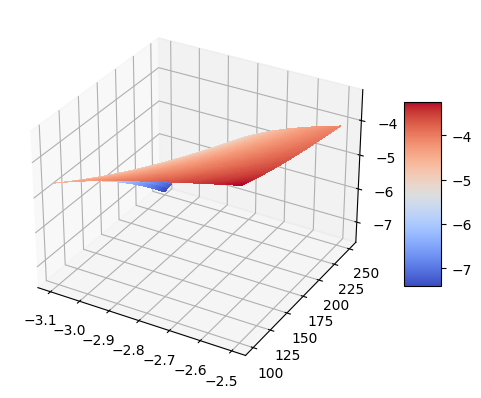

In [579]:

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X, Y = np.meshgrid(cross_u_list, cross_d_list)

# Plot the surface.
surf = ax.plot_surface(np.log10(X), Y, np.log10(data_cross_TP), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

PhD/Results/case/figures/TP_sweep_u_d
PhD/Results/case/figures/IP_sweep_u_d


((<Figure size 640x480 with 2 Axes>,
  <Axes: xlabel='$d$', ylabel='$\\sigma_u$'>),
 (<Figure size 640x480 with 2 Axes>,
  <Axes: xlabel='$d$', ylabel='$\\sigma_u$'>))

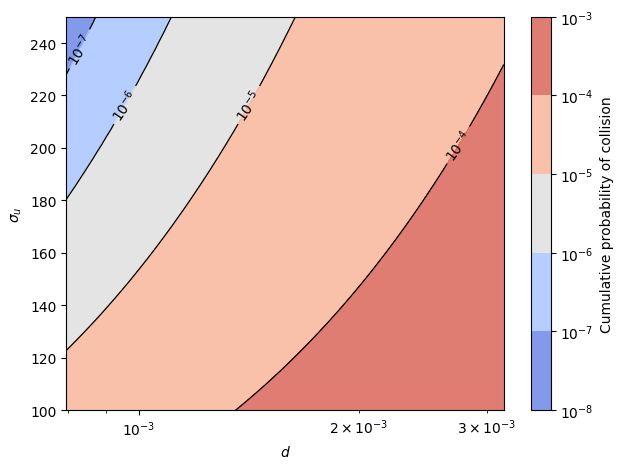

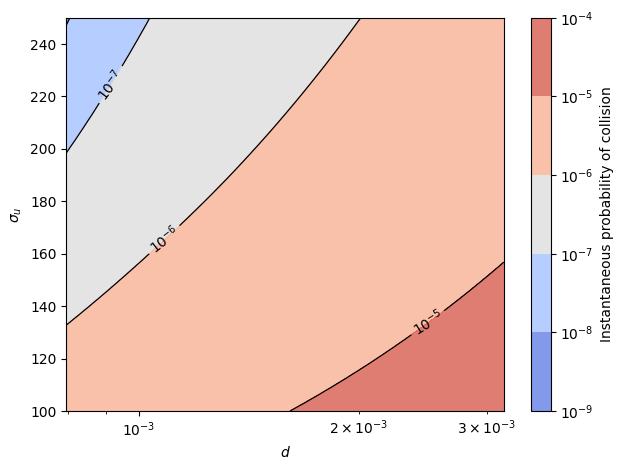

In [580]:
xlabel = r'$\sigma_u$'
ylabel = r'$d$'
plot_double_contours(cross_u_list, cross_d_list, [data_cross_TP, data_cross_IP], True, False, True, save=True, xlabel=xlabel, ylabel=ylabel, figures_path=figures_path, tag='sweep_u_d')